In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
from grispy import GriSPy
from glob import glob
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering     
from scipy import stats
from scipy.stats import beta
import ast
from collections import defaultdict
from itertools import permutations, combinations
import time
from joblib import Parallel, delayed
from tqdm import tqdm
import random
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
from matplotlib import pyplot as plt
import os
from skimage import io, transform, util, img_as_float
from skimage.filters import gaussian
from skimage.color import separate_stains, hax_from_rgb
from skimage.exposure import rescale_intensity
from skimage.util import img_as_ubyte, crop
from skimage.draw import rectangle
from skimage.morphology import remove_small_objects, remove_small_holes
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import math
import numpy as np
import tifffile
import cv2
import numpy as np
import time
import re

from joblib import Parallel, delayed
from itertools import groupby
from tqdm import tqdm
import pandas as pd
import multiprocessing
available_cores = multiprocessing.cpu_count()

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from grispy import GriSPy

import turtle

plt.rcParams['image.cmap'] = 'gray'

%load_ext autotime

time: 182 µs (started: 2022-08-11 15:19:31 -05:00)


In [3]:
#set pipeline output directory
output_dir = None
#set image input directory
raw_img_dir = None  # for each round of imaging, images should be saved by the slide name and placed in a folder named for the marker that has been stained in the contained images
# input order of MxIHC staining
stain_order = ['PD-1', 'PD-L1', 'CD68', 'FoxP3', 'Iba-1', 'CD8', 'CD4']
# input patient IDs
slide_id = ['N16-244-2A']   


time: 264 µs (started: 2022-08-11 15:19:31 -05:00)


In [5]:
# Setting variables

#BaseAligned image input
input_folder = output_dir + '/BaseAligned'
#Tiles output
output_folder = output_dir + '/Tiled'
# registered stack output
reg_folder = output_dir + '/Registered'

tile_x, tile_y = 2048, 2048              # Can Edit Tile Size Here
overlap_x, overlap_y = 512, 512          # Can Edit Overlap Here

background_int = 250                     # Can Edit Mean Pixel Intensity for Tissue Detection Here

_ransacReprojThreshold = 3               # Can Edit Maximum allowed reprojection error to treat a point pair as an inlier (used in the RANSAC method only) for Keypoint registration

_num_good = 10                           # Can Edit Minimum number of good matches needed for keypoint registration to be considered successful
_averageDistance = 0.5                   # Can Edit Maximum average distance of keypoint matches for registration to be considered successful

seed = 42                                # seed value to make results reproducable.  Set to 'None' to use a random seed and gain increased multiprocessing resulting in faster results 

# Neighborhood Analysis Variables
neighbor_search = 'voronoi'                  # either 'voronoi', 'shell', or 'knn'
neighbor_search_value = 10               # if neighbor_search is set to 'voronoi', disreguard. if set to 'shell' value = maximum pixel distance for neighbor cell detection. if set to 'knn' value = number of neighbors to be found
# Parent folder for neighborhood analysis files
neighborhood_dir = output_dir + '/Neighborhood'
# Individual files for each slide / gate combination.  Naming scheme should be as follows : SlideID_GateID.csv  (Must be underscore delimited)
gates_dir = neighborhood_dir + '/Gated_Input'
# Individual csvs per slide
perslide_dir = neighborhood_dir + '/Gated_Perslide'
# Log Odds outputs
logodds_dir = neighborhood_dir + '/LogOdds'
#Interaction Counts
interactions_dir = logodds_dir + '/Interactions'
# Neighbor cell csvs
neighbor_csv_dir = neighborhood_dir + '/Neighbor_CSVs'
# Neighbor cell csvs + umap coordinates based on neighbor frequencies
neighbor_umap_dir = neighborhood_dir + '/Neighborhood_Umap_CSVs'
# Neighborhood analysis plot outputs
neighbor_plots_dir = neighborhood_dir + '/Neighborhood_Plots'

time: 1.59 ms (started: 2022-08-11 15:20:01 -05:00)


In [6]:
os.makedirs(neighborhood_dir, exist_ok = True)
os.makedirs(gates_dir, exist_ok = True)
os.makedirs(perslide_dir, exist_ok = True)
os.makedirs(logodds_dir, exist_ok = True)
os.makedirs(neighbor_csv_dir, exist_ok = True)
os.makedirs(neighbor_umap_dir, exist_ok = True)
os.makedirs(interactions_dir, exist_ok = True)
os.makedirs(neighbor_plots_dir, exist_ok = True)
os.makedirs(neighbor_plots_dir + '/Per_Slide', exist_ok = True)
os.makedirs(neighbor_plots_dir + '/Per_Cluster', exist_ok = True)                
os.makedirs(interactions_dir + '/Slide', exist_ok = True)
os.makedirs(interactions_dir + '/Tile', exist_ok = True)

time: 3.43 ms (started: 2022-08-11 15:20:09 -05:00)


## Log Odds Analysis

In [30]:
l_csv = sorted(glob(gates_dir + '/*.csv'))


time: 1.31 ms (started: 2022-08-11 15:32:17 -05:00)


In [31]:
l_pops = []
l_slides = []
l_data = []

for file in l_csv:
    name = os.path.basename(file)
    pat, pop = os.path.splitext(name)[0].split('_')
    
    data = pd.read_csv(file, header = 0)
    data['pop_ID'] = pop
    data['slide_id'] = pat
    data['Tile'] = data.apply(lambda row: (int(row.Tile_row), int(row.Tile_col)), axis = 1)
    l_pops.append(pop)
    l_slides.append(pat)
    l_data.append(data)

df_data = pd.concat(l_data)   
l_pops = sorted(list(set(l_pops)))
l_slides = sorted(list(set(l_slides)))

time: 133 ms (started: 2022-08-11 15:32:18 -05:00)


In [32]:
vor_colors = ['#ff0000',
              '#cccc66', 
              '#ffff00', 
              '#ff9999',
              '#99cc00',
              '#ff6600',
              '#009900',
              '#ffcc66', 
              '#cc66cc',
              '#00cccc',
              '#ff66cc',
              '#0000ff',
              '#663399', 
              '#cccccc']

vor_pops = {}
for index, l in enumerate(l_pops):
    vor_pops[l] = vor_colors[index]

#confirm populations and hex codes match as desired    
vor_pops

{'CD4T A': '#ff0000',
 'CD4T B': '#cccc66',
 'CD4T C': '#ffff00',
 'CD4T D': '#ff9999',
 'CD8T A': '#99cc00',
 'CD8T B': '#ff6600',
 'DNT A': '#009900',
 'DNT B': '#ffcc66',
 'Macrophage A': '#cc66cc',
 'Macrophage B': '#00cccc',
 'Microglia A': '#ff66cc',
 'Microglia B': '#0000ff',
 'Tumor A': '#663399',
 'Tumor B': '#cccccc'}

time: 4.75 ms (started: 2022-08-11 15:32:20 -05:00)


In [33]:
# calculates global percentages of each gated population across all slides
d_pops = {}
for i in l_pops:
    global_ratio = df_data[df_data.pop_ID == i].shape[0]/df_data.shape[0]
    d_pops[i] = global_ratio

time: 23 ms (started: 2022-08-11 15:32:23 -05:00)


In [34]:
# Resaves gated cells per slide
for i, g in df_data.groupby('slide_id'):
    g.to_csv(perslide_dir + '/{}.csv'.format(i), index = False)

l_intfiles = sorted(glob(perslide_dir + '/*.csv'))

time: 143 ms (started: 2022-08-11 15:32:24 -05:00)


In [35]:
def calc_niche_slide(csv):
    log = open(logodds_dir + '/calc_niche_slide_savelog.txt', 'w+')
    raw_int = pd.read_csv(csv)
    for pop in l_pops:
        raw_int[pop] = raw_int.apply(lambda row: 1 if row.pop_ID == pop else 0 , axis = 1)
    all_long_list = []
    total_count = 0
    for tile in raw_int.Tile.unique():
        try:
            df_tile = raw_int[raw_int['Tile']==tile]
            df_tile.reset_index(inplace=True)
            slide_id = os.path.splitext(os.path.basename(csv))[0]
            tile_r = int(df_tile.Tile_row[0])
            tile_c = int(df_tile.Tile_col[0])
            # define new array of just coordinates to find first order neighbors
            coords = np.asarray(df_tile[['centroid-1', 'centroid-0']])
            # create dict of indexes of cells : neighbor cells
            if neighbor_search == 'voronoi':
                tri = Delaunay(coords)
                vor = Voronoi(coords)
                _neighbors = defaultdict(set)
                for simplex in tri.vertices:
                    for i, j in permutations(simplex, 2):
                        _neighbors[i].add(j)

                total_count += len(vor.ridge_vertices)
            elif neighbor_search == 'shell':
                gsp = GriSPy(coords)
                upper_radii = float(neighbor_search_value)
                lower_radii = 0.01
                shell_dist, shell_ind = gsp.shell_neighbors(
                    coords,
                    distance_lower_bound=lower_radii,
                    distance_upper_bound=upper_radii
                )

                _neighbors = {}
                count = 0
                for index, v in enumerate(shell_ind):
                    _neighbors[index] = set(v)
                    count += len(v)
                total_count += count
            elif neighbor_search == 'knn':
                gsp = GriSPy(coords)
                knn = int(neighbor_search_value)
                knn_dist, knn_ind = gsp.nearest_neighbors(
                    coords,
                    n = knn
                )
                _neighbors = {}
                count = 0
                for index, v in enumerate(knn_ind):
                    _neighbors[index] = set(v)
                    count += len(v)
                total_count += count
                    
            long_list = []
            for k, v in _neighbors.items():
                for value in list(v):
                    long_list.append([k, value])
            if len(long_list) > 0:
                df_long_list = pd.DataFrame(long_list, columns = ['index_cell', 'neighbor'])
                df_long_list['sorted_row'] = [sorted([a,b]) for a, b in zip(df_long_list.index_cell, df_long_list.neighbor)]
                df_long_list['sorted_row'] = df_long_list['sorted_row'].astype(str)
                df_long_list.drop_duplicates(subset = ['sorted_row'], inplace = True)
                df_long_list.reset_index(inplace = True)  
                df_long_list['index_id'] = df_long_list.apply(lambda row: list(df_tile.loc[[row.index_cell]]['pop_ID'])[0], axis = 1)
                df_long_list['neighbor_id'] = df_long_list.apply(lambda row: list(df_tile.loc[[row.neighbor]]['pop_ID'])[0], axis = 1)
                df_long_list['sorted_row2'] = [sorted([a,b]) for a,b in zip(df_long_list.index_id, df_long_list.neighbor_id)]
                df_long_list['sorted_row2'] = df_long_list['sorted_row2'].astype(str)

                all_long_list.append(df_long_list)

                df_iniche = pd.DataFrame()

                for k, v in _neighbors.items():
                    if v == set():
                        continue
                    else:
                        _df_iniche = pd.DataFrame()
                        for x in range(len(_neighbors[k])):
                            _df_iniche = _df_iniche.append(df_tile.loc[[list(v)[x]]])
                            _df_iniche.drop(columns = ['index', 'Tile', 'slide_id', 'pop_ID'], inplace = True)


                        sums = pd.DataFrame(_df_iniche.sum(axis = 0)/len(_df_iniche.index)).transpose() 
                        sums.drop(sums.columns.difference(l_pops), 1, inplace = True)
                        sums.reset_index(inplace = True)

                        df_index_cell = pd.DataFrame(df_tile.loc[k][['centroid-0', 'centroid-1']]).transpose()
                        df_index_cell.reset_index(inplace = True)

                        df_niche = pd.concat([sums, df_index_cell], axis = 1)
                        df_iniche = df_iniche.append(df_niche)

                df_merge = df_tile.drop(columns = [x for x in l_pops])
                df_merge.drop(columns = ['index'], inplace = True)
                new_df = df_iniche.merge(df_merge, on = ['centroid-0', 'centroid-1'])
                new_df.drop(columns = new_df.columns[0], axis = 1, inplace = True)
                # For each cell neighbor-frequencies of each gated population
                new_df.to_csv(neighbor_csv_dir + '/{}_r{}_c{}.csv'.format(slide_id, tile_r, tile_c), index = False)
        except:
            log.write('Error on {} {} {}\n'.format(slide_id, tile_r, tile_c))
            pass
        
    df_long_list = pd.concat(all_long_list)
    pop_counts = {}
    for pop in l_pops:
        pop_counts[pop] = len(df_long_list[(df_long_list['index_id']==pop) | (df_long_list['neighbor_id'] == pop)].index)


    interactions = df_long_list.groupby(['sorted_row2']).size().reset_index(name='interaction_counts')

    interactions['beta_dist'] = interactions.apply(lambda row: beta.stats(row.interaction_counts, total_count-row.interaction_counts, moments = 'm'), axis = 1)

    interactions['pops'] = interactions.apply(lambda row: ast.literal_eval(row.sorted_row2), axis = 1)
    interactions['popA'] = interactions.apply(lambda row: row.pops[0], axis = 1)
    interactions['popB'] = interactions.apply(lambda row: row.pops[1], axis = 1)

    interactions['popA_freq'] = interactions.apply(lambda row: pop_counts[row.popA], axis = 1)
    interactions['popB_freq'] = interactions.apply(lambda row: pop_counts[row.popB], axis = 1)
    interactions['total_count'] = total_count

    interactions['odds_ratio'] = interactions.apply(lambda row: row.beta_dist/ ((row.popA_freq/total_count) * (row.popB_freq/total_count)), axis = 1)
    interactions['log_odds_ratio'] = interactions.apply(lambda row: np.log(row.odds_ratio), axis = 1)
    interactions = interactions[['pops', 'popA', 'popB', 'interaction_counts', 'beta_dist', 'popA_freq', 'popB_freq', 'total_count', 'odds_ratio', 'log_odds_ratio','sorted_row2']]
    #log odds of each gated population versus every other gated population across full slide
    interactions.to_csv(interactions_dir + '/Slide/interactions_{}.csv'.format(os.path.splitext(os.path.basename(csv))[0]))
    
    log.close()


time: 2.73 ms (started: 2022-08-11 15:32:27 -05:00)


In [36]:
def calc_niche_tiles(csv):
    # Calculate log odds of gated populations within each tile
    log = open(logodds_dir + '/calc_niche_tiles_savelog.txt', 'w+')
    raw_int = pd.read_csv(csv)
    for pop in l_pops:
        raw_int[pop] = raw_int.apply(lambda row: 1 if row.pop_ID == pop else 0 , axis = 1)
    for tile in raw_int.Tile.unique():
        total_count = 0
        try:
            df_tile = raw_int[raw_int['Tile']==tile]
            df_tile.reset_index(inplace=True)
            slide_id = os.path.splitext(os.path.basename(csv))[0]
            tile_r = int(df_tile.Tile_row[0])
            tile_c = int(df_tile.Tile_col[0])
            # define new array of just coordinates to find first order neighbors
            coords = np.asarray(df_tile[['centroid-1', 'centroid-0']])
            # create dict of indexes of cells : neighbor cells
            if neighbor_search == 'voronoi':
                tri = Delaunay(coords)
                vor = Voronoi(coords)
                _neighbors = defaultdict(set)
                for simplex in tri.vertices:
                    for i, j in permutations(simplex, 2):
                        _neighbors[i].add(j)

                total_count += len(vor.ridge_vertices)
            elif neighbor_search == 'shell':
                gsp = GriSPy(coords)
                upper_radii = float(neighbor_search_value)
                lower_radii = 0.01
                shell_dist, shell_ind = gsp.shell_neighbors(
                    coords,
                    distance_lower_bound=lower_radii,
                    distance_upper_bound=upper_radii
                )

                _neighbors = {}
                count = 0
                for index, v in enumerate(shell_ind):
                    _neighbors[index] = set(v)
                    count += len(v)
                total_count += count
            elif neighbor_search == 'knn':
                gsp = GriSPy(coords)
                knn = int(neighbor_search_value)
                knn_dist, knn_ind = gsp.nearest_neighbors(
                    coords,
                    n = knn
                )
                _neighbors = {}
                count = 0
                for index, v in enumerate(knn_ind):
                    _neighbors[index] = set(v)
                    count += len(v)
                total_count += count
            long_list = []
            for k, v in _neighbors.items():
                for value in list(v):
                    long_list.append([k, value])
            if len(long_list) > 0:
                df_long_list = pd.DataFrame(long_list, columns = ['index_cell', 'neighbor'])
                df_long_list['sorted_row'] = [sorted([a,b]) for a, b in zip(df_long_list.index_cell, df_long_list.neighbor)]
                df_long_list['sorted_row'] = df_long_list['sorted_row'].astype(str)
                df_long_list.drop_duplicates(subset = ['sorted_row'], inplace = True)
                df_long_list.reset_index(inplace = True)  
                df_long_list['index_id'] = df_long_list.apply(lambda row: list(df_tile.loc[[row.index_cell]]['pop_ID'])[0], axis = 1)
                df_long_list['neighbor_id'] = df_long_list.apply(lambda row: list(df_tile.loc[[row.neighbor]]['pop_ID'])[0], axis = 1)
                df_long_list['sorted_row2'] = [sorted([a,b]) for a,b in zip(df_long_list.index_id, df_long_list.neighbor_id)]
                df_long_list['sorted_row2'] = df_long_list['sorted_row2'].astype(str)
        
            pop_counts = {}
            for pop in l_pops:
                pop_counts[pop] = len(df_long_list[(df_long_list['index_id']==pop) | (df_long_list['neighbor_id'] == pop)].index)


            interactions = df_long_list.groupby(['sorted_row2']).size().reset_index(name='interaction_counts')

            interactions['beta_dist'] = interactions.apply(lambda row: beta.stats(row.interaction_counts, total_count-row.interaction_counts, moments = 'm'), axis = 1)

            interactions['pops'] = interactions.apply(lambda row: ast.literal_eval(row.sorted_row2), axis = 1)
            interactions['popA'] = interactions.apply(lambda row: row.pops[0], axis = 1)
            interactions['popB'] = interactions.apply(lambda row: row.pops[1], axis = 1)

            interactions['popA_freq'] = interactions.apply(lambda row: pop_counts[row.popA], axis = 1)
            interactions['popB_freq'] = interactions.apply(lambda row: pop_counts[row.popB], axis = 1)
            interactions['total_count'] = total_count

            interactions['odds_ratio'] = interactions.apply(lambda row: row.beta_dist/ ((row.popA_freq/total_count) * (row.popB_freq/total_count)), axis = 1)
            interactions['log_odds_ratio'] = interactions.apply(lambda row: np.log(row.odds_ratio), axis = 1)
            interactions = interactions[['pops', 'popA', 'popB', 'interaction_counts', 'beta_dist', 'popA_freq', 'popB_freq', 'total_count', 'odds_ratio', 'log_odds_ratio','sorted_row2']]
            interactions.to_csv(interactions_dir + '/Tile/interactions_{}_r{}_c{}.csv'.format(os.path.splitext(os.path.basename(csv))[0], tile_r, tile_c))
        except:
            log.write('Error on {}_{}_{}\n'.format(slide_id, tile_r, tile_c))
            pass

time: 2.28 ms (started: 2022-08-11 15:32:28 -05:00)


In [37]:
#Parallel processing of neighborhood niche analysis per slide
#Can be time + resource intensive on large datasets, can edit n_jobs to 1 to disable parallel processing if workstation is running out of memory
Parallel(n_jobs = int(available_cores * 0.9), backend = 'loky')(delayed(calc_niche_slide)(x)for x in tqdm(l_intfiles))

100%|██████████| 1/1 [00:00<00:00, 44.46it/s]


[None]

time: 1min 44s (started: 2022-08-11 15:32:30 -05:00)


In [38]:
# Parallel processing of neighborhood niche analysis per tile
Parallel(n_jobs = int(available_cores * 0.9), backend = 'loky')(delayed(calc_niche_tiles)(x)for x in tqdm(l_intfiles))

100%|██████████| 1/1 [00:00<00:00, 883.57it/s]


[None]

time: 10.7 s (started: 2022-08-11 15:34:14 -05:00)


### Per Slide and All Slides Log Odds

In [39]:
#Calculate log odds across all slides
all_long_list = []
total_count = 0
for csv in l_intfiles:
    raw_int = pd.read_csv(csv)
    for pop in l_pops:
        raw_int[pop] = raw_int.apply(lambda row: 1 if row.pop_ID == pop else 0 , axis = 1)
    for tile in raw_int.Tile.unique():
        try:
            df_tile = raw_int[raw_int['Tile']==tile]
            df_tile.reset_index(inplace=True)
            slide_id = os.path.basename(csv)[:-4]
            tile_r = int(df_tile.Tile_row[0])
            tile_c = int(df_tile.Tile_col[0])
            # define new array of just coordinates to find first order neighbors
            coords = np.asarray(df_tile[['centroid-1', 'centroid-0']])
            # create dict of indexes of cells : neighbor cells
            tri = Delaunay(coords)
            vor = Voronoi(coords)
            _neighbors = defaultdict(set)
            for simplex in tri.vertices:
                for i, j in permutations(simplex, 2):
                    _neighbors[i].add(j)

            total_count += len(vor.ridge_vertices)

            long_list = []
            for k, v in _neighbors.items():
                for value in list(v):
                    long_list.append([k, value])

            df_long_list = pd.DataFrame(long_list, columns = ['index_cell', 'neighbor'])
            df_long_list['sorted_row'] = [sorted([a,b]) for a, b in zip(df_long_list.index_cell, df_long_list.neighbor)]
            df_long_list['sorted_row'] = df_long_list['sorted_row'].astype(str)
            df_long_list.drop_duplicates(subset = ['sorted_row'], inplace = True)
            df_long_list.reset_index(inplace = True)  
            df_long_list['index_id'] = df_long_list.apply(lambda row: list(df_tile.loc[[row.index_cell]]['pop_ID'])[0], axis = 1)
            df_long_list['neighbor_id'] = df_long_list.apply(lambda row: list(df_tile.loc[[row.neighbor]]['pop_ID'])[0], axis = 1)
            df_long_list['sorted_row2'] = [sorted([a,b]) for a,b in zip(df_long_list.index_id, df_long_list.neighbor_id)]
            df_long_list['sorted_row2'] = df_long_list['sorted_row2'].astype(str)

            all_long_list.append(df_long_list)
        except:
            pass

df_long_list = pd.concat(all_long_list)
pop_counts = {}
for pop in l_pops:
    pop_counts[pop] = len(df_long_list[(df_long_list['index_id']==pop) | (df_long_list['neighbor_id'] == pop)].index)


interactions = df_long_list.groupby(['sorted_row2']).size().reset_index(name='interaction_counts')

interactions['beta_dist'] = interactions.apply(lambda row: beta.stats(row.interaction_counts, (total_count)-row.interaction_counts, moments = 'm'), axis = 1)

interactions['pops'] = interactions.apply(lambda row: ast.literal_eval(row.sorted_row2), axis = 1)
interactions['popA'] = interactions.apply(lambda row: row.pops[0], axis = 1)
interactions['popB'] = interactions.apply(lambda row: row.pops[1], axis = 1)

interactions['popA_freq'] = interactions.apply(lambda row: pop_counts[row.popA], axis = 1)
interactions['popB_freq'] = interactions.apply(lambda row: pop_counts[row.popB], axis = 1)
interactions['total_count'] = total_count

interactions['odds_ratio'] = interactions.apply(lambda row: row.beta_dist/ ((row.popA_freq/total_count) * (row.popB_freq/total_count)), axis = 1)
interactions['log_odds_ratio'] = interactions.apply(lambda row: np.log(row.odds_ratio), axis = 1)
interactions = interactions[['pops', 'popA', 'popB', 'interaction_counts', 'beta_dist', 'popA_freq', 'popB_freq', 'total_count', 'odds_ratio', 'log_odds_ratio','sorted_row2']]
interactions.to_csv(logodds_dir + '/all_slides_interactions.csv')


time: 10.5 s (started: 2022-08-11 15:34:25 -05:00)


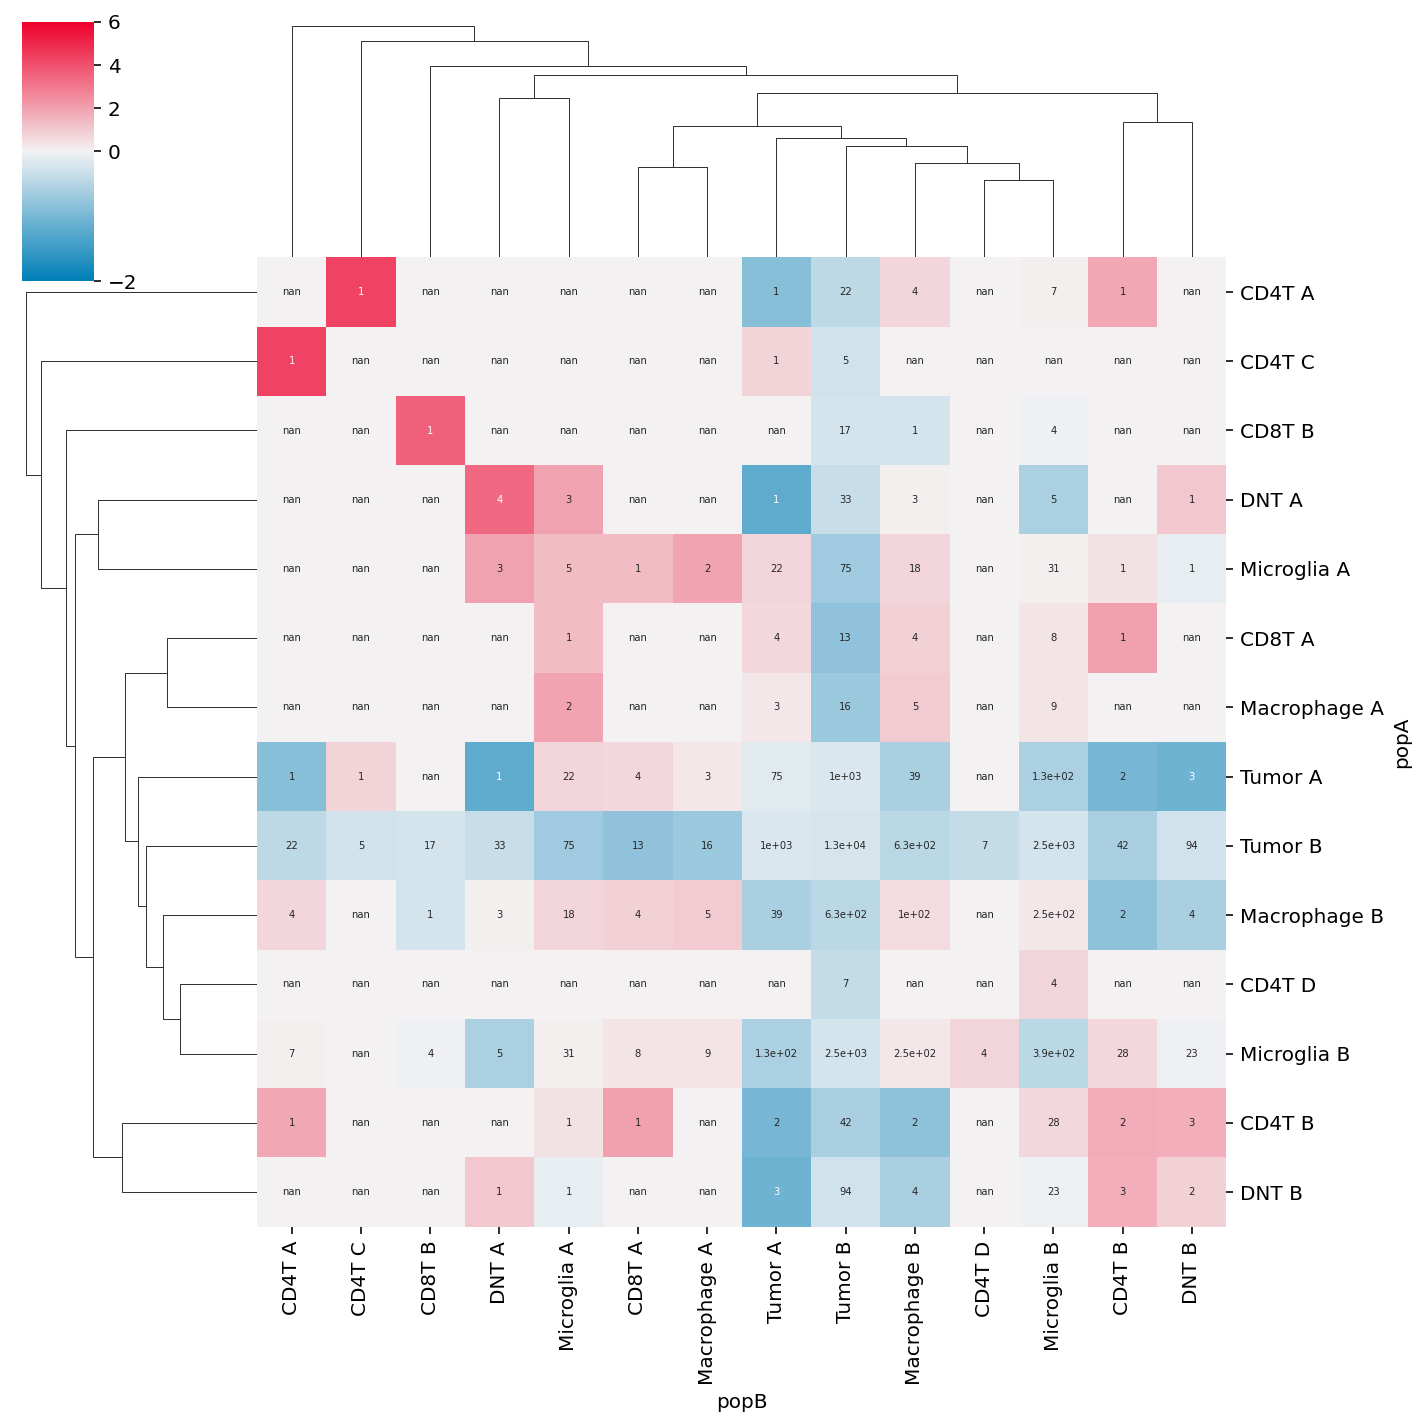

time: 1.02 s (started: 2022-08-11 15:34:36 -05:00)


In [40]:
interactions = pd.read_csv(logodds_dir + '/all_slides_interactions.csv')
halfheatmap = interactions[['popA', 'popB', 'log_odds_ratio']]
halfheatmap2 = halfheatmap.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
full_heatmap = pd.concat([halfheatmap, halfheatmap2]).drop_duplicates()
heatmap2 = full_heatmap.pivot('popA', 'popB', 'log_odds_ratio')

count_inter = interactions[['popA', 'popB', 'interaction_counts']]
count_inter2 = count_inter.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
full_count_inter = pd.concat([count_inter, count_inter2]).drop_duplicates()
count_inter_heatmap = full_count_inter.pivot('popA', 'popB', 'interaction_counts')

rdbl = sns.diverging_palette(240,10, n = 99, l = 50, s=100,as_cmap = True)
#divnorm = mcolors.TwoSlopeNorm(vmin = min(-0.2, heatmap2.min().min()), vcenter = 0, vmax = max(heatmap2.max().max(), 0.2))
divnorm = mcolors.TwoSlopeNorm(vmin = -2, vmax = 6, vcenter = 0)
g = sns.clustermap(heatmap2.fillna(0), cmap = rdbl, norm = divnorm, method = 'average', annot = count_inter_heatmap, annot_kws={"fontsize":5})#.fig.suptitle('Log Odds Ratio of Population Interactions')
plt.savefig(logodds_dir + '/Log_Odds_Ratio_clustergram_all_slides.pdf')
heatmap3 = heatmap2[[heatmap2.columns[i] for i in g.dendrogram_col.reordered_ind]]
new_order = [col for col in heatmap3.columns]

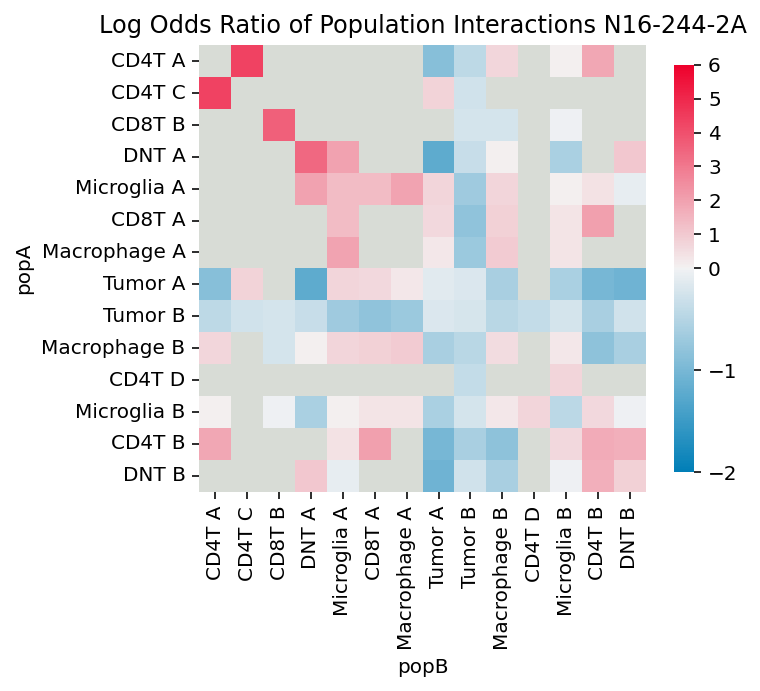

time: 396 ms (started: 2022-08-11 15:34:37 -05:00)


In [41]:
# per slide log odds interactions
l_interactions_slide = sorted(glob(interactions_dir + '/Slide/*.csv'))
l_heatmaps = []
for l in l_interactions_slide:
    plt.figure(figsize = (5,5))
    interactions = pd.read_csv(l)
    halfheatmap = interactions[['popA', 'popB', 'log_odds_ratio']]
    halfheatmap2 = halfheatmap.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
    full_heatmap = pd.concat([halfheatmap, halfheatmap2]).drop_duplicates()
    heatmap2 = full_heatmap.pivot('popA', 'popB', 'log_odds_ratio')
    heatmap3 = heatmap2.reindex(index = new_order, columns = new_order)
    
    count_inter = interactions[['popA', 'popB', 'interaction_counts']]
    count_inter2 = count_inter.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
    full_count_inter = pd.concat([count_inter, count_inter2]).drop_duplicates()
    count_inter_heatmap = full_count_inter.pivot('popA', 'popB', 'interaction_counts')
    count_inter_heatmap = count_inter_heatmap.reindex(index = new_order, columns = new_order)
    
    rdbl = sns.diverging_palette(240,10, n = 99, l = 50, s=100,as_cmap = True)
    divnorm = mcolors.TwoSlopeNorm(vmin = -2, vcenter = 0, vmax = 6)
    mask = heatmap3.isnull()
    g = sns.heatmap(heatmap3, square = True, cmap = rdbl, norm = divnorm, cbar = True, mask = mask, 
#                    annot = count_inter_heatmap, annot_kws={"fontsize":3}, 
                    cbar_kws={'shrink':0.75})
    g.set_title('Log Odds Ratio of Population Interactions {}'.format(os.path.basename(l)[13:-4]))
    g.set_facecolor('#d8dcd6')
    plt.savefig(logodds_dir + '/Log_Odds_Ratio_clustergram_{}.pdf'.format(os.path.splitext(os.path.basename(l))[0]), bbox_inches = 'tight')
    l_heatmaps.append(heatmap3)

In [42]:
# combine all patient specific heatmaps and calculate median value for each heatmap square
concat_heatmaps = pd.concat(l_heatmaps)
concat_heatmaps = concat_heatmaps.groupby(level = 0).median()

time: 1.68 ms (started: 2022-08-11 15:34:37 -05:00)


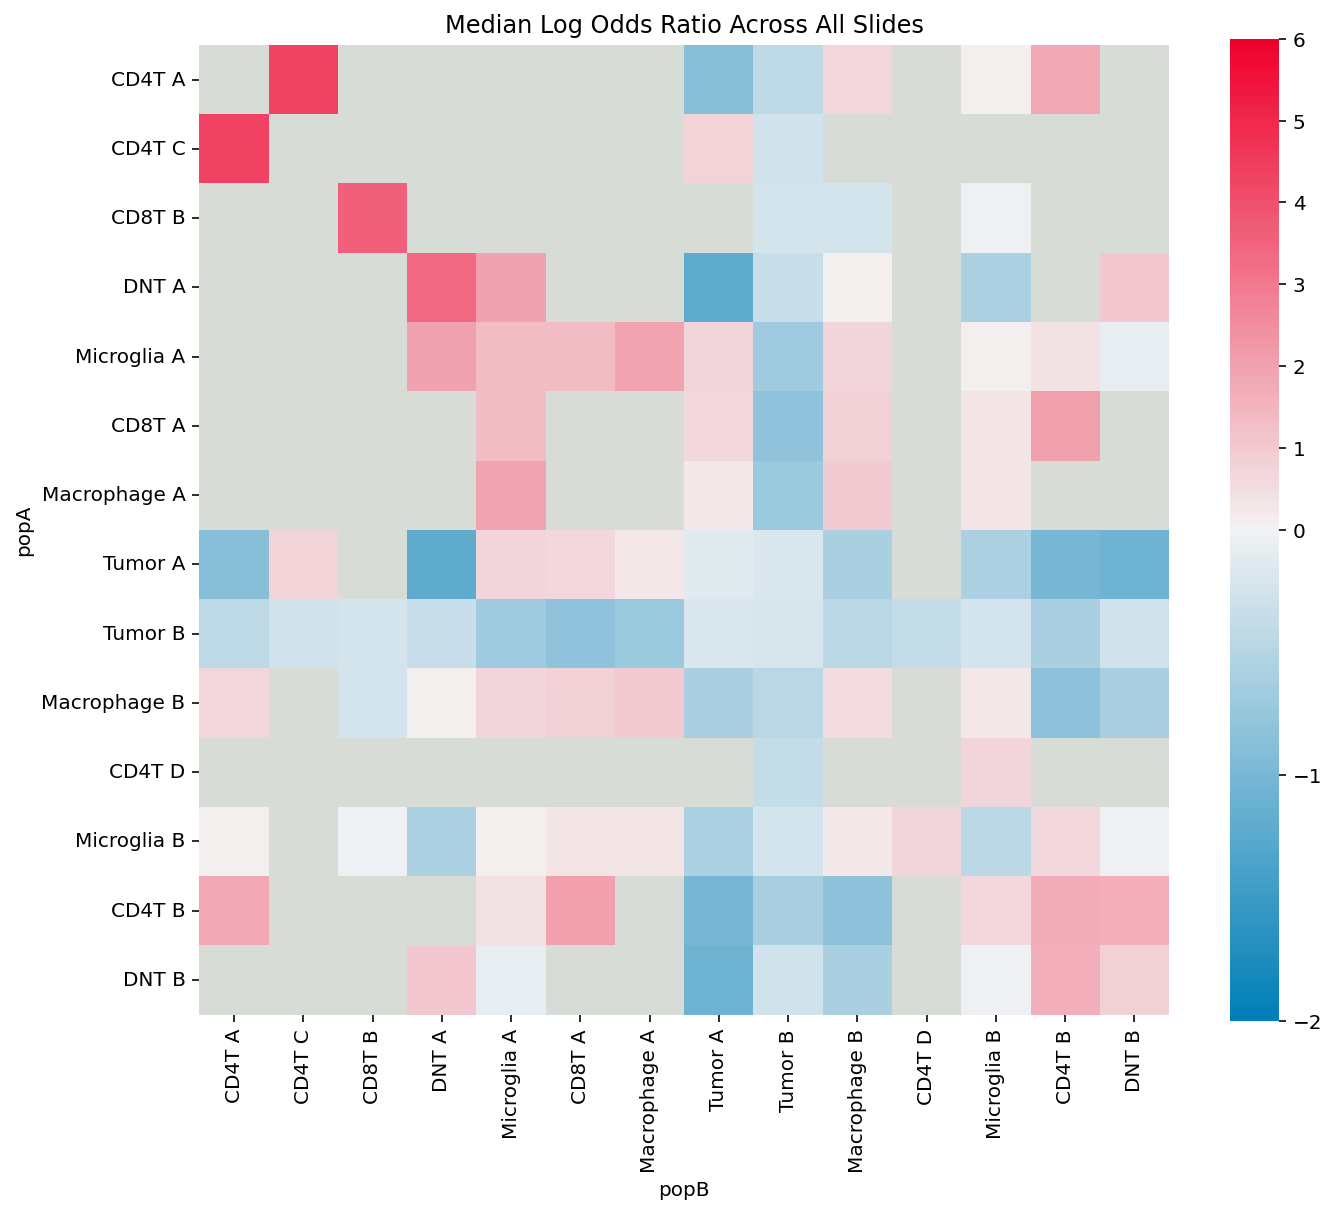

time: 433 ms (started: 2022-08-11 15:34:37 -05:00)


In [43]:
# heatmap of all median patient values 
plt.figure(figsize = (10,10))
concat_heatmaps = concat_heatmaps.reindex(index = new_order, columns = new_order)
mask = concat_heatmaps.isnull()
g = sns.heatmap(concat_heatmaps, square = True, cmap = rdbl, norm = divnorm, cbar = True, mask = mask, cbar_kws={'shrink':0.75})
g.set_facecolor('#d8dcd6')
plt.title('Median Log Odds Ratio Across All Slides')
plt.tight_layout()
plt.savefig(logodds_dir + '/Median_Log_Odds_Ratio_All_Slides.pdf')


### Per Tile Log Odds

In [44]:
l_interactions_tile = sorted(glob(interactions_dir + '/Tile/*.csv'))

time: 594 µs (started: 2022-08-11 15:34:38 -05:00)


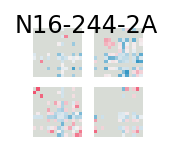

time: 263 ms (started: 2022-08-11 15:34:38 -05:00)


In [45]:
l_tile_heatmaps = []
for pat in l_slides:
    meta_tile = {}
    for l in l_interactions_tile:
        _,patid, r, c = os.path.basename(l)[:-4].split('_')
        row = int(r[1:])
        col = int(c[1:])
        if patid == pat:
            meta_tile[(row, col)] = l

    l_tiles = [item for item in list(meta_tile.items())]
    nrows = list(range(max([sublist[0][0] for sublist in l_tiles])+1))
    ncols = list(range(max([sublist[0][1] for sublist in l_tiles])+1))
    combined = [(f,s) for f in nrows for s in ncols]

    l_for_fig = []
    for item in combined:
        try:
            l_for_fig.append([item,meta_tile[item]])
        except:
            l_for_fig.append([item, 'blank'])

    fig, axes = plt.subplots(nrows = max(nrows)+1, ncols = max(ncols)+1,figsize = (max(ncols*50), max(nrows*50)), sharex=True, sharey = True) 
    fig.subplots_adjust(hspace = 0.2, wspace = 0.2)
    for tile in l_for_fig:
        row = tile[0][0]
        col = tile[0][1]
        if tile[1] == 'blank':
            axes[row, col].axis('off')
        else:
            interactions = pd.read_csv(tile[1])
            halfheatmap = interactions[['popA', 'popB', 'log_odds_ratio']]
            halfheatmap2 = halfheatmap.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
            full_heatmap = pd.concat([halfheatmap, halfheatmap2]).drop_duplicates()
            heatmap2 = full_heatmap.pivot('popA', 'popB', 'log_odds_ratio')
            heatmap3 = heatmap2.reindex(index = new_order, columns = new_order)
            
            count_inter = interactions[['popA', 'popB', 'interaction_counts']]
            count_inter2 = count_inter.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
            full_count_inter = pd.concat([count_inter, count_inter2]).drop_duplicates()
            count_inter_heatmap = full_count_inter.pivot('popA', 'popB', 'interaction_counts')
            count_inter_heatmap = count_inter_heatmap.reindex(index = new_order, columns = new_order)
            
            rdbl = sns.diverging_palette(240,10, n = 99, l = 50, s=100,as_cmap = True)
            divnorm = mcolors.TwoSlopeNorm(vmin = -2, vcenter = 0, vmax = 6)
            mask = heatmap3.isnull()
            g= sns.heatmap(heatmap3, ax = axes[row, col],xticklabels = False, yticklabels = False, square = True, mask = mask, cmap = rdbl, norm = divnorm, cbar = False, 
#                           annot = count_inter_heatmap, annot_kws={"fontsize":1}
                          )
            g.set(xlabel = None, ylabel = None)
#            g.set_title('{}, {}'.format(row, col), fontsize = 5)
            g.set_aspect('equal')
            g.set_facecolor('#d8dcd6')
            l_tile_heatmaps.append(heatmap3)
    plt.suptitle('{}'.format(pat))
#    plt.tight_layout(pad = 1)
    plt.savefig(logodds_dir + '/Log_Odds_Ratio_clustergrams_{}_map.pdf'.format(pat), bbox_inches = 'tight')


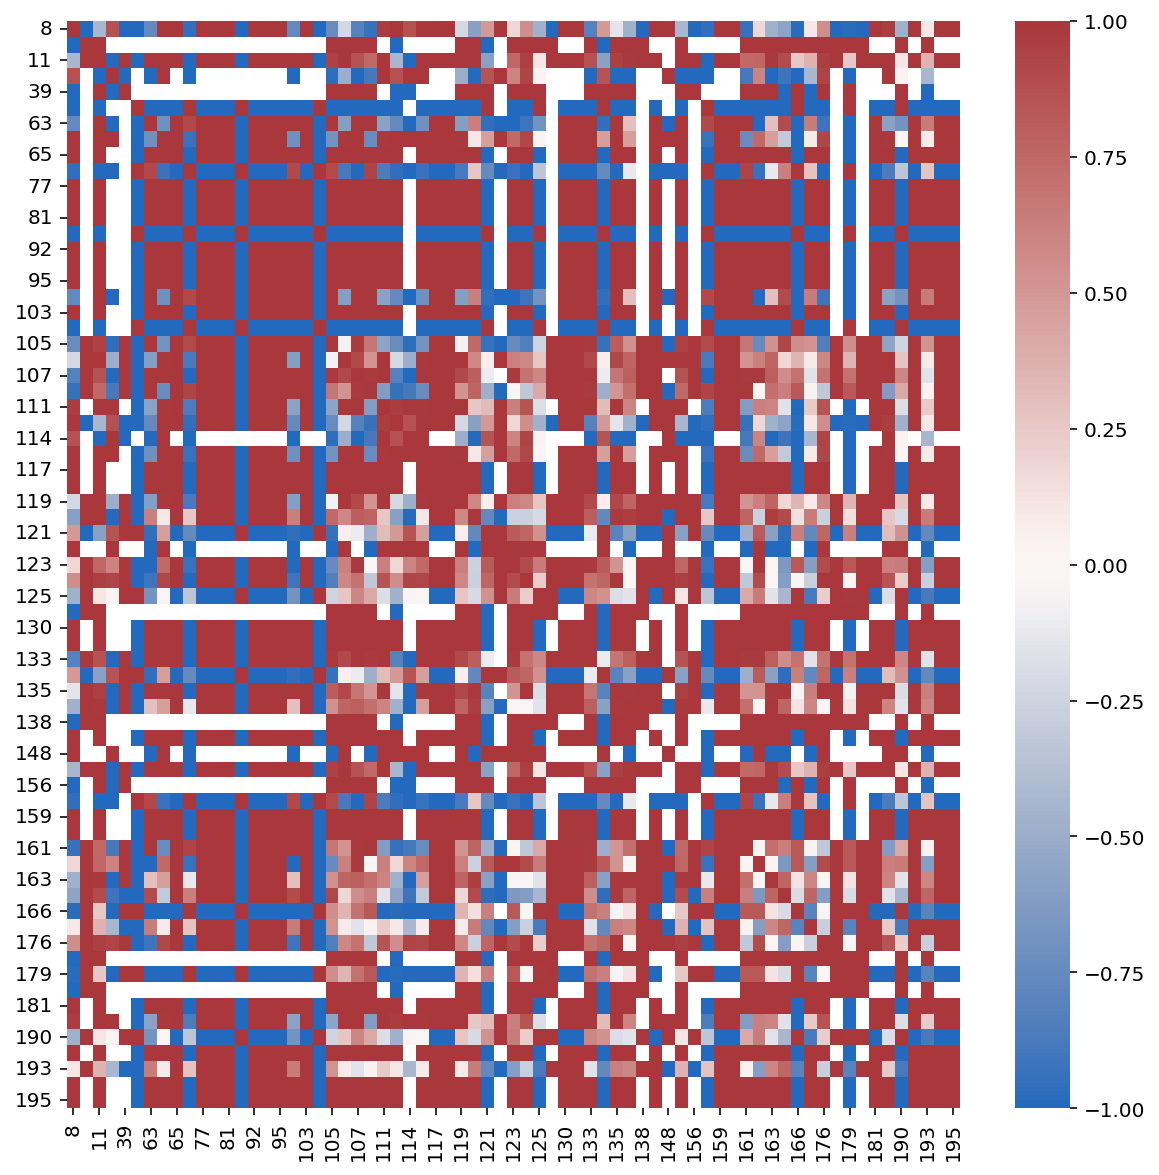

time: 998 ms (started: 2022-08-11 15:34:38 -05:00)


In [46]:
# interactions correlations
l_corr = []
for df in l_tile_heatmaps:
    l_corr.append(df.to_numpy().flatten().tolist())
df_corr = pd.DataFrame(l_corr)

corrMatrix = df_corr.corr().dropna(axis = 1, how = 'all').dropna(axis = 0, how  = 'all')
plt.figure(figsize = (10,10))
sns.heatmap(corrMatrix, cmap = 'vlag')
plt.savefig(logodds_dir + '/Correlation_Heatmap.pdf')

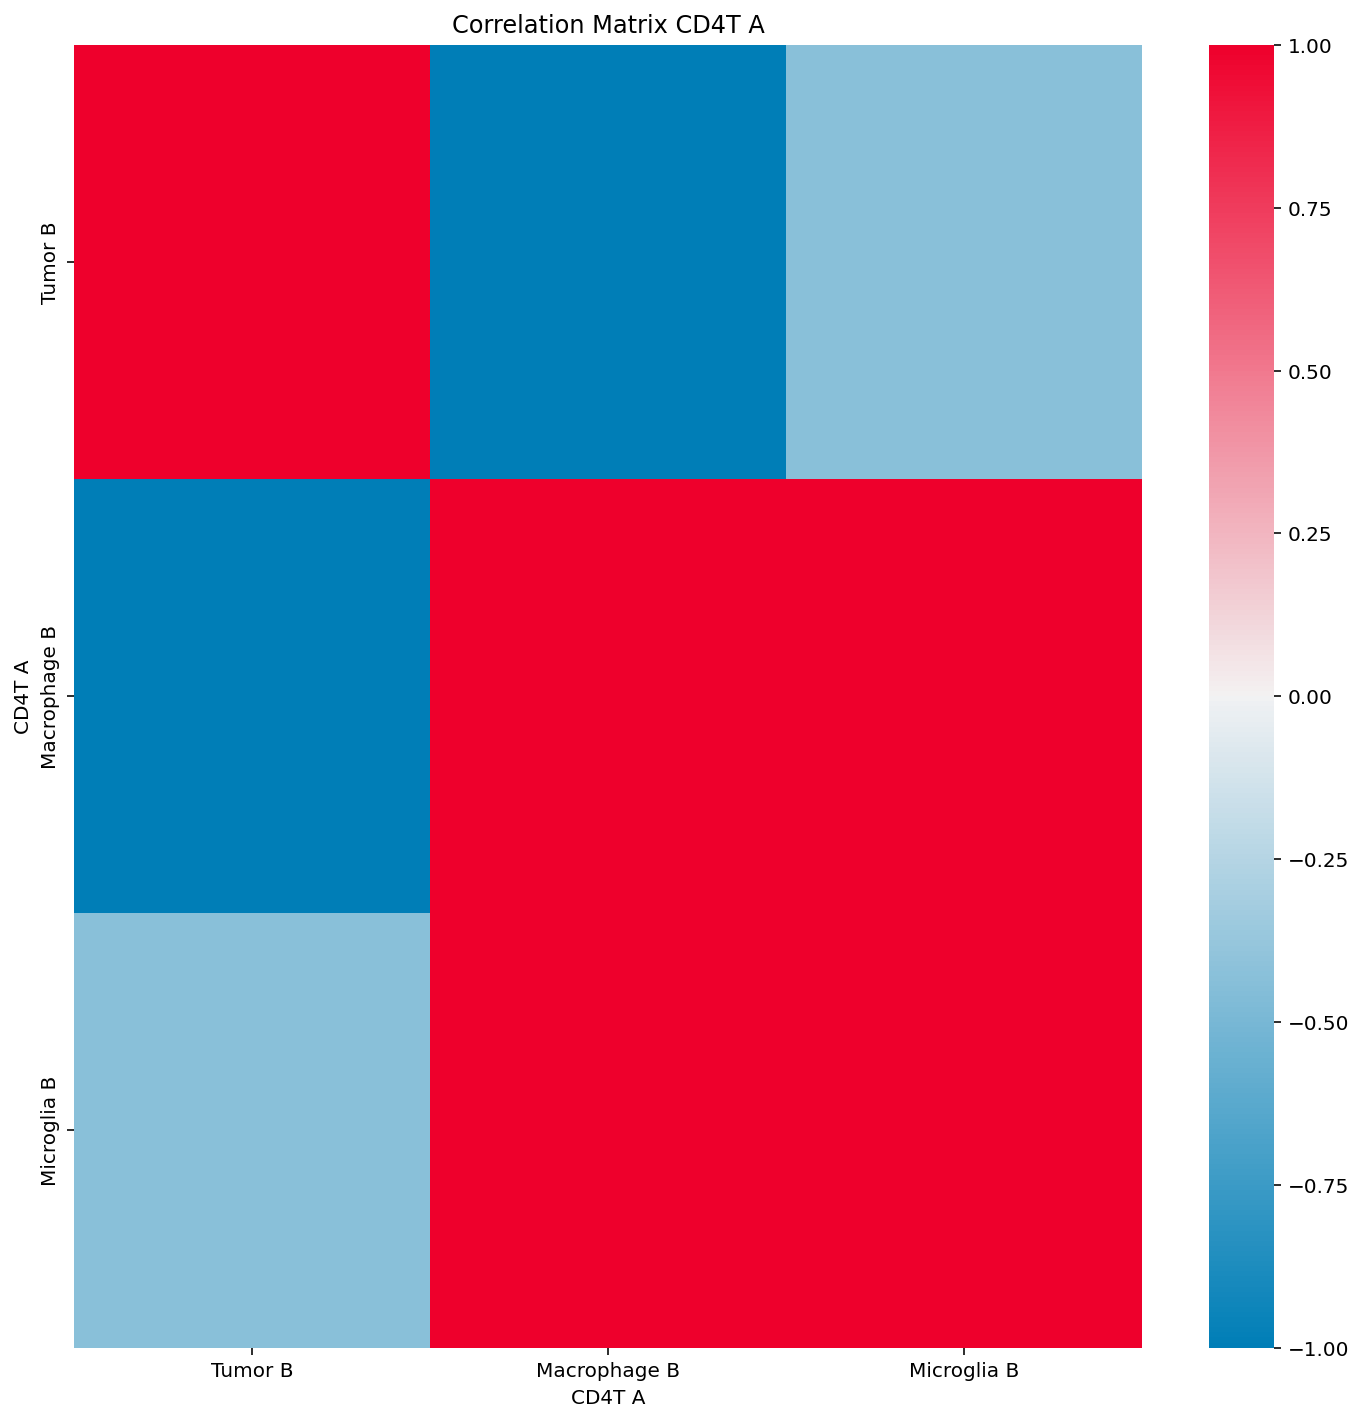

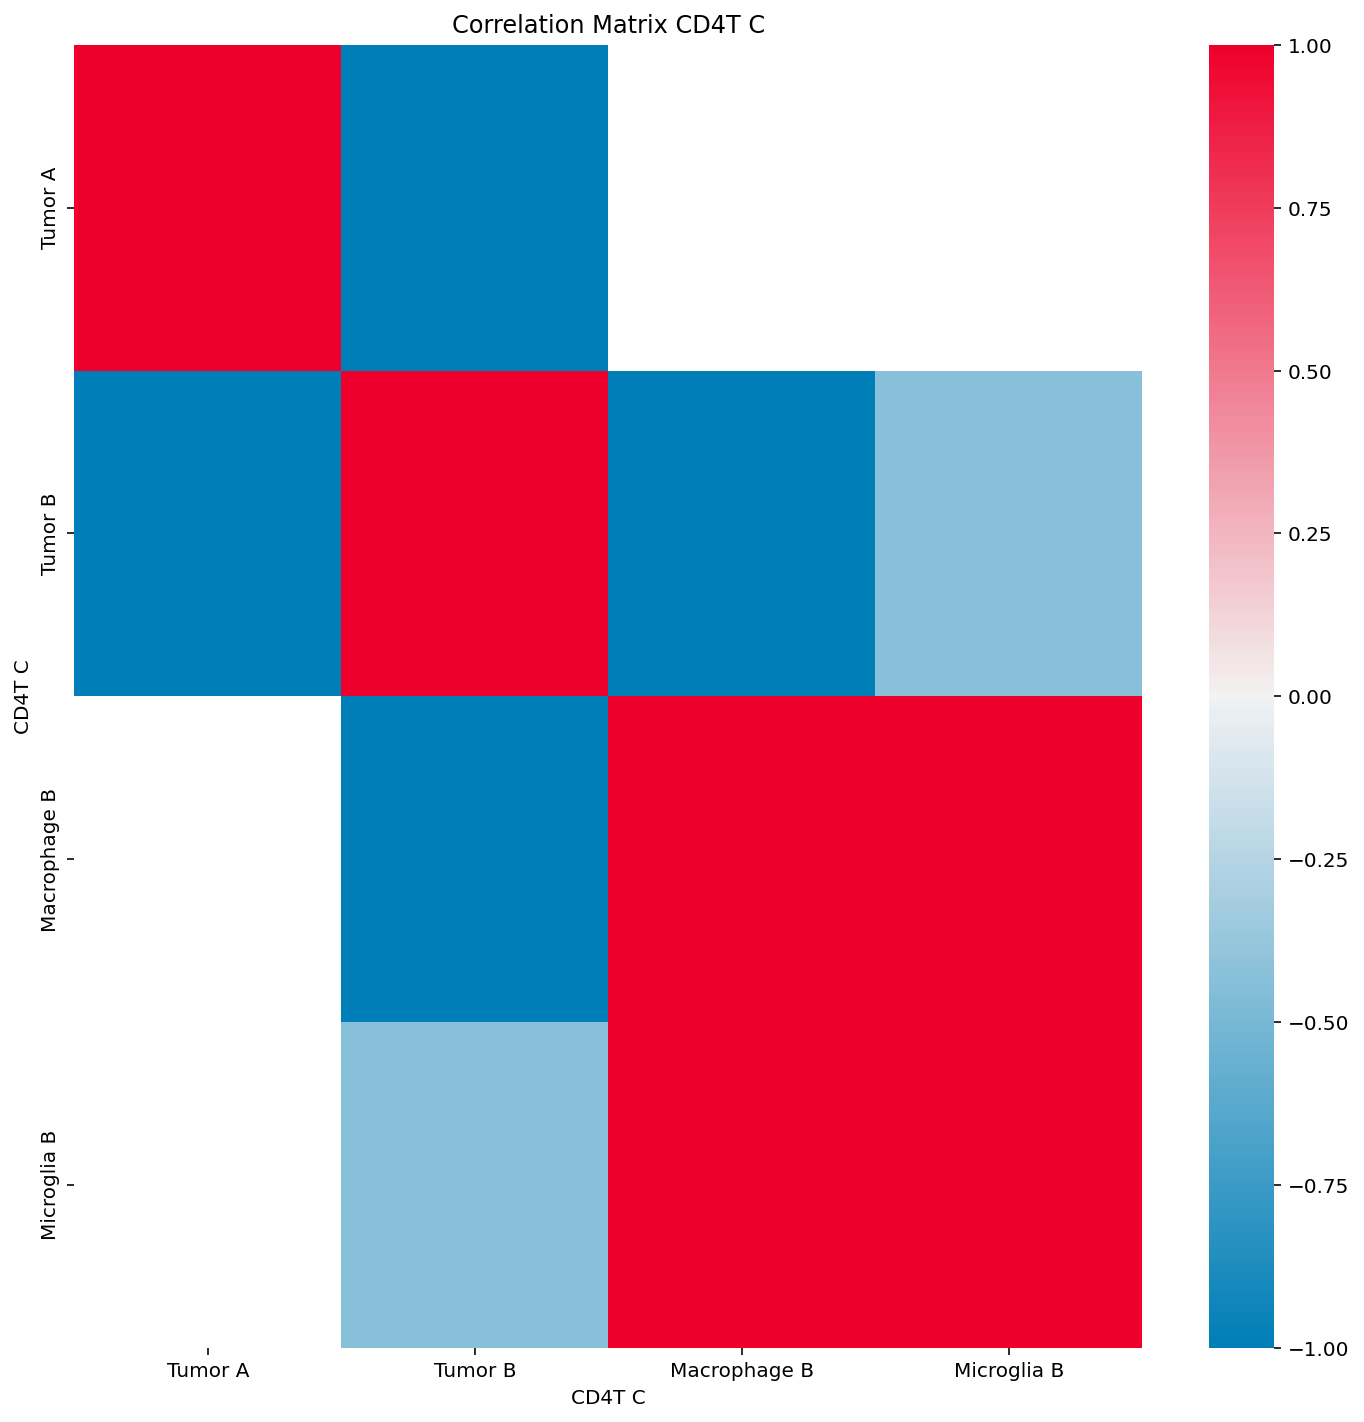

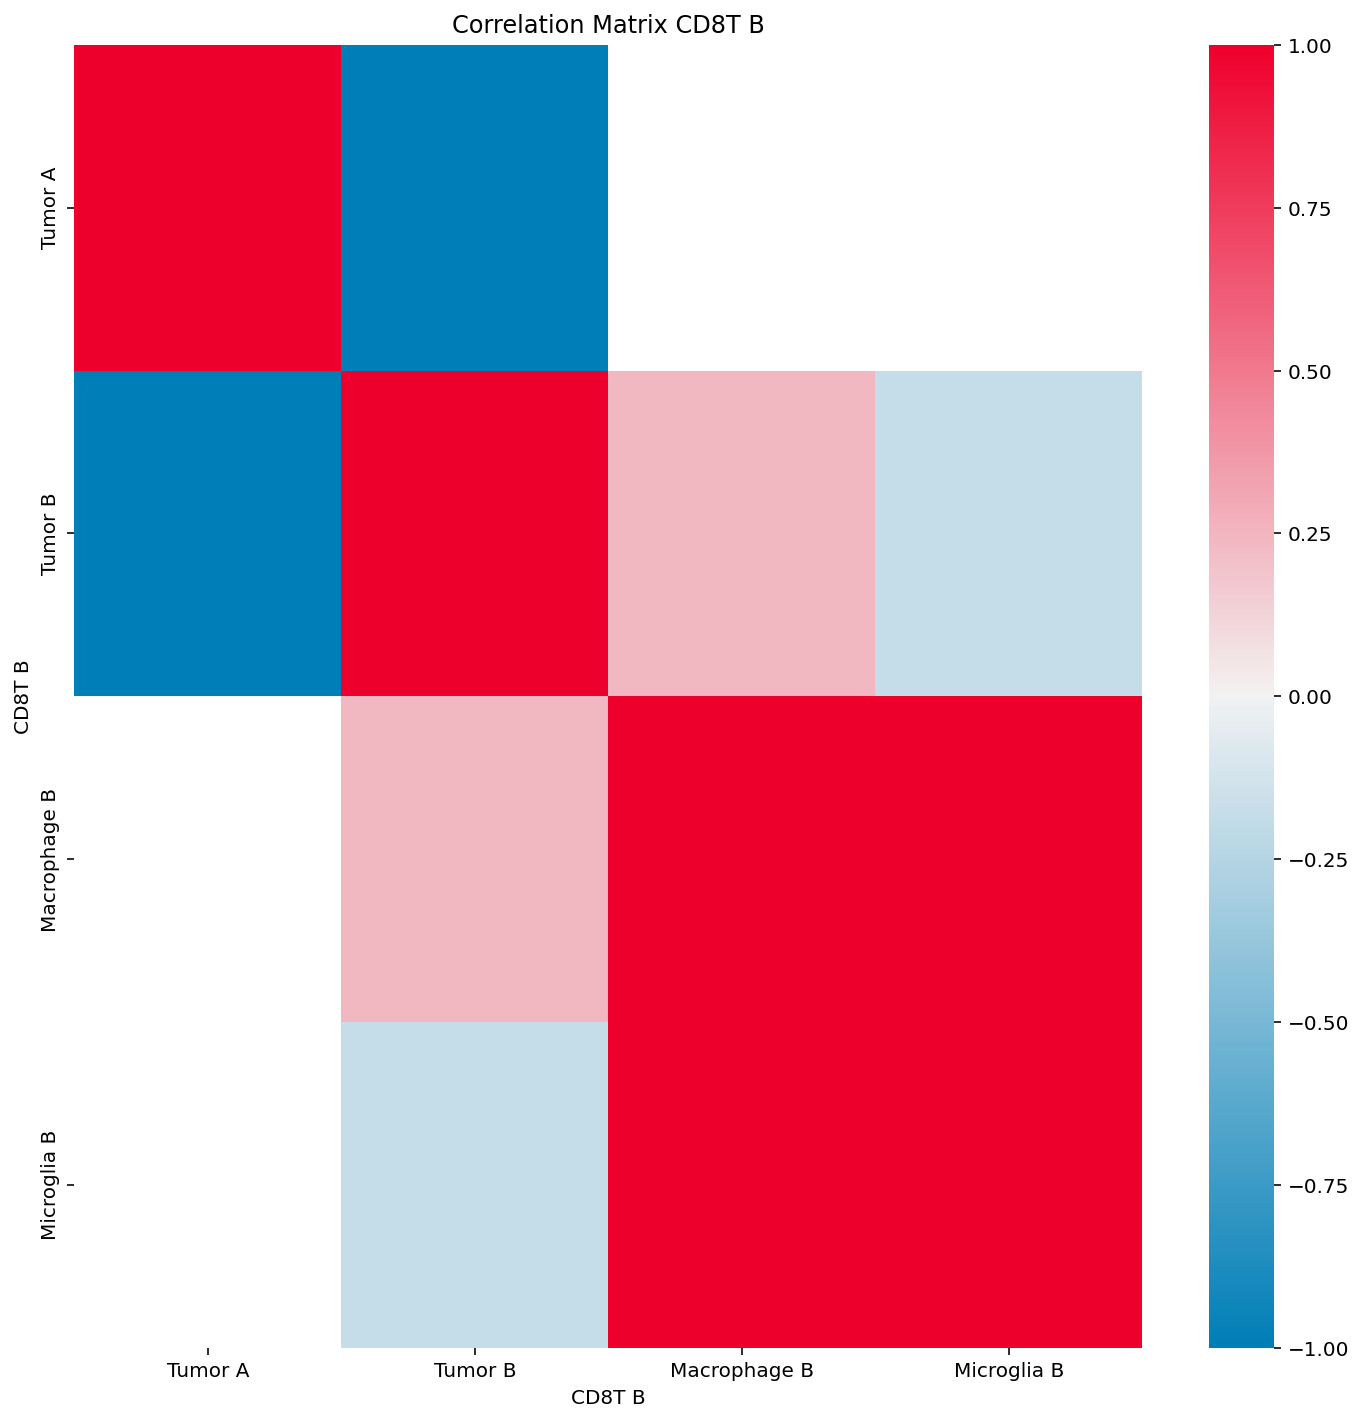

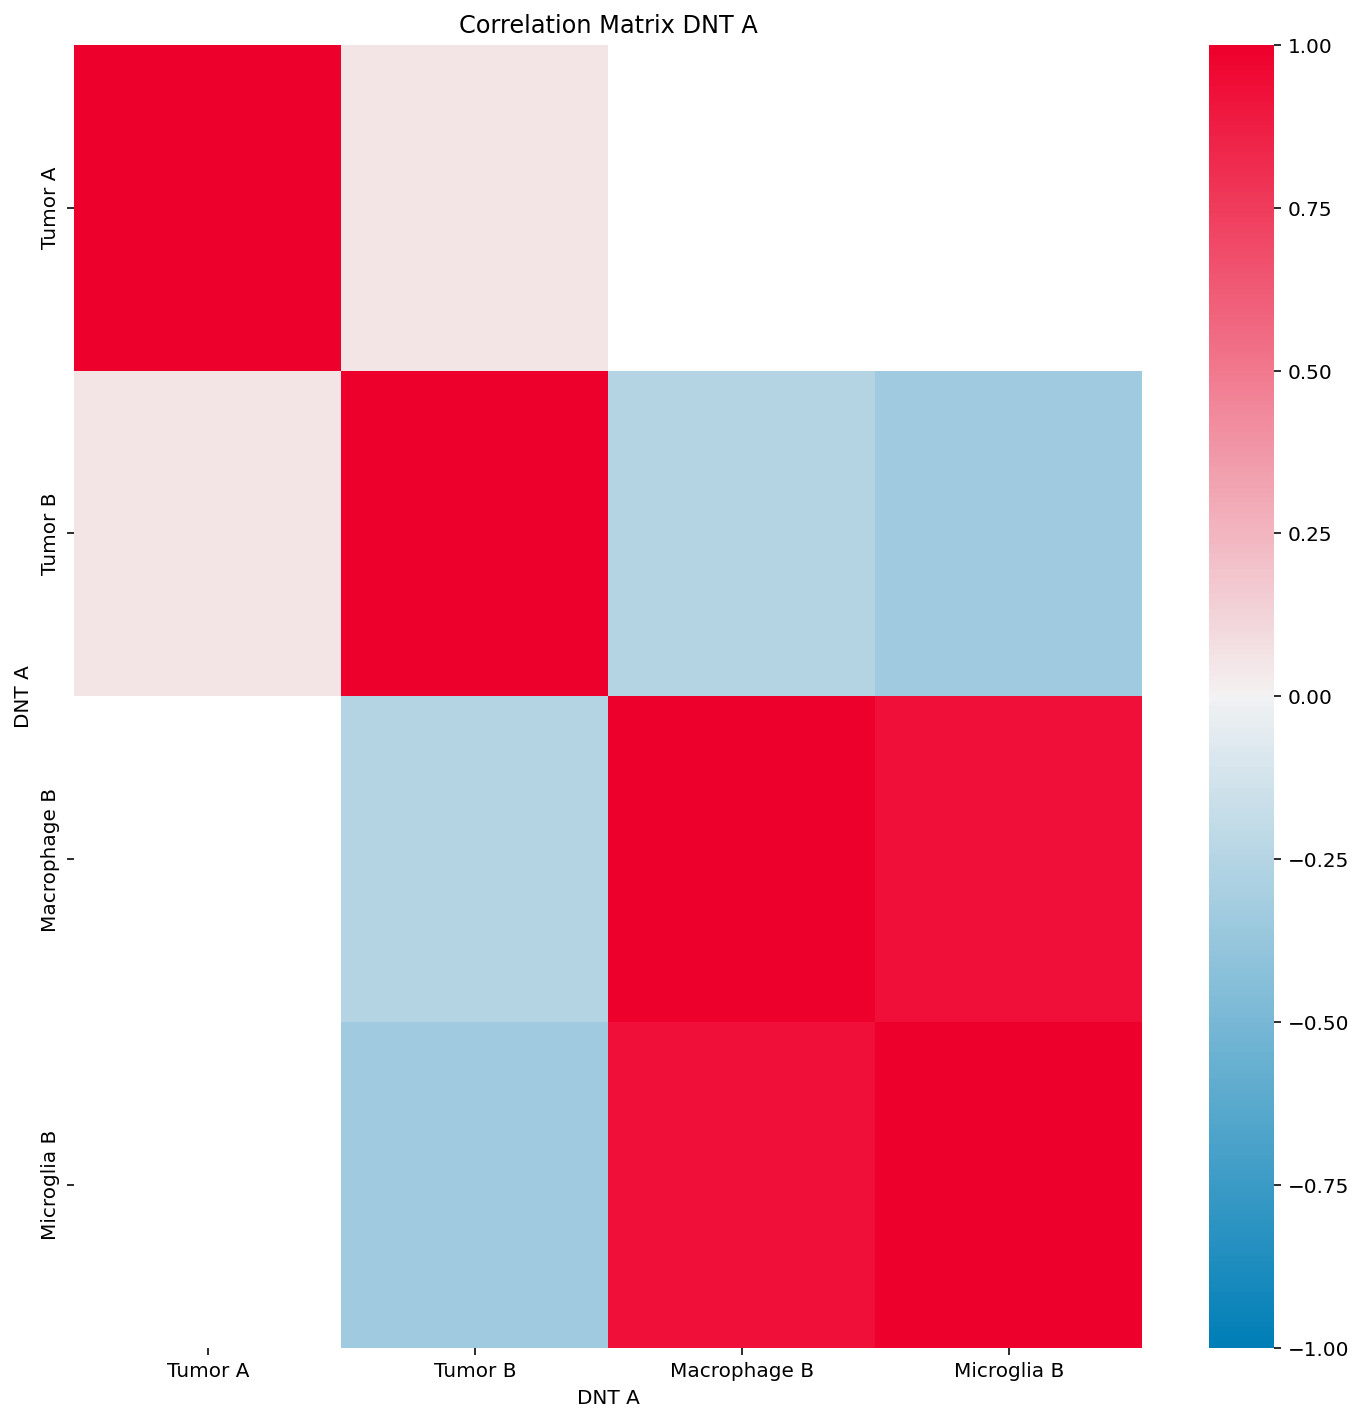

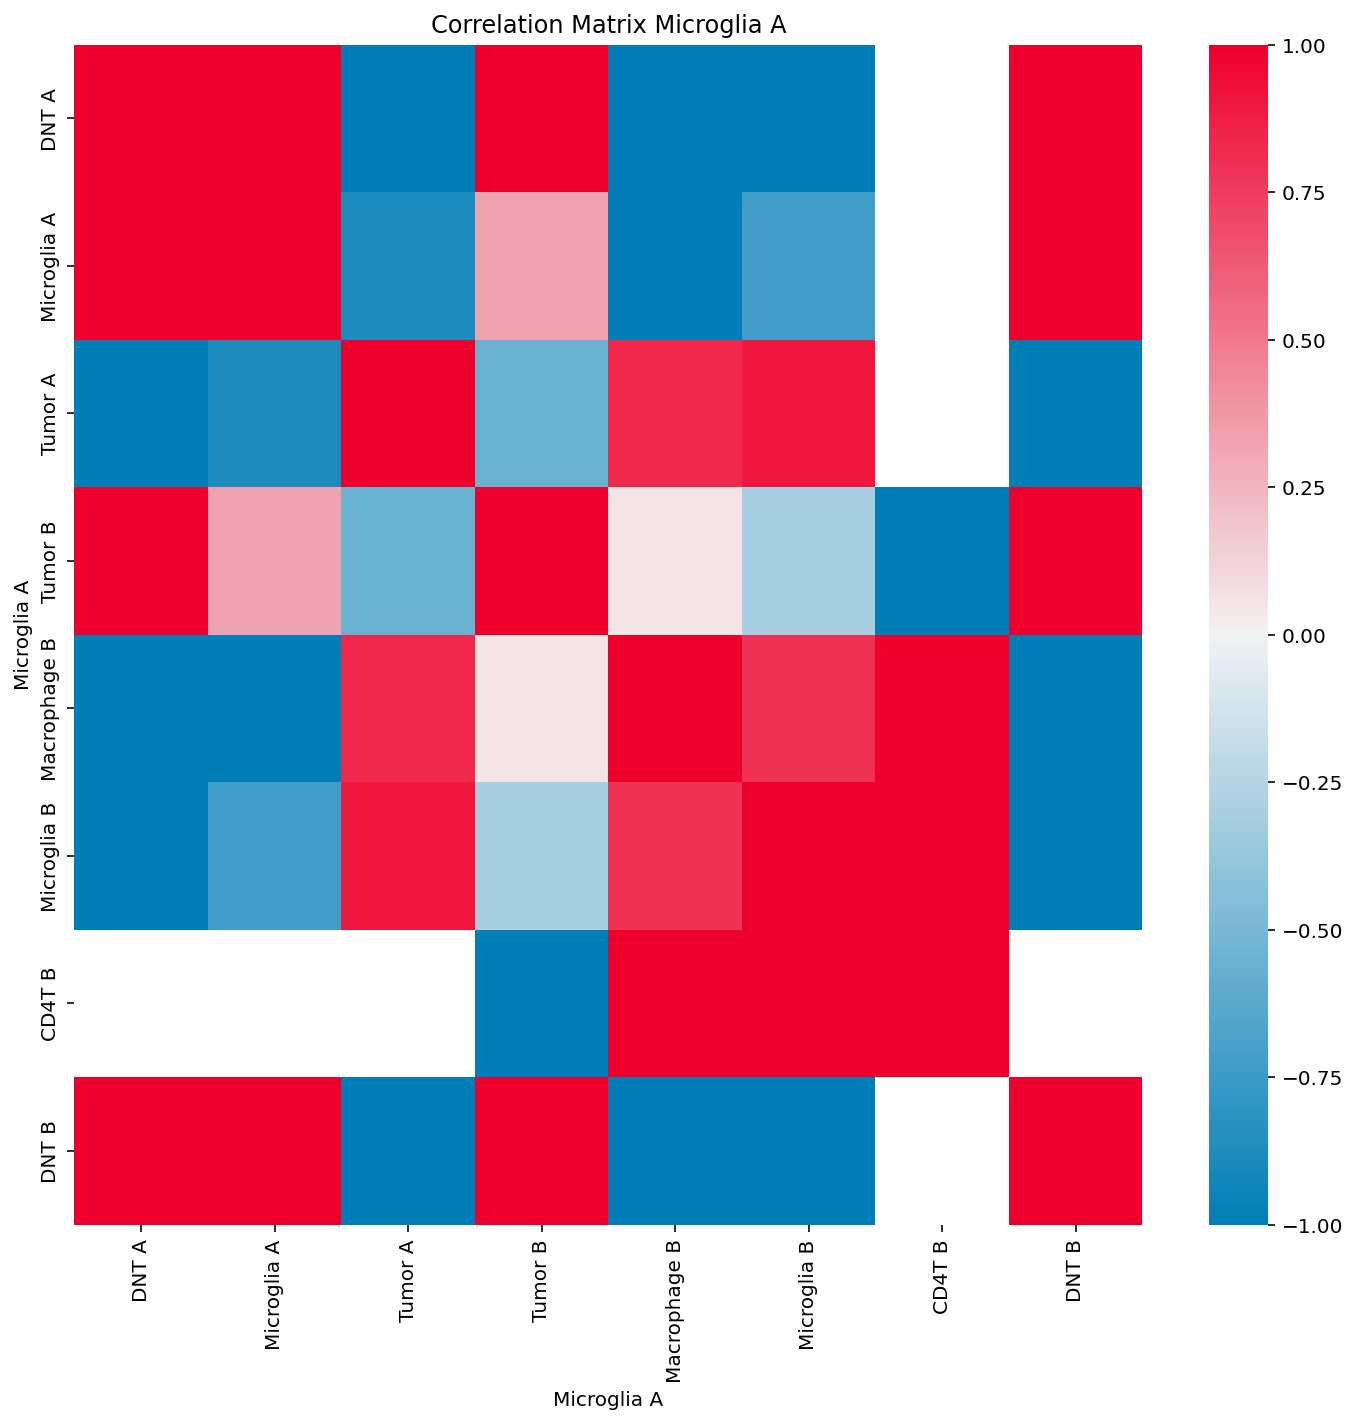

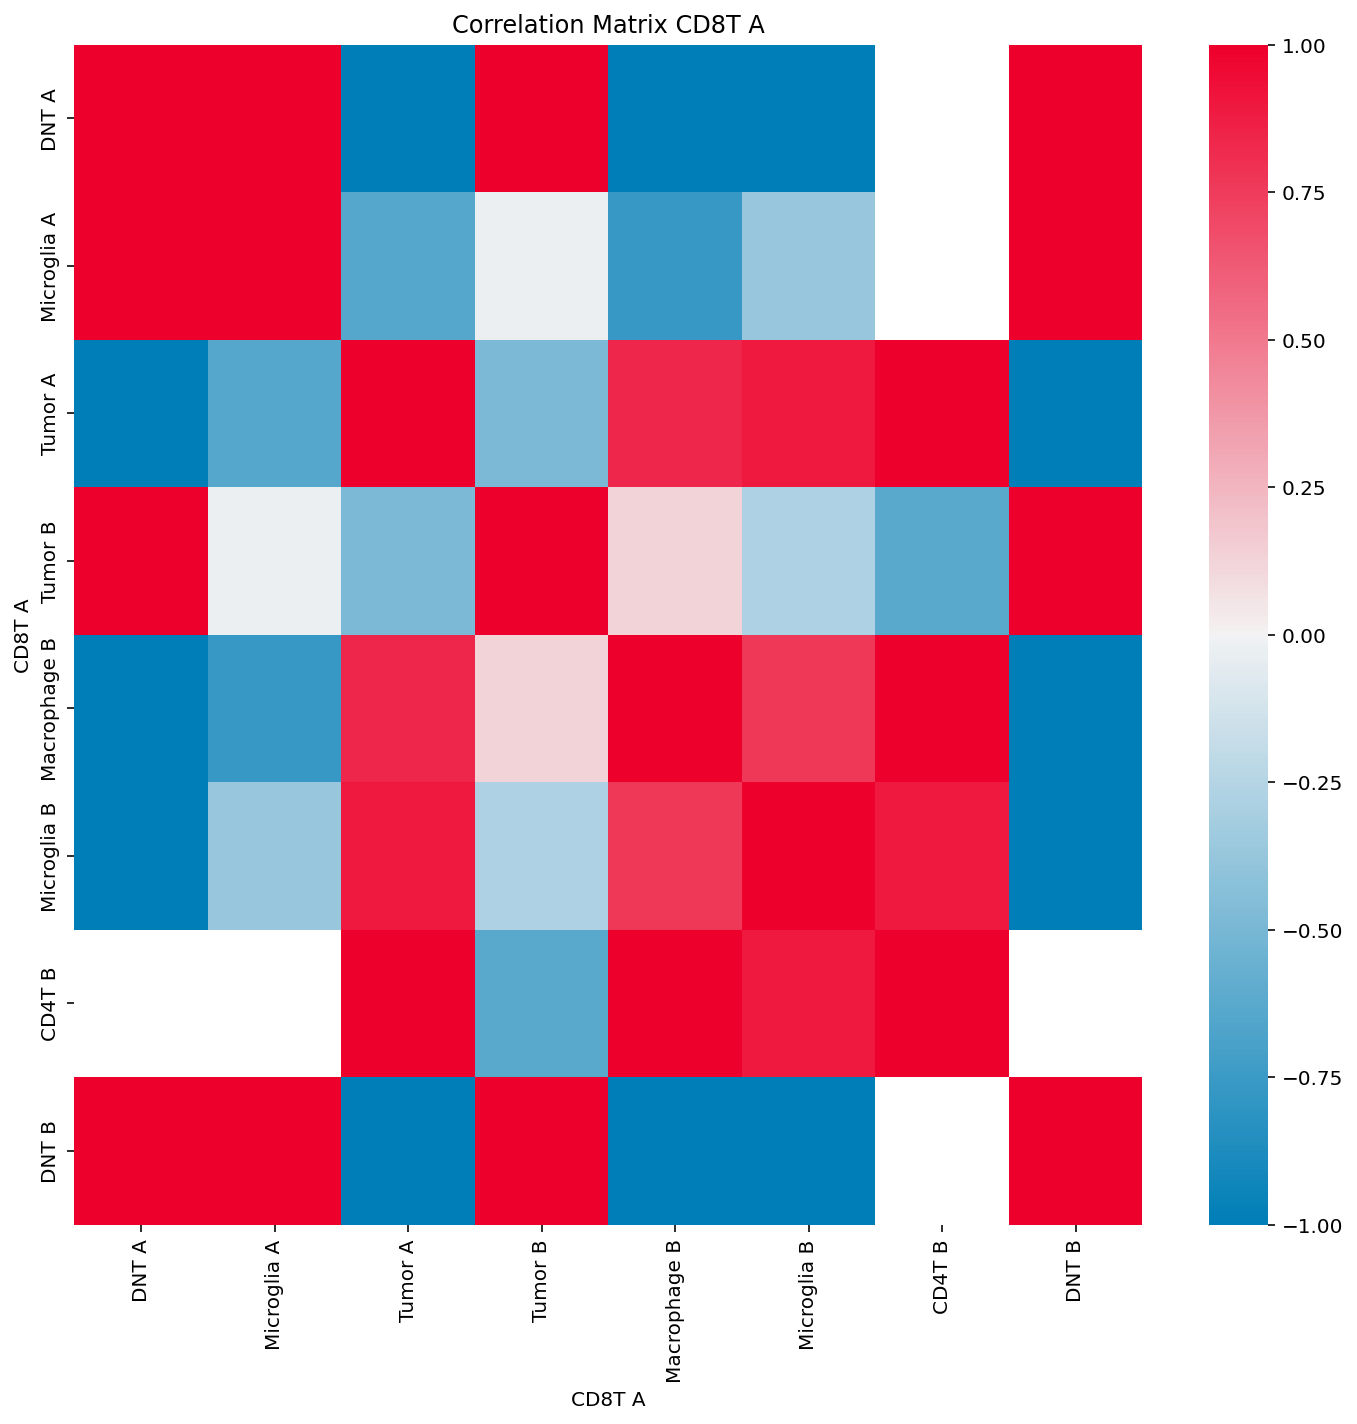

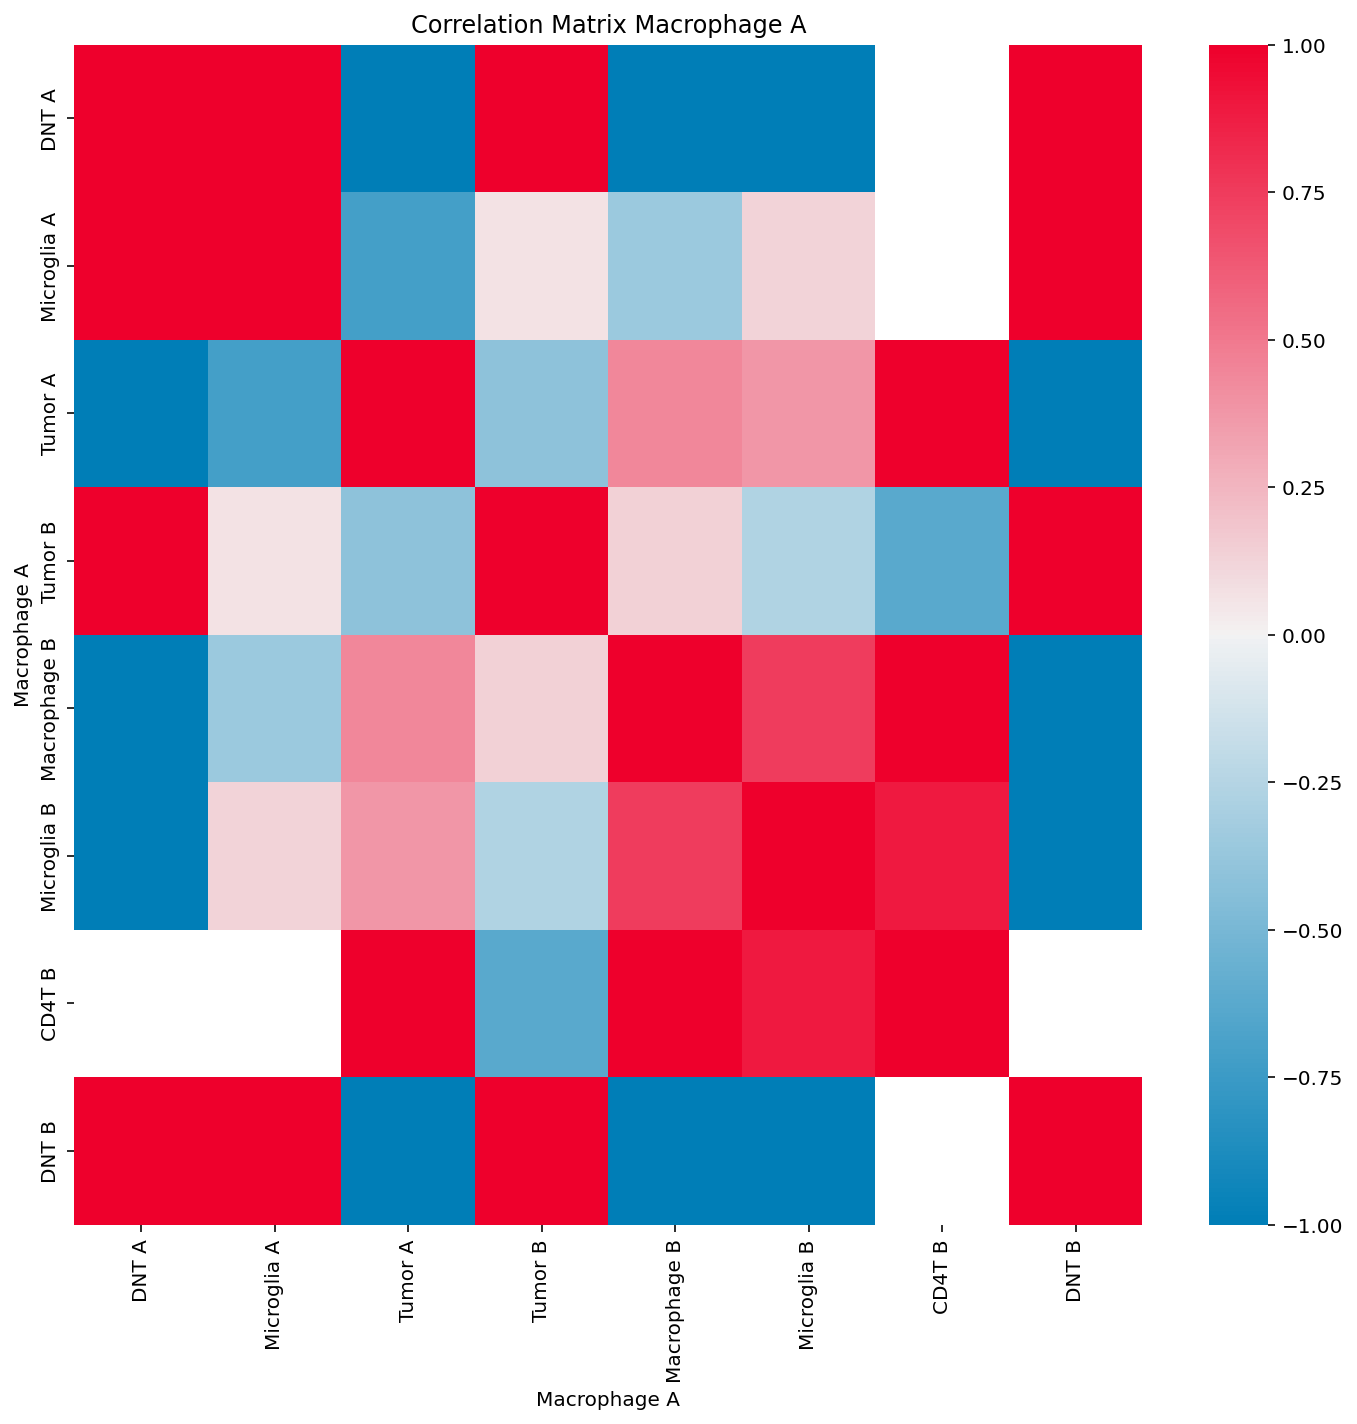

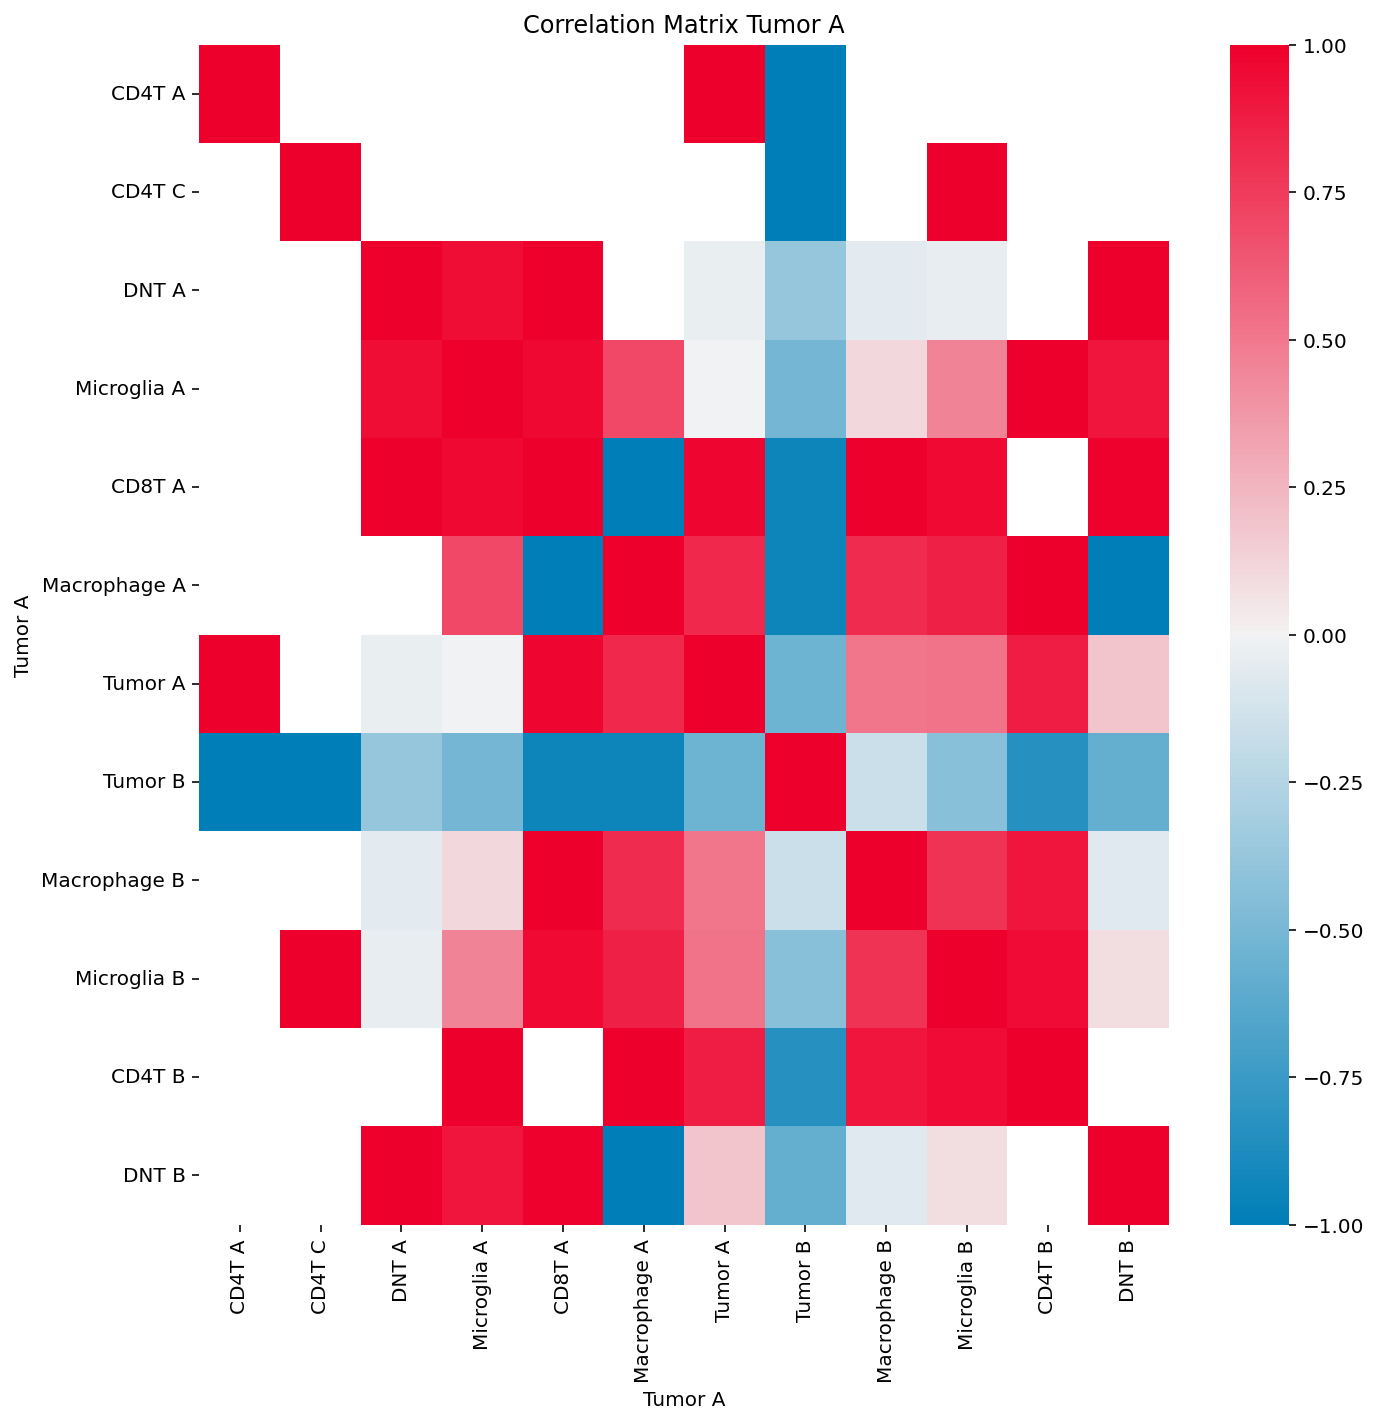

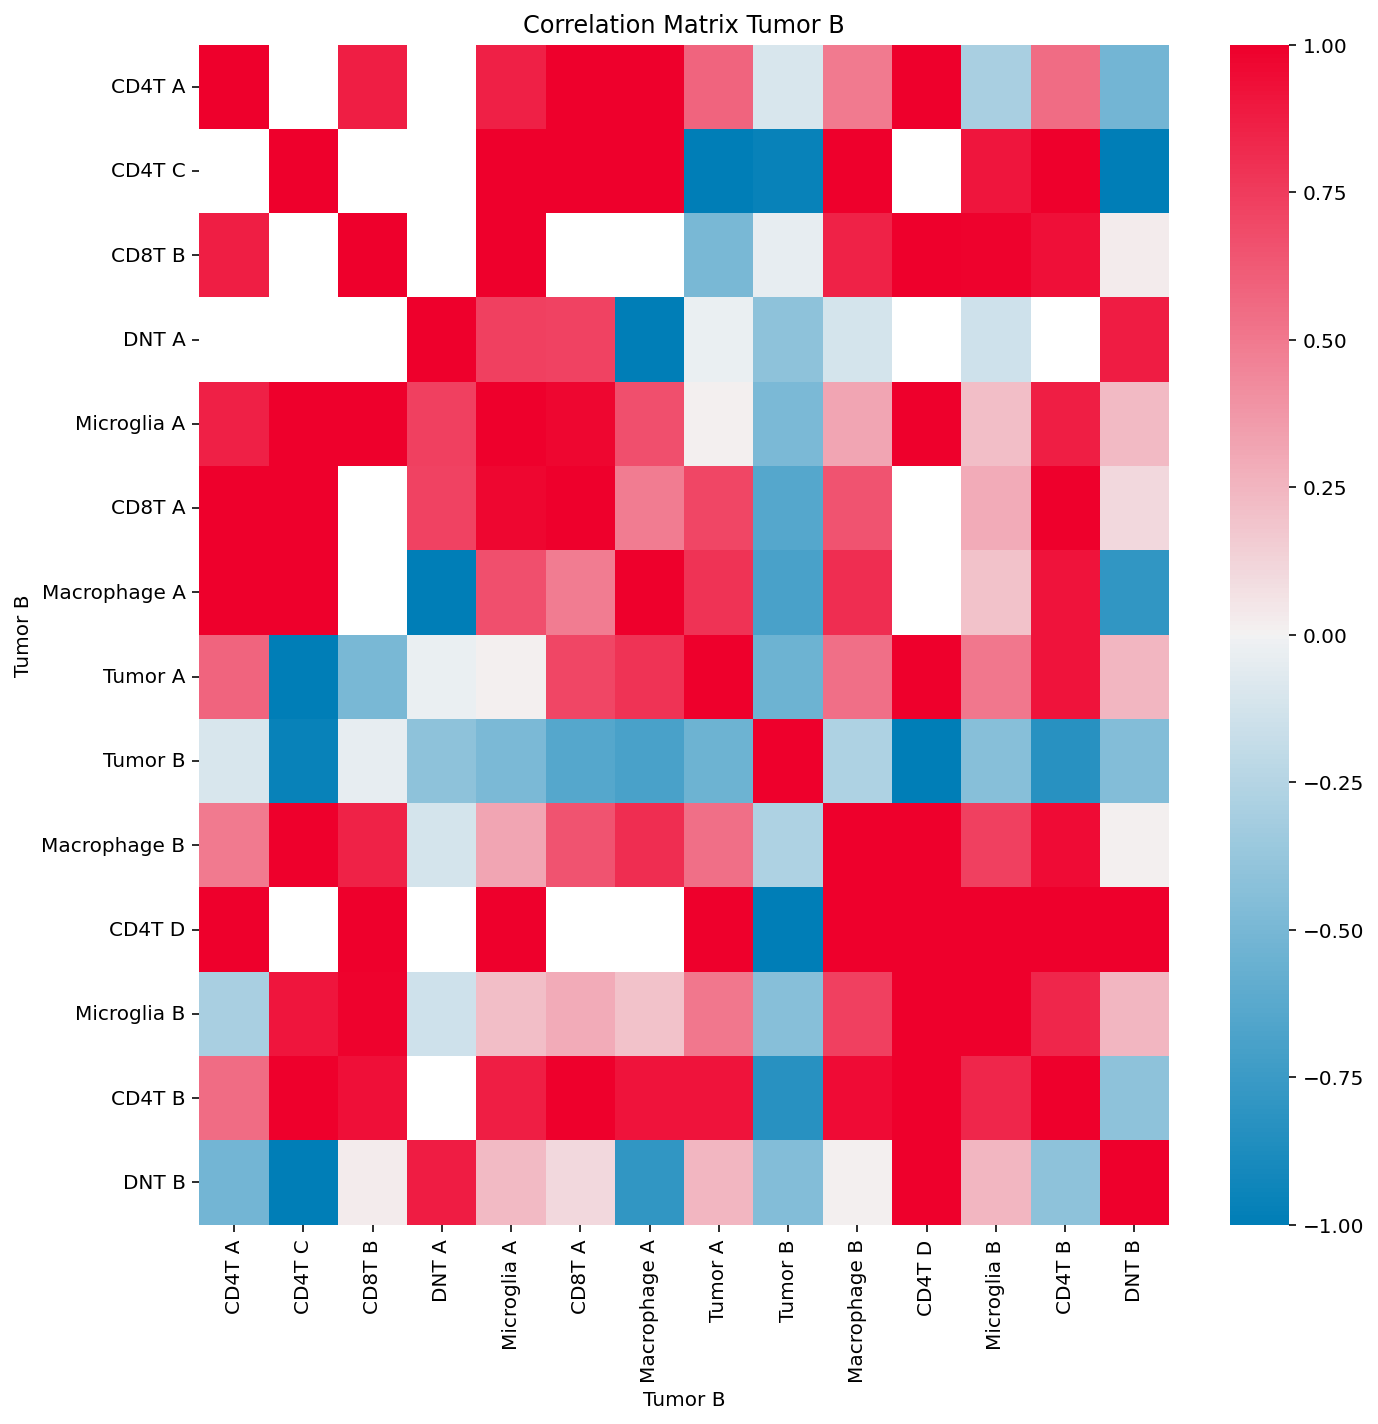

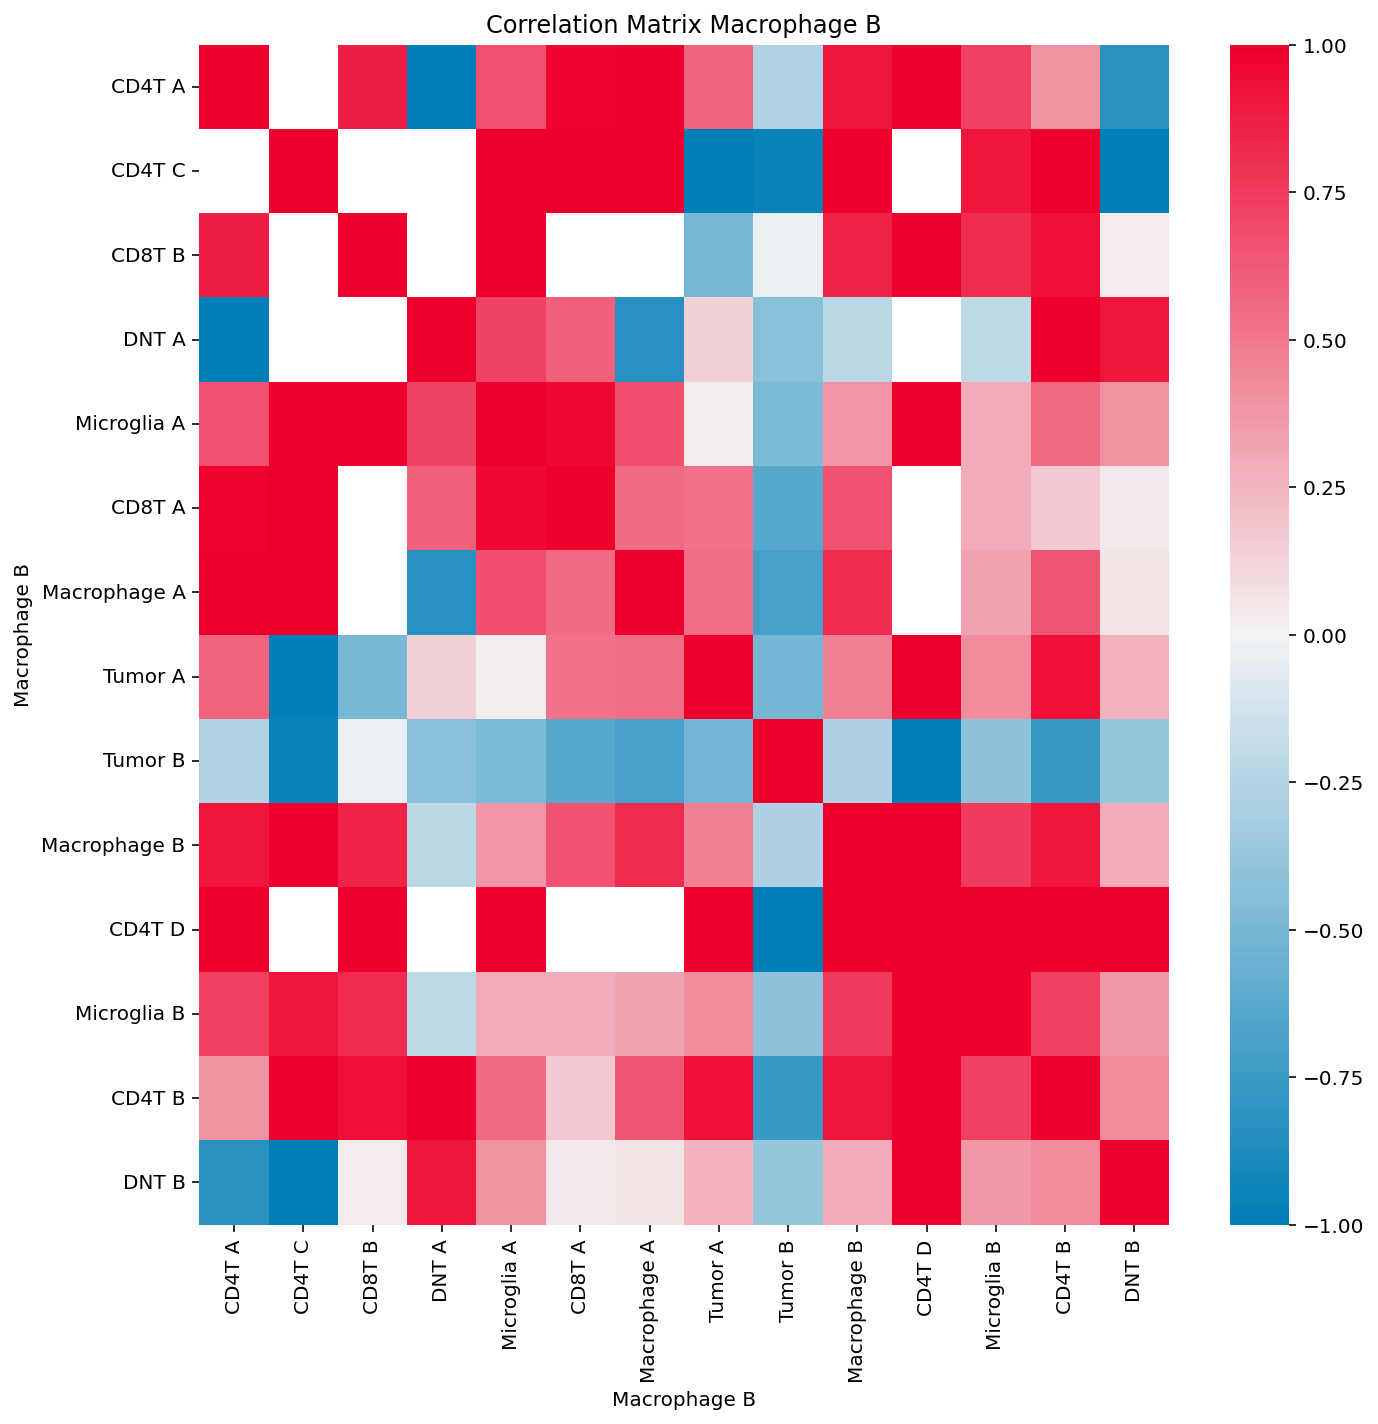

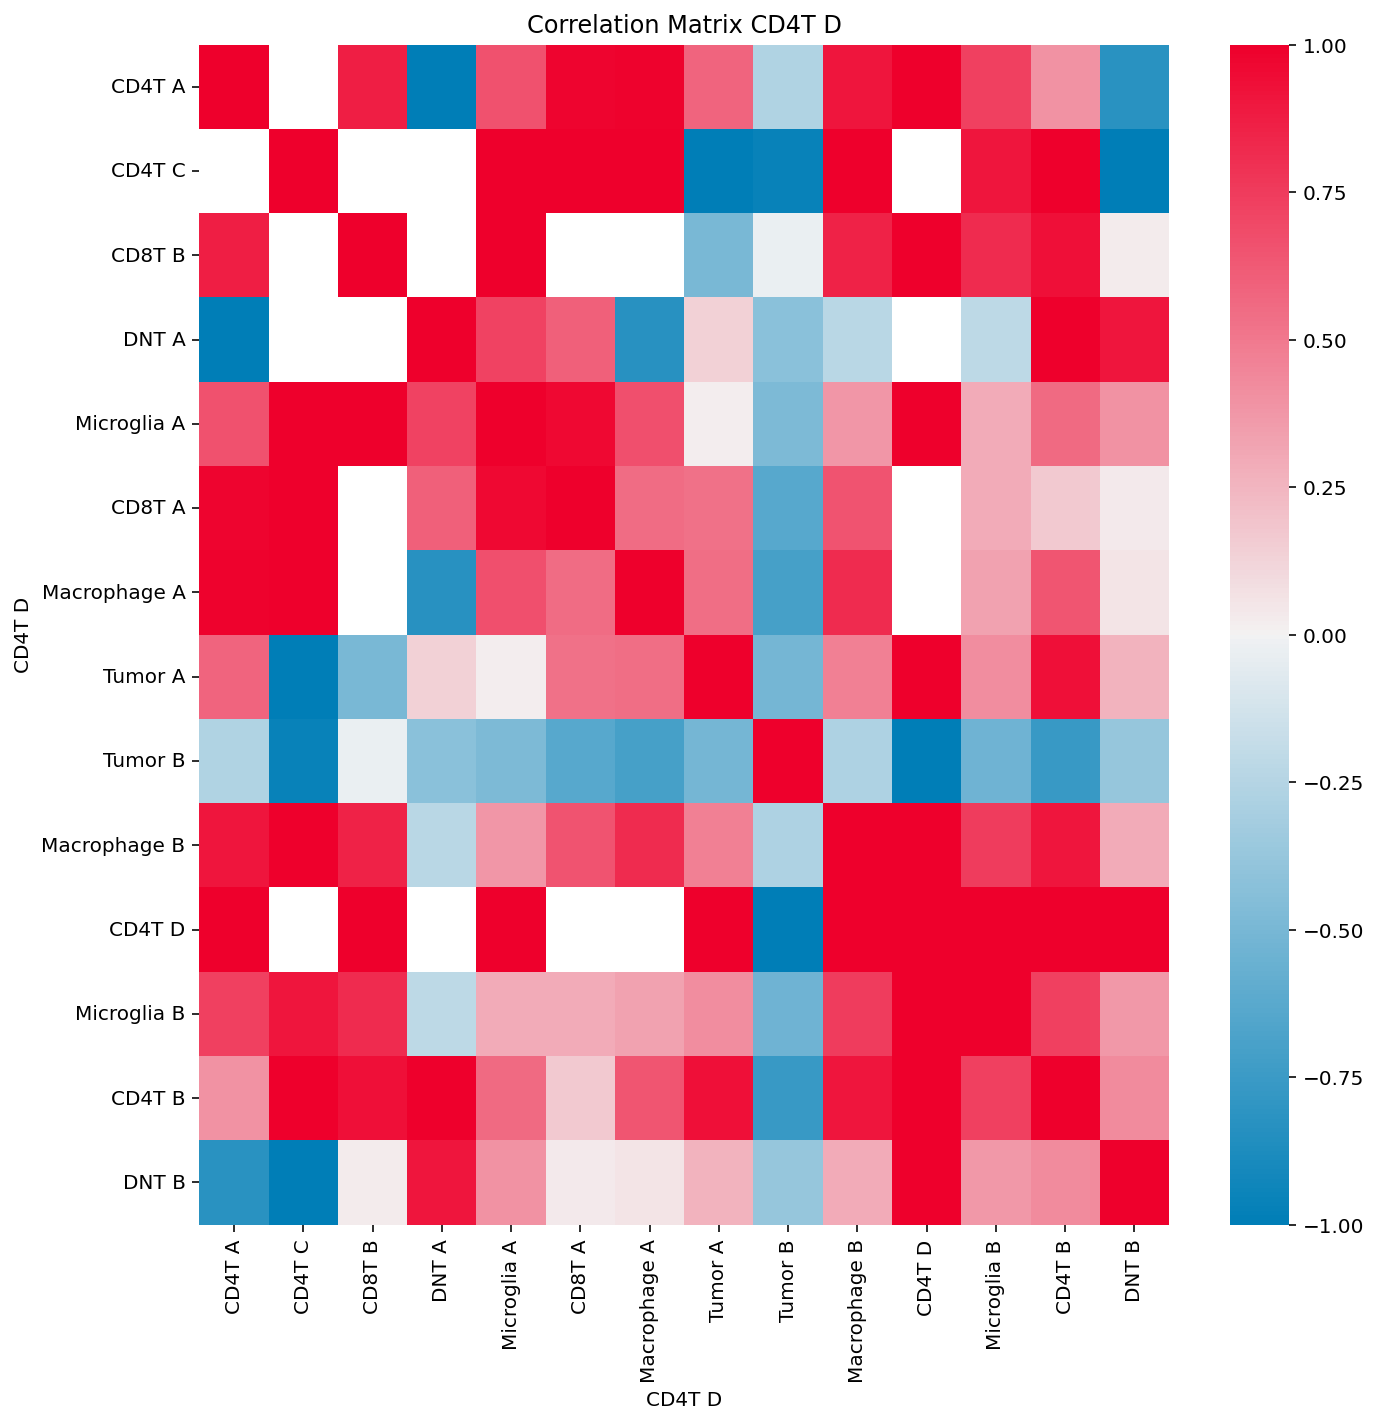

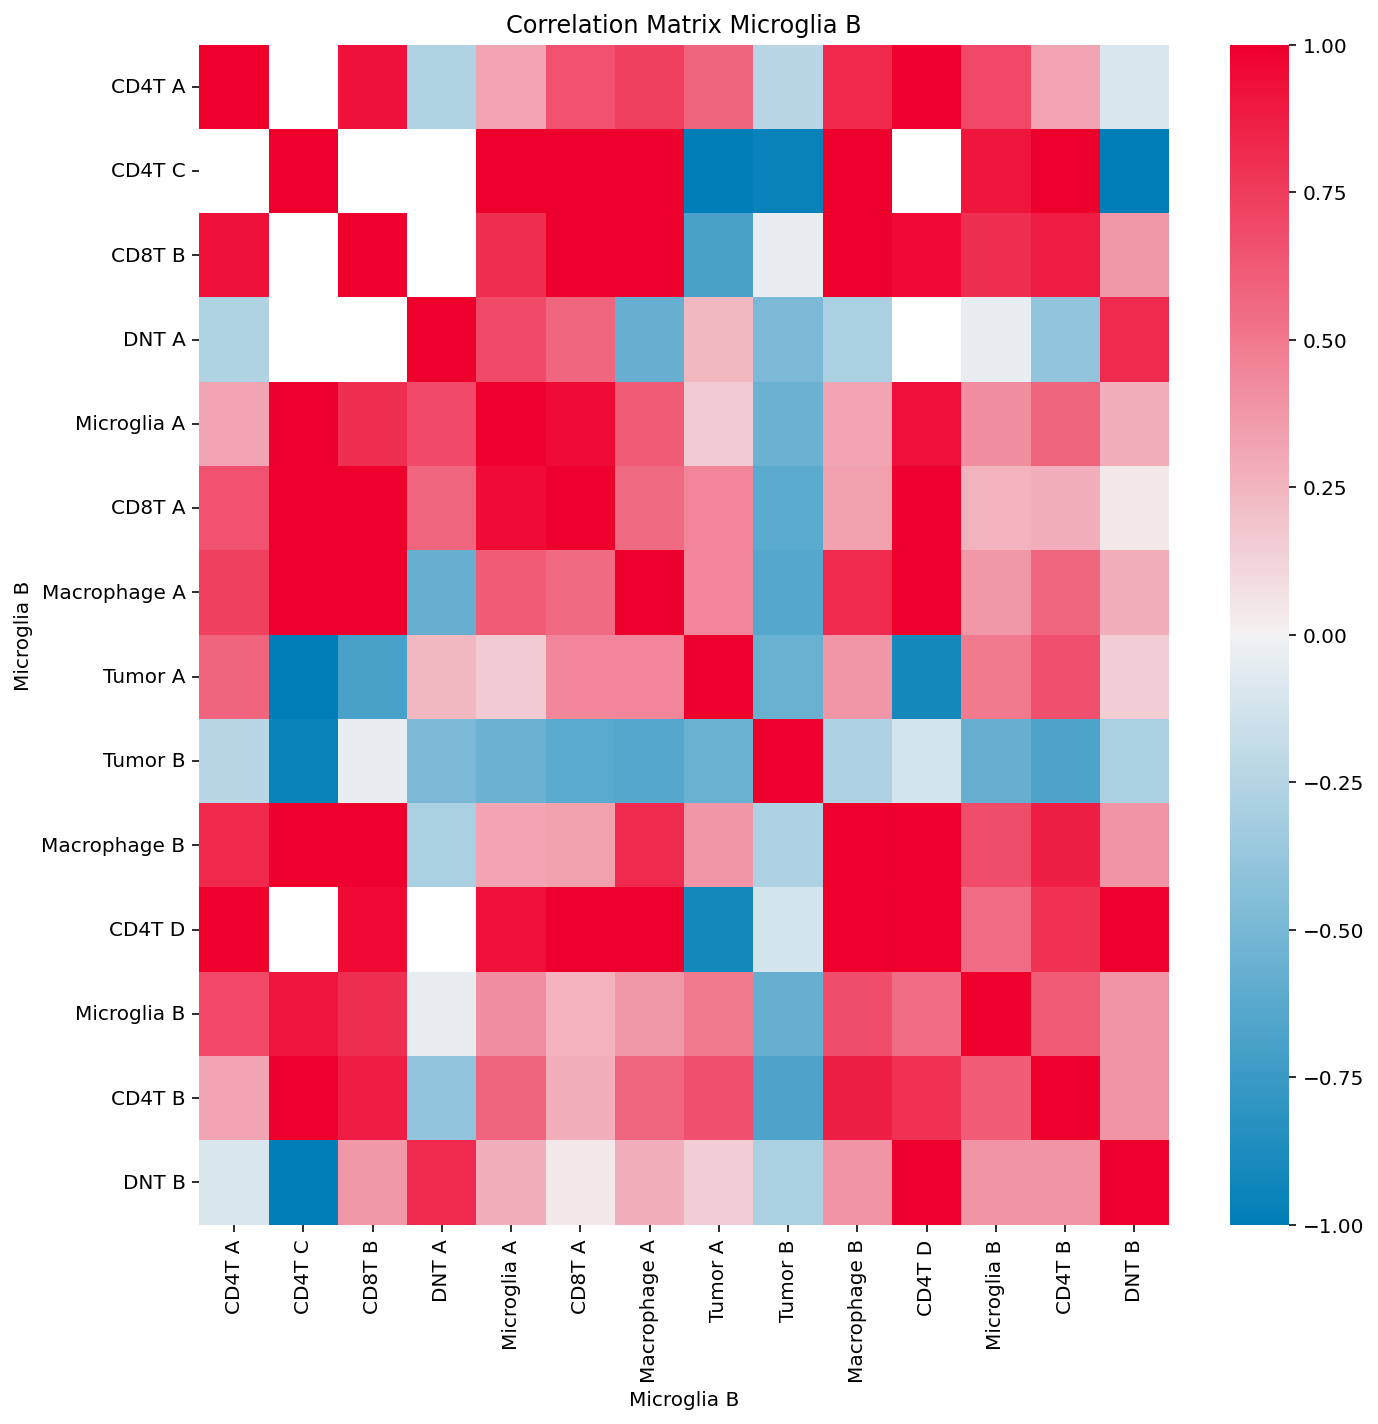

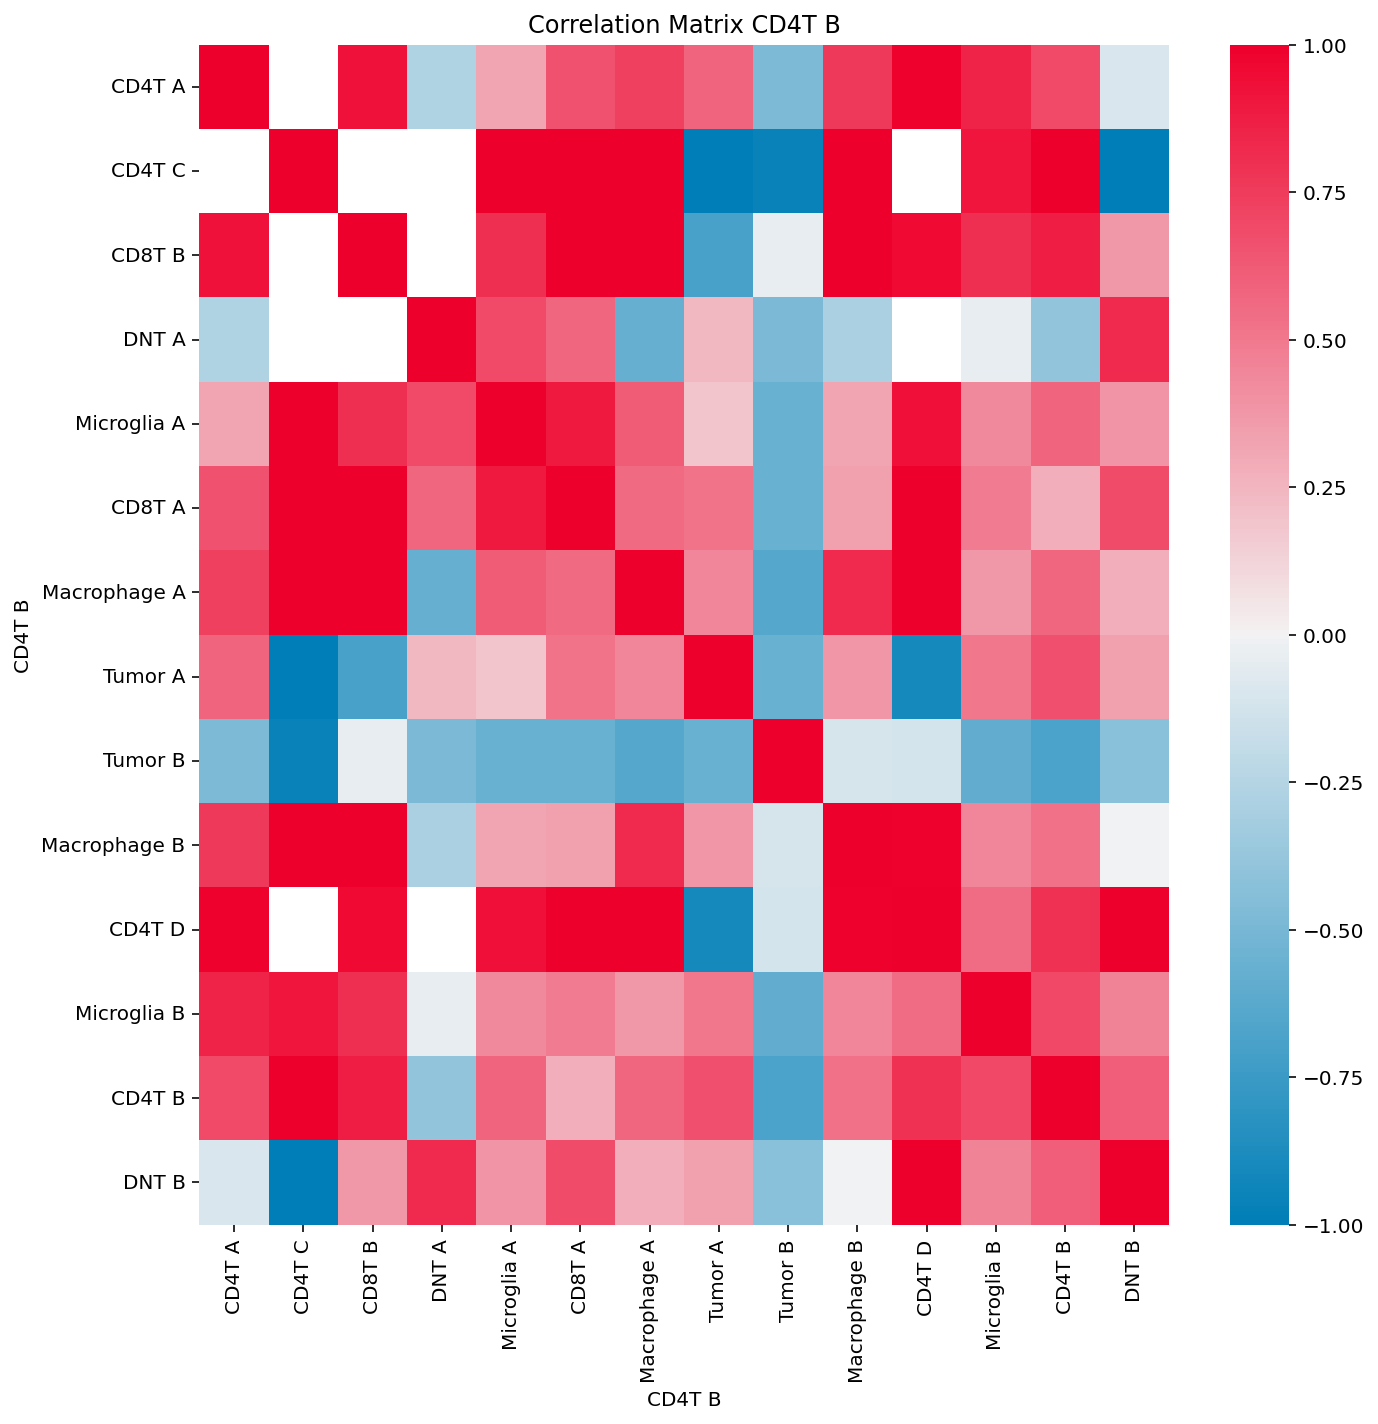

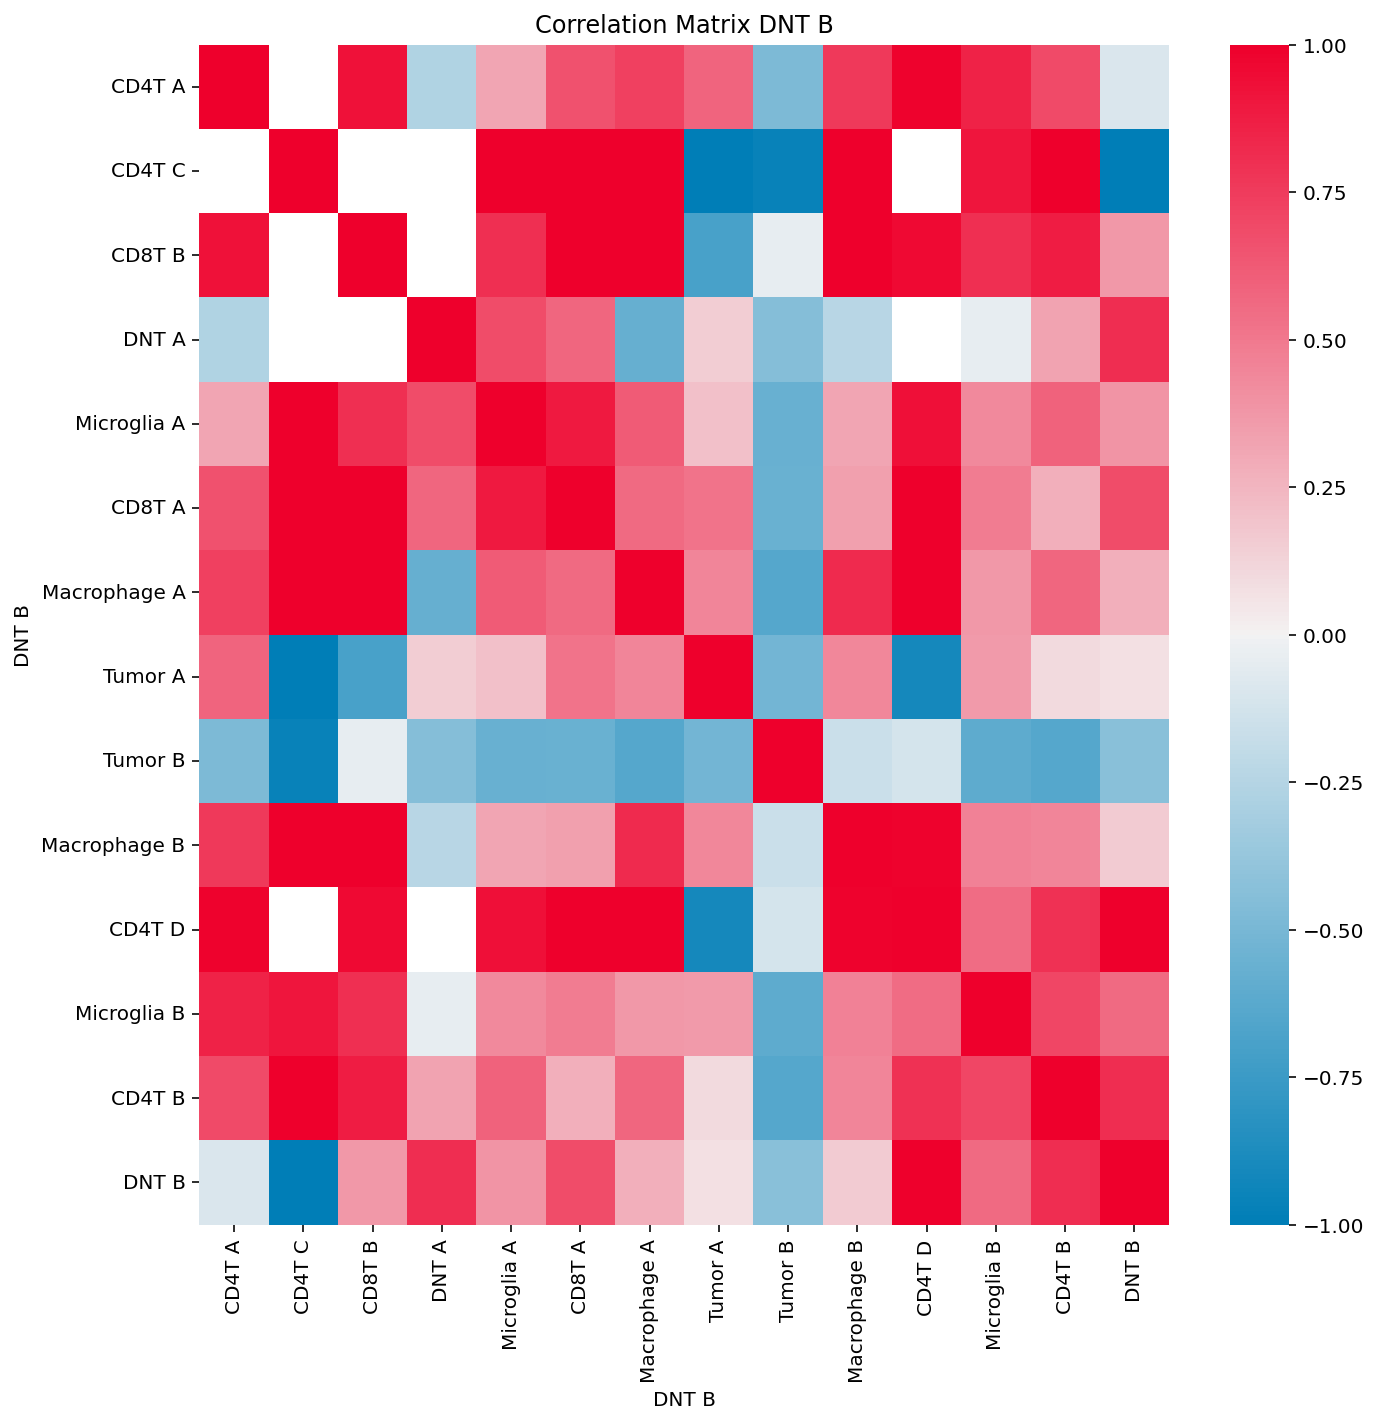

time: 4.79 s (started: 2022-08-11 15:34:39 -05:00)


In [47]:
l_corr = []
rdbl = sns.diverging_palette(240,10, n = 99, l = 50, s=100,as_cmap = True)
divnorm = mcolors.TwoSlopeNorm(vmin = -1, vcenter = 0, vmax = 1)
for i in range(len(l_pops)):
    for df in l_tile_heatmaps:
        l_corr.append(df.iloc[i])
    df_corr = pd.DataFrame(l_corr)

    corrMatrix = df_corr.corr().dropna(axis = 1, how = 'all').dropna(axis = 0, how  = 'all')
    plt.figure(figsize = (10,10))
    g = sns.heatmap(corrMatrix,cmap = rdbl, norm = divnorm)
    g.set_title('Correlation Matrix {}'.format(new_order[i]))
    g.set(xlabel = '{}'.format(new_order[i]), ylabel = '{}'.format(new_order[i]))
    plt.tight_layout()
    plt.savefig(logodds_dir + '/Correlation_Heatmap_{}.pdf'.format(new_order[i]))

### Log Odds on Specific Tile

In [48]:
# Enter Slide_ID, Row_ID, and Col_ID of specific tile in the format: ['Slide_ID', 'Row_ID', 'Col_ID']
tile_id = ['N14-248-1B', '10', '3']

for l in l_interactions_tile:
    _, slide, row, col = os.path.splitext(os.path.basename(l))[0].split('_')
    r = row[1:]
    c = col[1:]
                                     
    if [slide, r, c ] == tile_id:
        interactions = pd.read_csv(l)
        halfheatmap = interactions[['popA', 'popB', 'log_odds_ratio']]
        halfheatmap2 = halfheatmap.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
        full_heatmap = pd.concat([halfheatmap, halfheatmap2]).drop_duplicates()
        heatmap2 = full_heatmap.pivot('popA', 'popB', 'log_odds_ratio')
        heatmap3 = heatmap2.reindex(index = new_order, columns = new_order)

        count_inter = interactions[['popA', 'popB', 'interaction_counts']]
        count_inter2 = count_inter.rename(columns = {'popA' : 'popB', 'popB' : 'popA'})
        full_count_inter = pd.concat([count_inter, count_inter2]).drop_duplicates()
        count_inter_heatmap = full_count_inter.pivot('popA', 'popB', 'interaction_counts')
        count_inter_heatmap = count_inter_heatmap.reindex(index = new_order, columns = new_order)
        
        rdbl = sns.diverging_palette(240,10, n = 99, l = 50, s=100,as_cmap = True)
        divnorm = mcolors.TwoSlopeNorm(vmin = -2, vcenter = 0, vmax = 6)
        plt.figure(figsize = (5,5))
        g = sns.heatmap(heatmap3.fillna(0), square = True, cmap = rdbl, norm = divnorm, cbar = False).set_title('Log Odds Ratio of Population Interactions {}'.format(os.path.basename(l)[13:-4]))
        plt.savefig(logodds_dir + '/Log_Odds_Ratio_clustergram_{}.pdf'.format(os.path.splitext(os.path.basename(l))[0]))


time: 749 µs (started: 2022-08-11 15:34:44 -05:00)


## Neighborhood Analysis

In [49]:
# combine all niche csvs.  Add global-x, global-y coordinates
l_niche = []
for root, dirs, files in os.walk(neighbor_csv_dir):
    for i in files:
        if i.endswith('.csv'):
            l_niche.append(os.path.join(root, i))
l_niche = sorted(l_niche)

time: 13.8 ms (started: 2022-08-11 15:34:44 -05:00)


In [50]:
#Full Dataset neighborhood and feature data
frames = []
for i in l_niche:
    k = pd.read_csv(i)
    frames.append(k)

df_full_dataset = pd.concat(frames)

time: 43.3 ms (started: 2022-08-11 15:34:44 -05:00)


In [51]:
# rigged for single slide
slide_id = l_slides[0]

time: 207 µs (started: 2022-08-11 15:34:44 -05:00)


In [52]:
df_single = df_full_dataset[df_full_dataset['slide_id'] == slide_id]

pop_freq = {}
for pop in l_pops:
    pop_freq[pop] = df_single[pop].sum() / df_single.shape[0]

drop_cols = l_pops + ['centroid-1', 'centroid-0']
df_embed = df_single.drop(df_single.columns.difference(drop_cols), 1)

reducer = umap.UMAP(n_neighbors = 50, min_dist = 0.1, random_state = seed)

embedding = reducer.fit_transform(df_embed.drop(['centroid-1', 'centroid-0'], axis = 1))

time: 1min 5s (started: 2022-08-11 15:34:44 -05:00)


<AxesSubplot:>

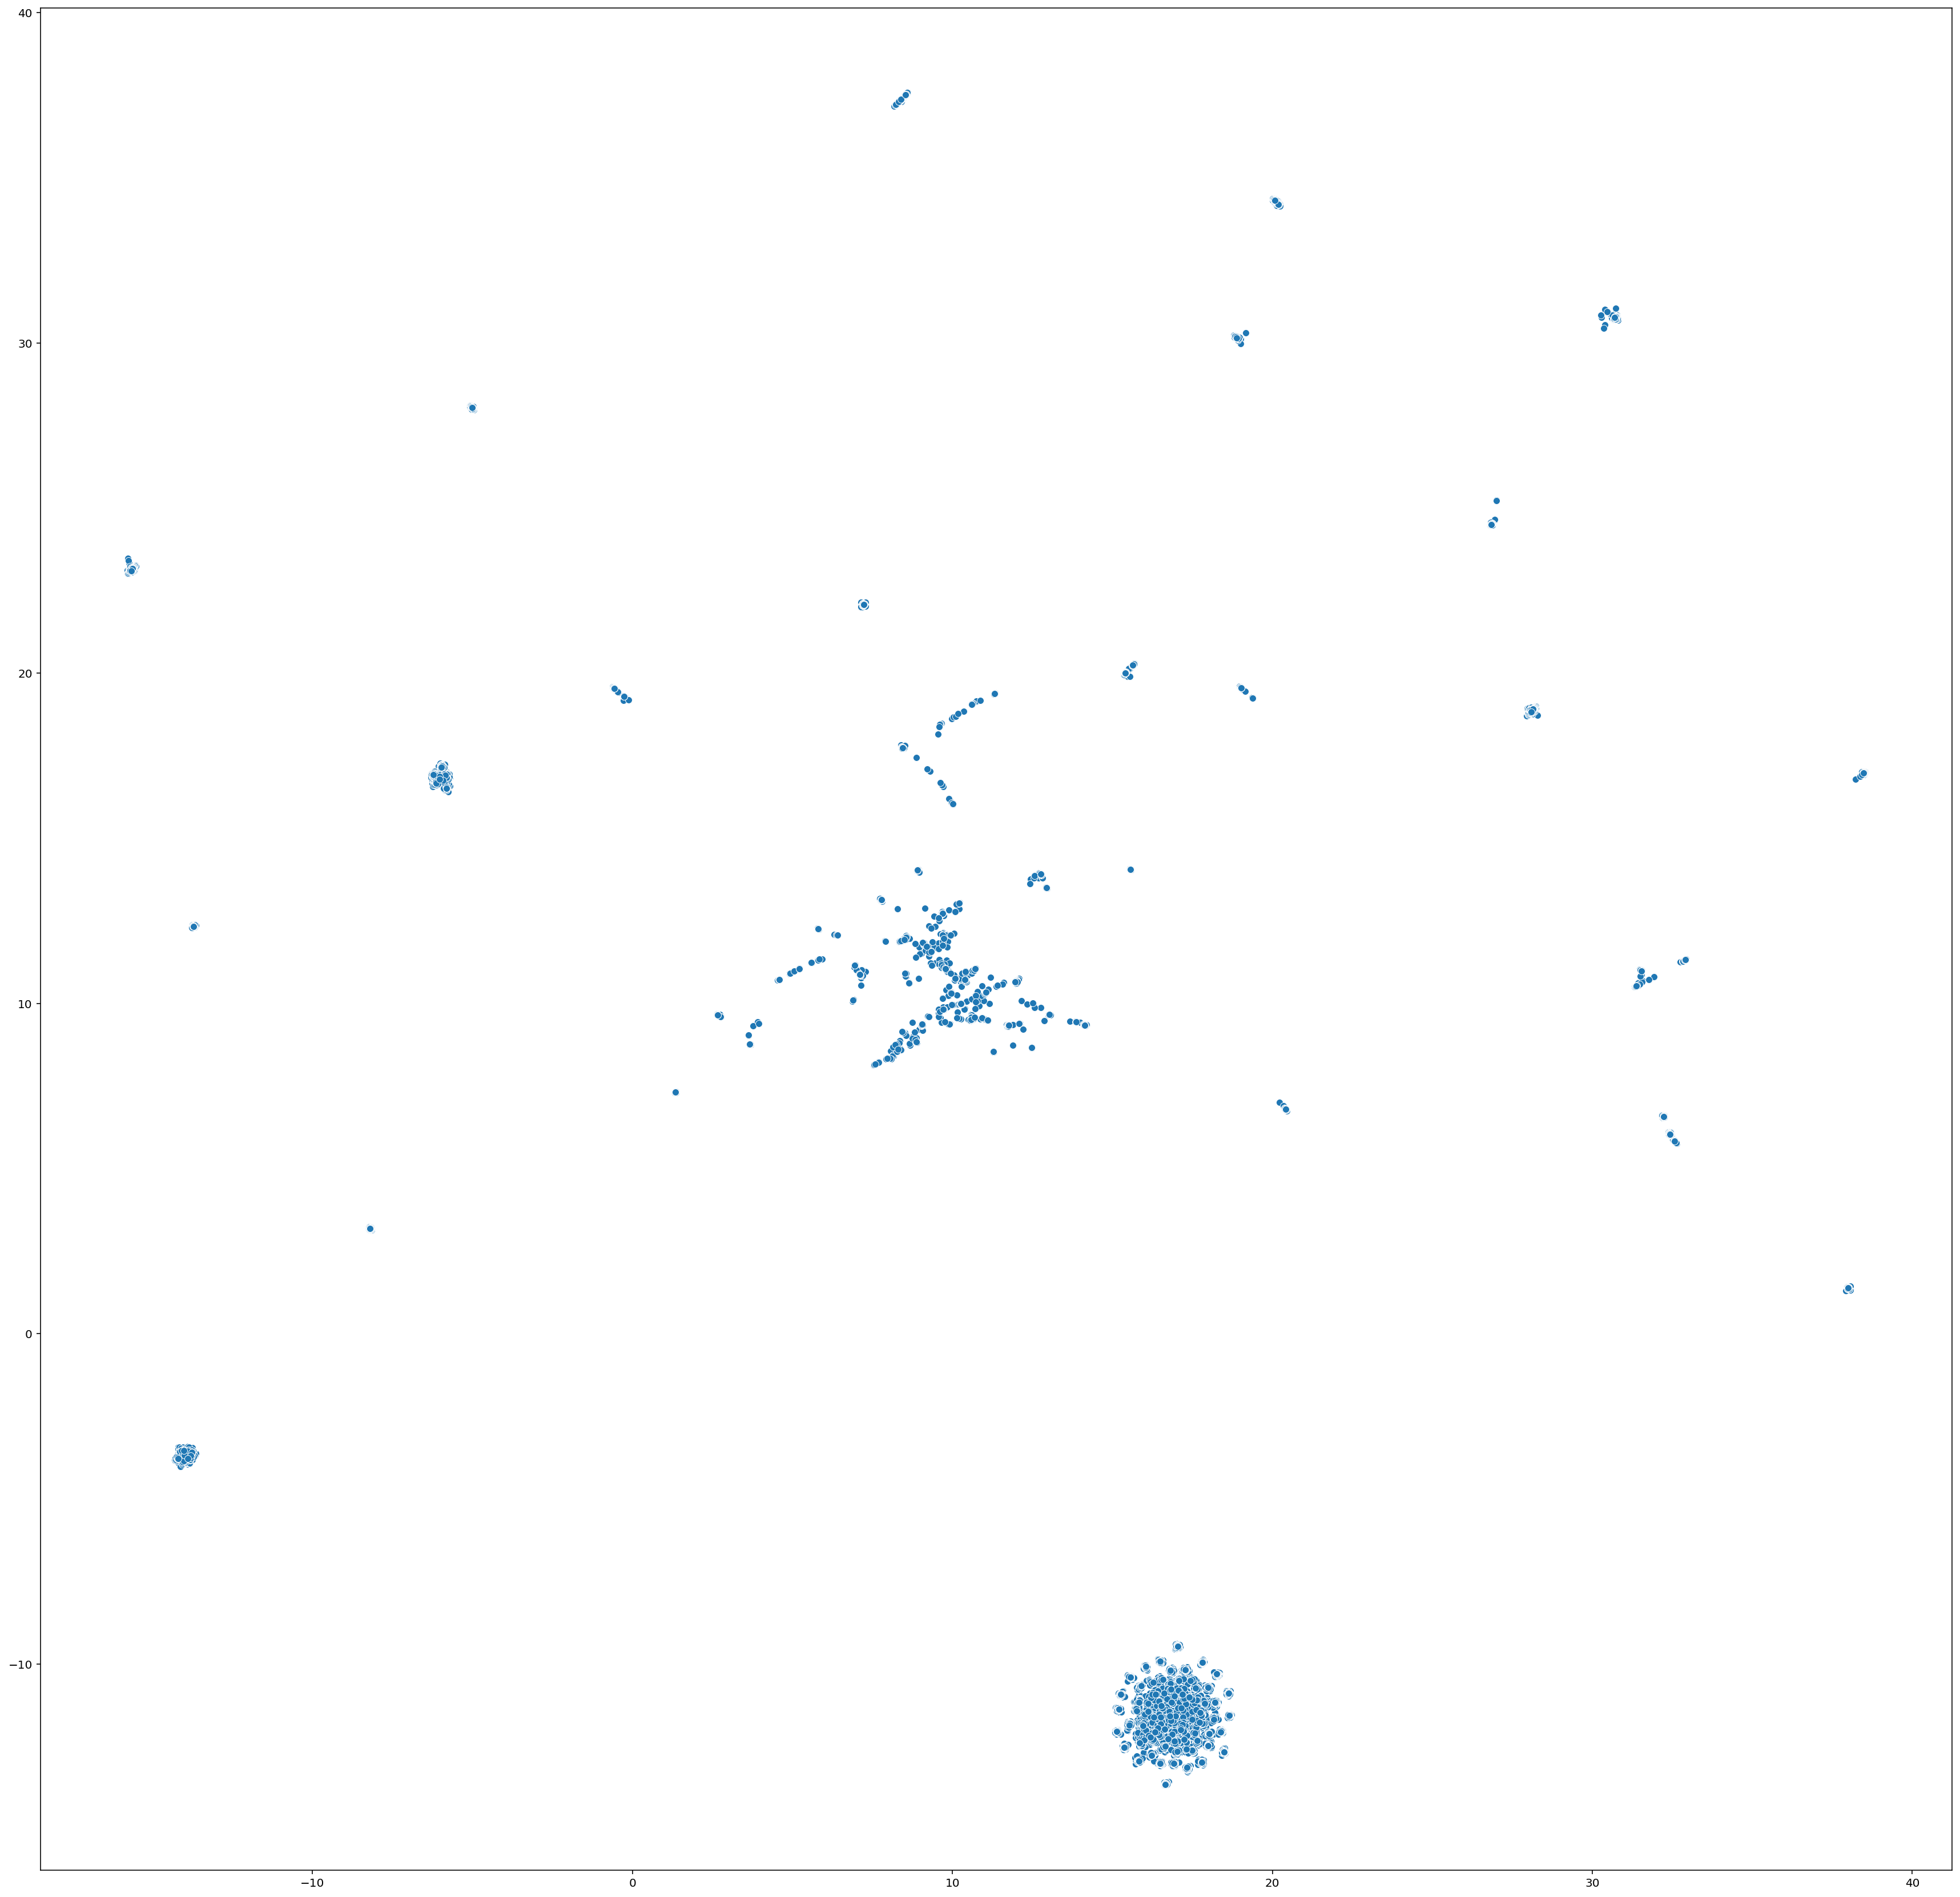

time: 524 ms (started: 2022-08-11 15:35:49 -05:00)


In [53]:
sns.scatterplot(x = embedding[:,0], y = embedding[:,1])

### Neighborhood - Per Slide

In [56]:
def neighborSlide(current_slide):
    df_single = df_full_dataset[df_full_dataset['slide_id'] == current_slide]

    pop_freq = {}
    for pop in l_pops:
        pop_freq[pop] = df_single[pop].sum() / df_single.shape[0]*100

    drop_cols = l_pops + ['centroid-1', 'centroid-0']
    df_embed = df_single.drop(df_single.columns.difference(drop_cols), 1)
    
    reducer = umap.UMAP(n_neighbors = 50, min_dist = 0.1, random_state = seed)

    embedding = reducer.fit_transform(df_embed.drop(['centroid-1', 'centroid-0'], axis = 1))

    df_embedding = pd.DataFrame(data = embedding, columns = ['umap1', 'umap2'])

    df_final = df_single.reset_index(drop = True).join(df_embedding)
    
    sorted_pops = sorted(pop_freq, key = pop_freq.get, reverse = True)
    l_sorted_pops = []
    for r in sorted_pops:
        l_sorted_pops.append([r, pop_freq[r]])
    df_sorted_pops = pd.DataFrame(l_sorted_pops, columns = ['pop_id', 'Percent of Total'])
    
    plt.figure(figsize = (5,5))
    ax = sns.barplot(data = df_sorted_pops, x = 'pop_id', y = 'Percent of Total', palette = vor_pops)
    plt.xticks(rotation = 90)
    ax.set_yscale('log')
    plt.ylim([0,100])
    plt.title('Fraction of Total Cell Count per Population')
    plt.tight_layout()
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_populations_fractions.pdf'.format(current_slide), dpi=500)
    plt.close()
    
    for index, k in enumerate(pop_freq.keys()):
        fig= plt.figure(figsize = (10,10))
        if len(df_final) > 10000:
            samplerows = df_final.sample(10000)
        else:
            samplerows = df_final
        ax = sns.scatterplot(data = samplerows, x = 'umap1', y = 'umap2', hue = k, palette = 'viridis', linewidth = 0, s = 10)

        plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_umap_{}.pdf'.format(current_slide, k))
        plt.close()
        
    n_clusters = 15
    kmeans = KMeans(n_clusters = n_clusters, random_state = seed)
    kmeans.fit(df_embedding)

    y_kmeans = kmeans.predict(df_embedding)
    
    df_kmeans = pd.DataFrame(y_kmeans, columns = ['kmeans_cluster'])
    df_final = df_final.join(df_kmeans)
    
    df_final.to_csv(neighbor_umap_dir + '/{}_umap.csv'.format(current_slide), index = False)


    plt.figure(figsize = (5,5))
    ax = sns.scatterplot(data = df_final, x = 'umap1', y = 'umap2', hue = 'kmeans_cluster', s = 3, linewidth = 0, palette = 'tab20')
    ax.set_aspect('equal')
    plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad = 0.)
    plt.tight_layout()
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_clusters_on_umap.pdf'.format(current_slide), dpi=500)
    plt.close()
    
    cluster_cols = list(pop_freq.keys()).copy()
    cluster_cols.append('kmeans_cluster')
    df_clusters = df_final.drop(df_final.columns.difference(cluster_cols), 1)

    df_clusters = df_clusters.groupby('kmeans_cluster').mean()  
    
    sns.clustermap(df_clusters, cmap = 'viridis')
    plt.tight_layout()
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_clustergram.pdf'.format(current_slide), dpi=500)
    plt.close()
    
    drop_cols = cluster_cols.copy()
    drop_cols.extend(['centroid-0', 'centroid-1'])
    cluster_homog = df_final[['centroid-0', 'centroid-1', 'kmeans_cluster']].merge(df_single.drop(df_single.columns.difference(drop_cols),1), on =['centroid-0', 'centroid-1'])

    cluster_homog = cluster_homog.drop(columns = ['centroid-0', 'centroid-1'])
    
    df_homog = pd.DataFrame()
    for i in range(len(np.unique(y_kmeans))):
        out = pd.melt(cluster_homog[cluster_homog['kmeans_cluster']==i].drop(columns = 'kmeans_cluster')).groupby('variable').quantile(0.90).rename(columns = {'value' : 'kmeans_cluster_{}'.format(i)}).reset_index()
        if i == 0:
            df_homog = out
        else:
            df_homog = pd.merge(df_homog, out, on = 'variable')

    order = df_homog.loc[(df_homog.iloc[:, 1:]!=0).any(axis = 1)]['variable'].tolist()[::-1]
    
    fig, axs = plt.subplots(int(n_clusters/4)+1,4, figsize = (20, int((n_clusters/4+1))*5))
    fig.subplots_adjust(hspace=1,wspace=0.4)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


    for i in range(len(np.unique(y_kmeans))):
        plt.subplot(4,int(n_clusters/4)+1, i+1)
        g = sns.boxplot(data = pd.melt(cluster_homog[cluster_homog['kmeans_cluster']==i].drop(columns = 'kmeans_cluster')), x = 'variable', y = 'value', showfliers = False, order = order, palette = vor_pops)
        g.set(ylim=(0,1.2))
        g.tick_params(axis = 'x', labelrotation = 90)
        g.set_xlabel('')
        g.set_ylabel('Neighbor Frequency')
        g.set_title('Cluster {}, n = {}'.format(str(i), len(cluster_homog[cluster_homog['kmeans_cluster']==i])))

    plt.tight_layout()
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_Neighborhood_homogeneity_slide.pdf'.format(current_slide), dpi=500)
    plt.close()   
    
    cluster_freq = {}                                                                                                           # UPDATED TO END
    for cluster in sorted(cluster_homog['kmeans_cluster'].unique()):
        cluster_freq[cluster] = cluster_homog[cluster_homog['kmeans_cluster'] == cluster].shape[0] / cluster_homog.shape[0] * 100

    sorted_clusters = sorted(cluster_freq, key = cluster_freq.get, reverse = True)
    l_sorted_clusters = []
    for r in sorted_clusters:
        l_sorted_clusters.append([r, cluster_freq[r]])
    df_sorted_clusters = pd.DataFrame(l_sorted_clusters, columns = ['cluster_id', 'Percent of Total'])

    plt.figure(figsize = (5,5))
    ax = sns.barplot(data = df_sorted_clusters, x = 'cluster_id', y = 'Percent of Total', palette = 'tab20')
    plt.xticks(rotation = 90)
    plt.title('Percent of Total Cell Count per Neighborhood Cluster')
    plt.tight_layout()
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_clusters_fractions.pdf'.format(current_slide), dpi=500)
    plt.close()                                                                                                                  # UPDATED ^

time: 2.75 ms (started: 2022-08-11 15:54:20 -05:00)


In [57]:
# parallel processing of all slides.  Can be time consuming depending on size of dataset 
Parallel(n_jobs = int(available_cores * 0.9), backend = 'loky')(delayed(neighborSlide)(x)for x in tqdm([slide_id]))            # For single, multiple slides unbracket 'slide_id'

100%|██████████| 1/1 [00:00<00:00, 328.78it/s]


[None]

time: 1min 24s (started: 2022-08-11 15:54:22 -05:00)


## Color Voronoi Plot

In [63]:
#Enter row, col, and slide names for tile of interest
vor_row = '0'
vor_col = '1'
vor_slide = 'N16-244-2A'
vor_tile = df_full_dataset[(df_full_dataset['Tile']=='({}, {})'.format(vor_row, vor_col)) & (df_full_dataset['slide_id']==vor_slide)]

time: 6.34 ms (started: 2022-08-11 15:57:25 -05:00)


In [64]:
coords = np.asarray(vor_tile[['centroid-1', 'centroid-0']])

time: 2.5 ms (started: 2022-08-11 15:57:25 -05:00)


In [65]:
vor = Voronoi(coords)

time: 14.9 ms (started: 2022-08-11 15:57:25 -05:00)


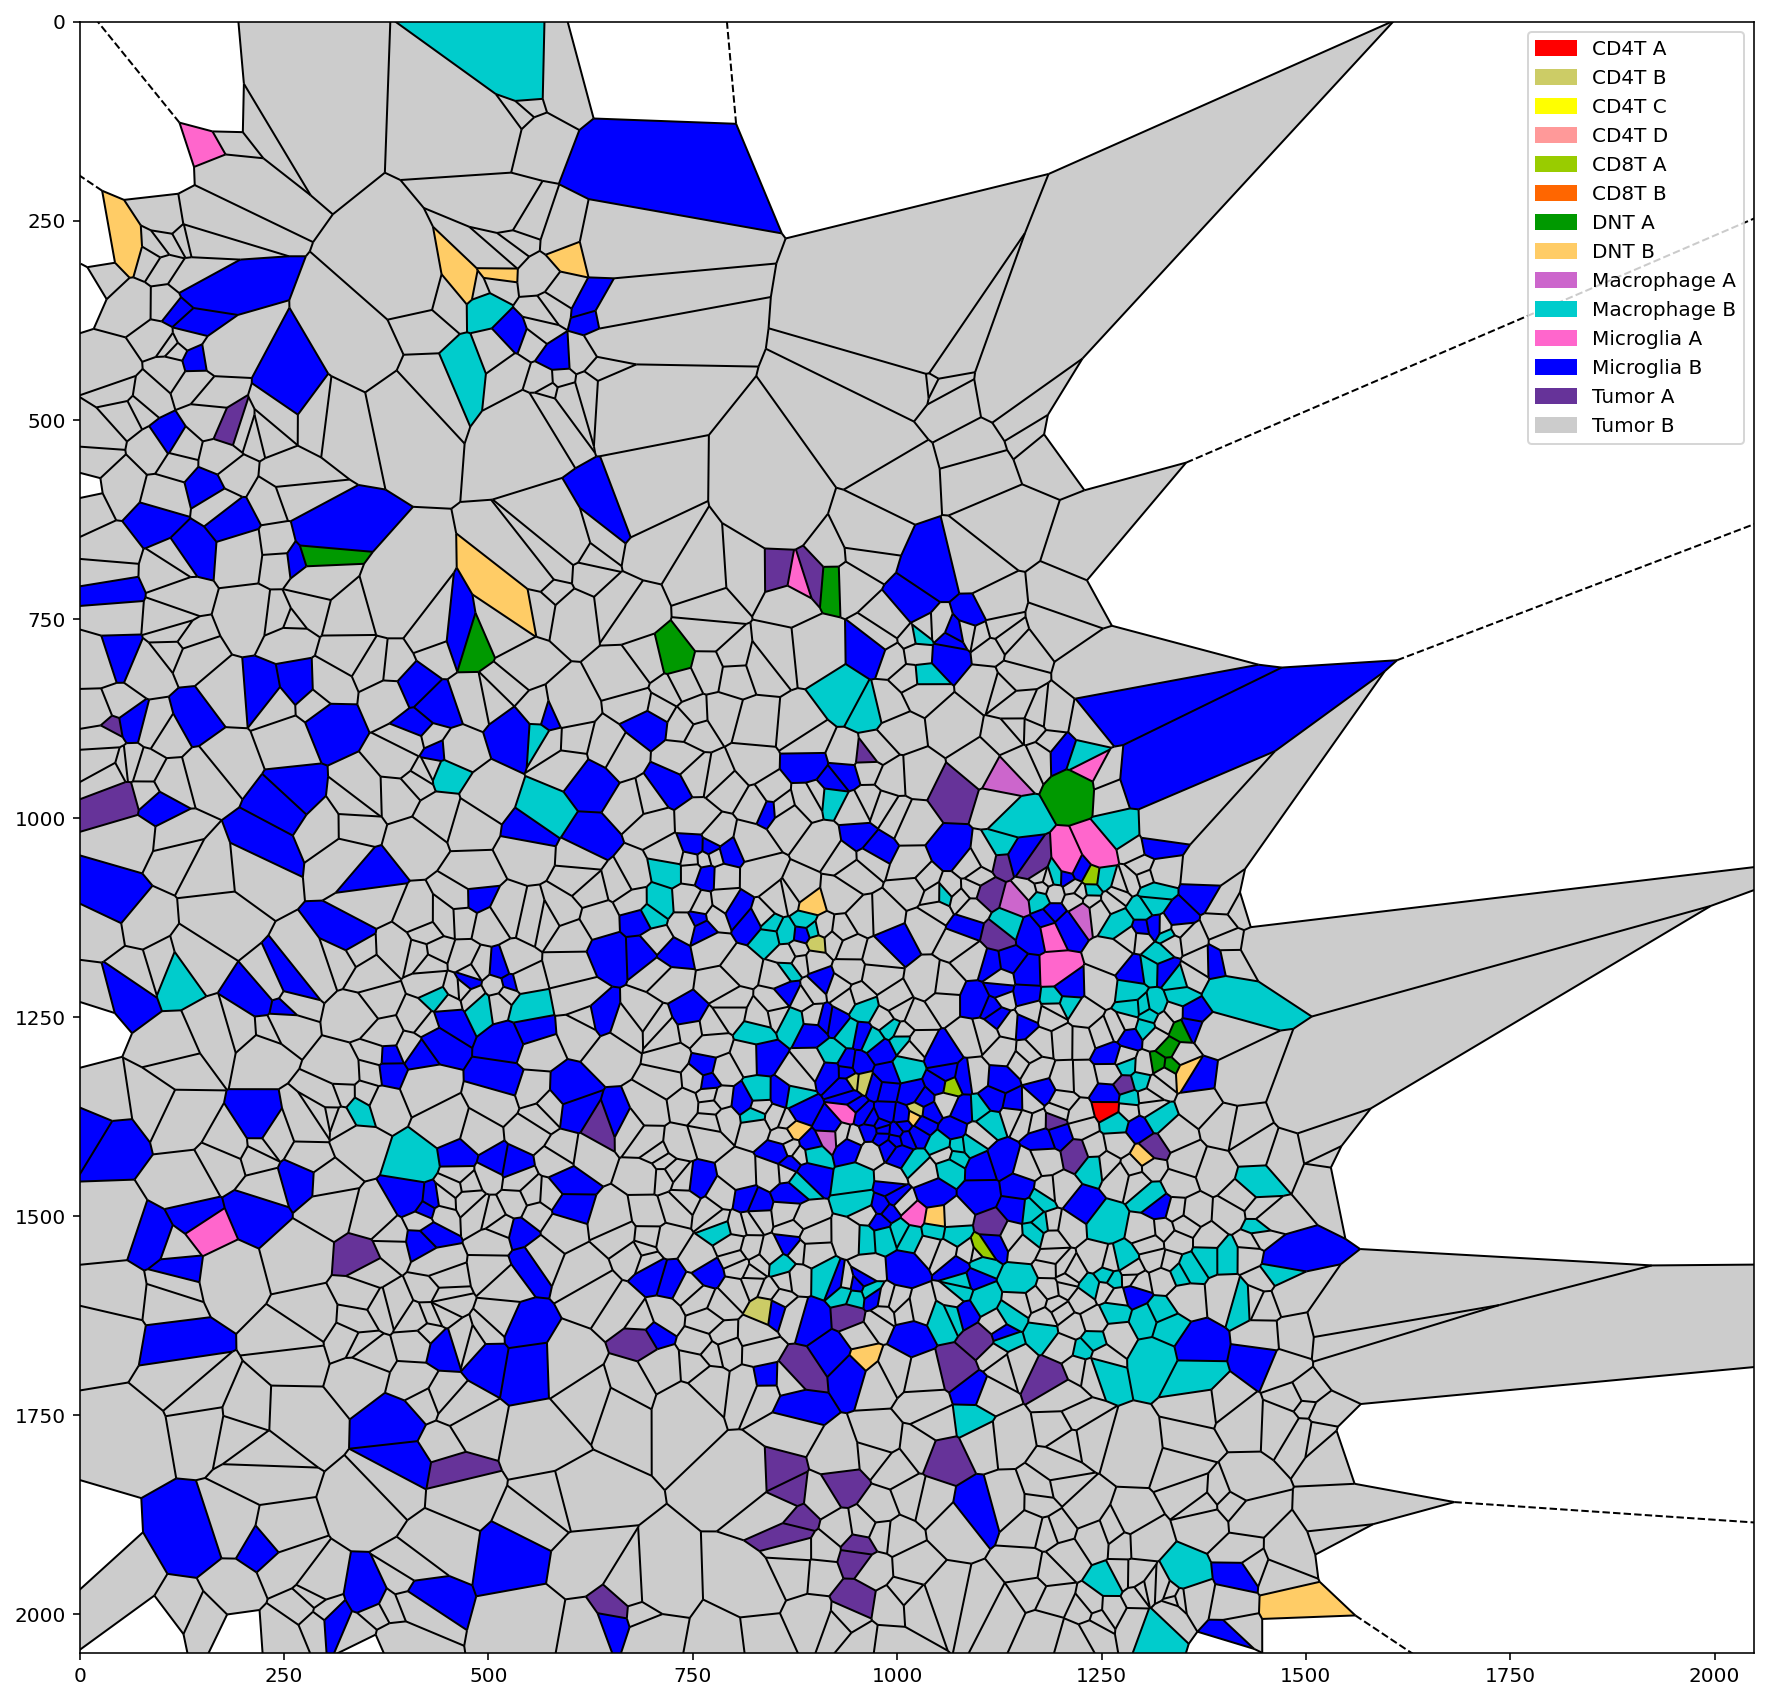

time: 3.5 s (started: 2022-08-11 15:57:25 -05:00)


In [66]:
fig = voronoi_plot_2d(vor, show_vertices = False, show_points = False)
fig.set_size_inches(15,15)
for l in l_pops:
    for j in range(len(coords)):
        region = vor.regions[vor.point_region[j]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            if vor_tile['pop_ID'].iloc[j] == l:
                color = vor_pops[l]
                plt.fill(*zip(*polygon), color)
plt.ylim(0,tile_y)
plt.xlim(0,tile_x)
plt.gca().invert_yaxis()

handles = []
for index, x in enumerate(l_pops):
    h = mpatches.Patch(color = vor_pops[l_pops[index]], label = l_pops[index])
    handles.append(h)
    
plt.legend(handles = handles)

plt.savefig(neighborhood_dir + '/Voronoi_{}_r{}_c{}.pdf'.format(vor_slide, vor_row, vor_col), dpi=500)

### Sample niche images

In [69]:
l_clustered = glob(neighbor_umap_dir + '/*.csv')
for index, l in enumerate(l_clustered):
    print(str(index) + ' : ' +  os.path.basename(l))

0 : N16-244-2A_umap.csv
time: 1.67 ms (started: 2022-08-11 15:58:02 -05:00)


In [70]:
#enter index number of slide of interest
slide_of_interest = 0
df_sample_plots = pd.read_csv(l_clustered[slide_of_interest])
sample_slide = os.path.basename(l_clustered[slide_of_interest]).split('_')[0]

time: 43.3 ms (started: 2022-08-11 15:58:02 -05:00)


/home/workstation/tensor_env/lib/python3.8/site-packages/scipy/spatial/_plotutils.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


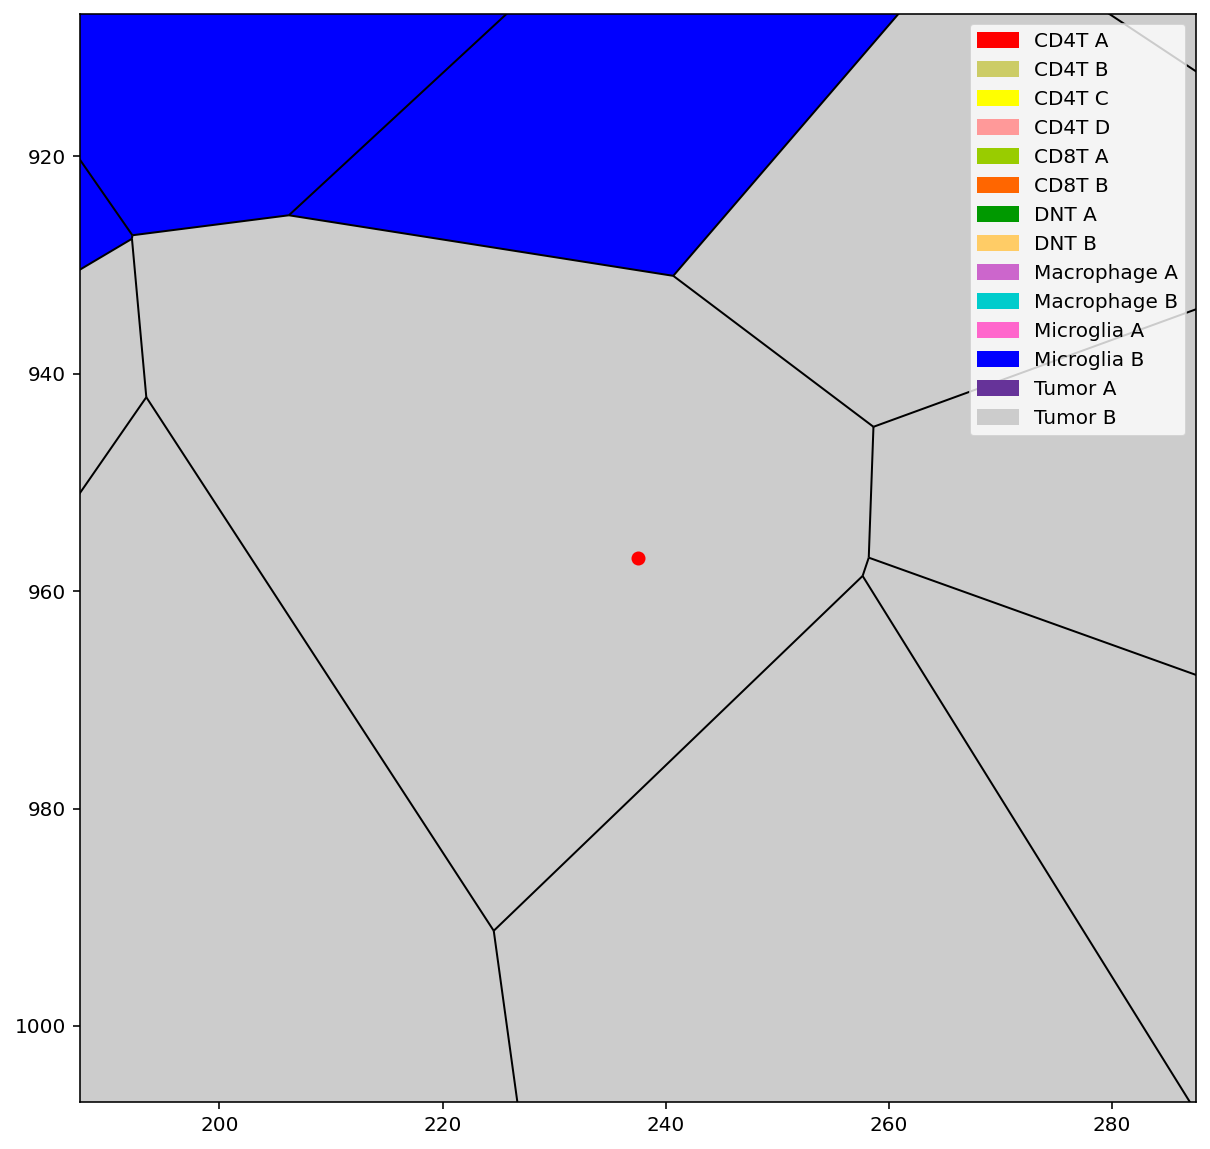

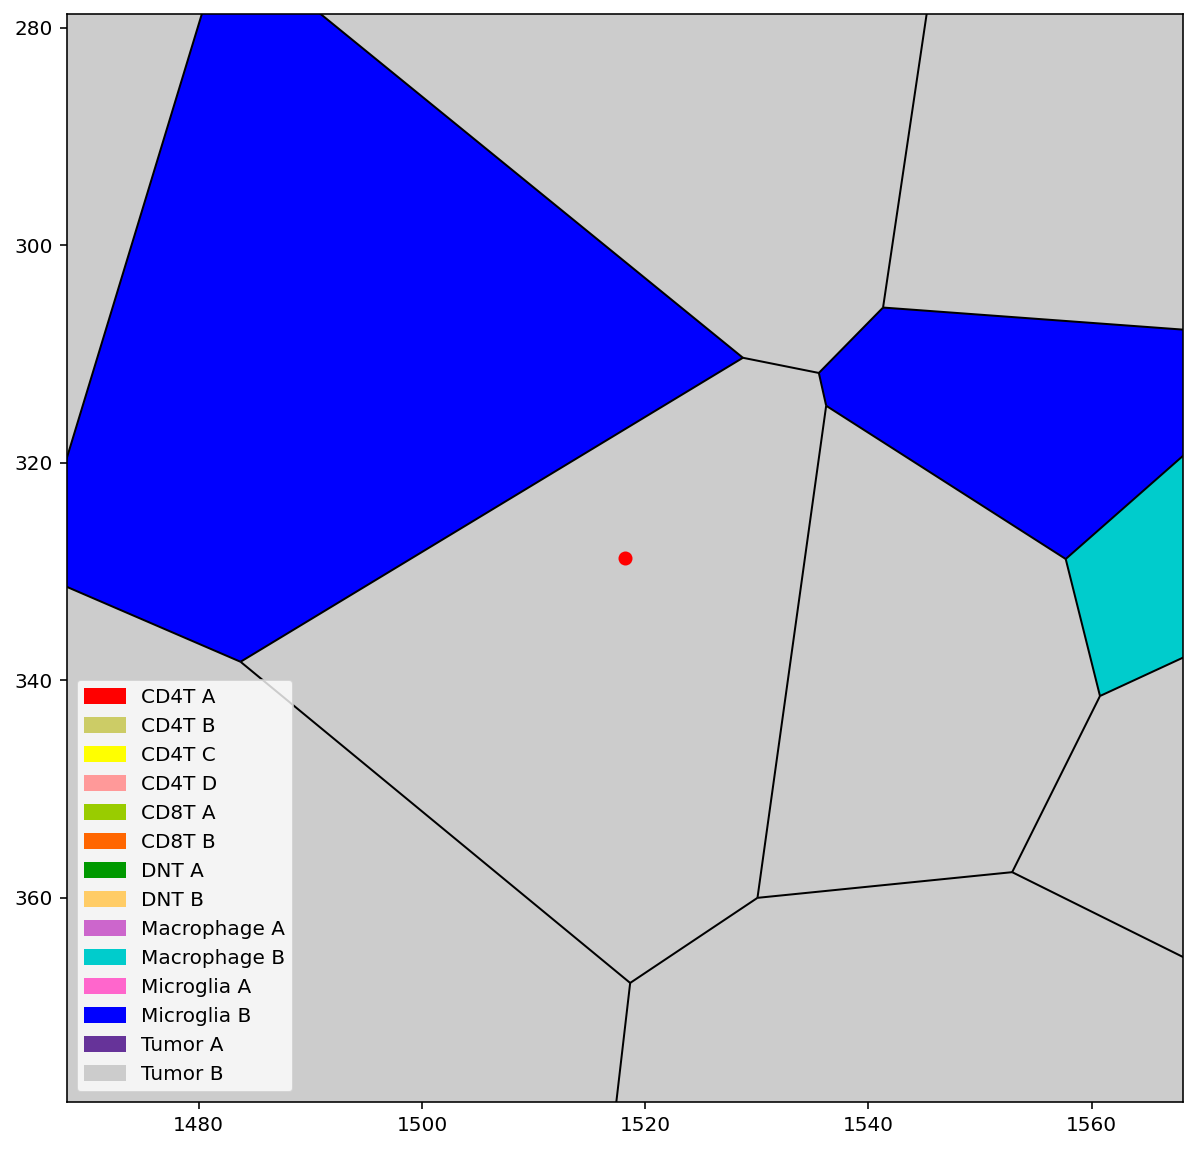

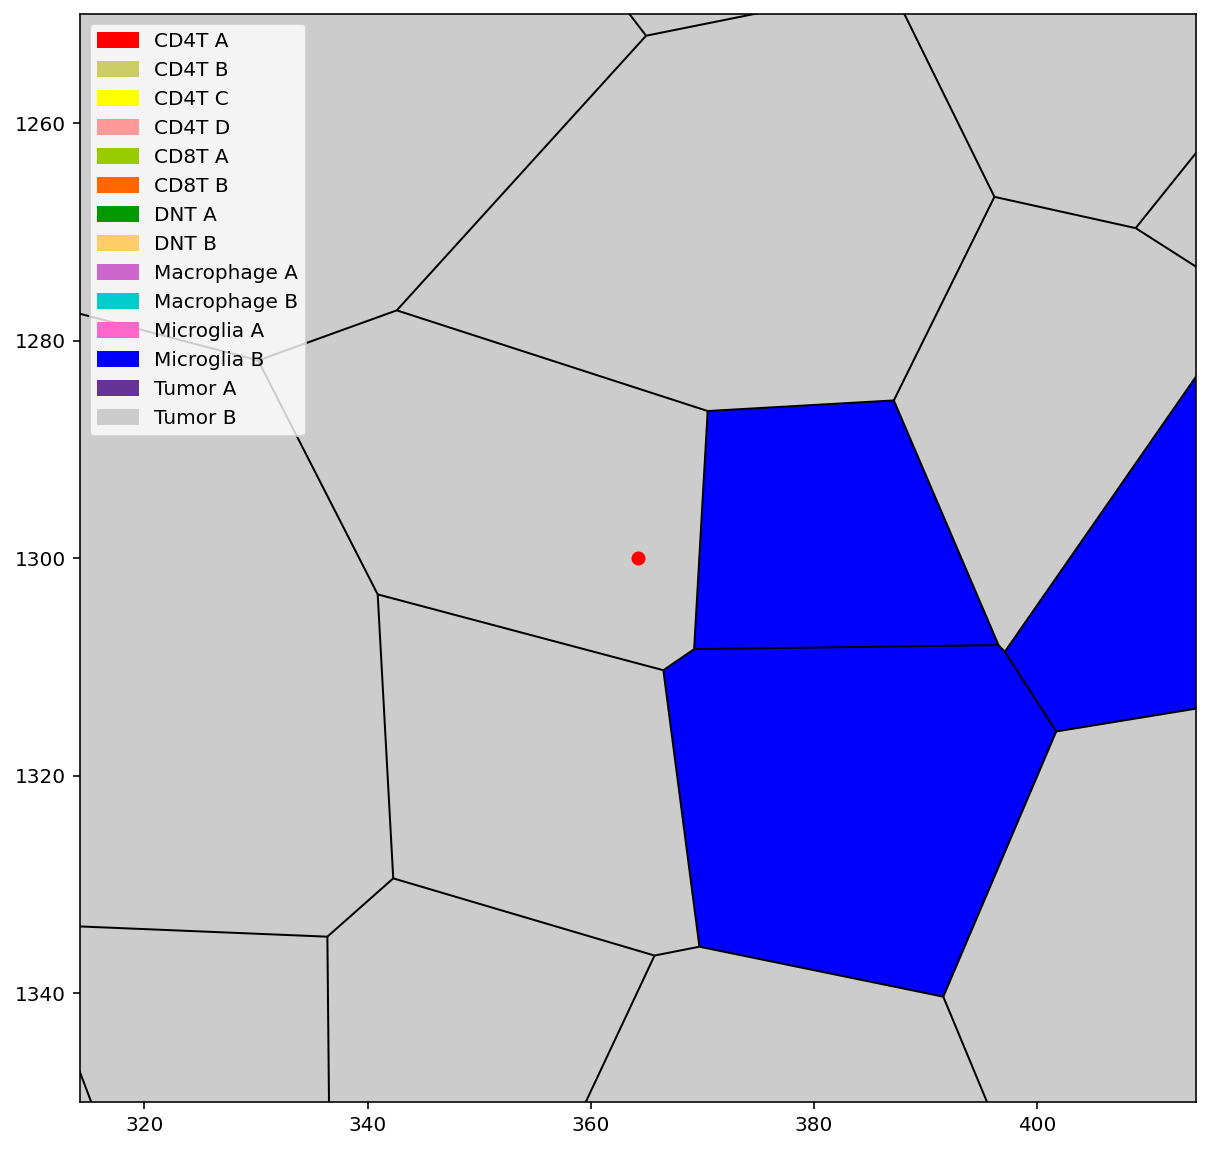

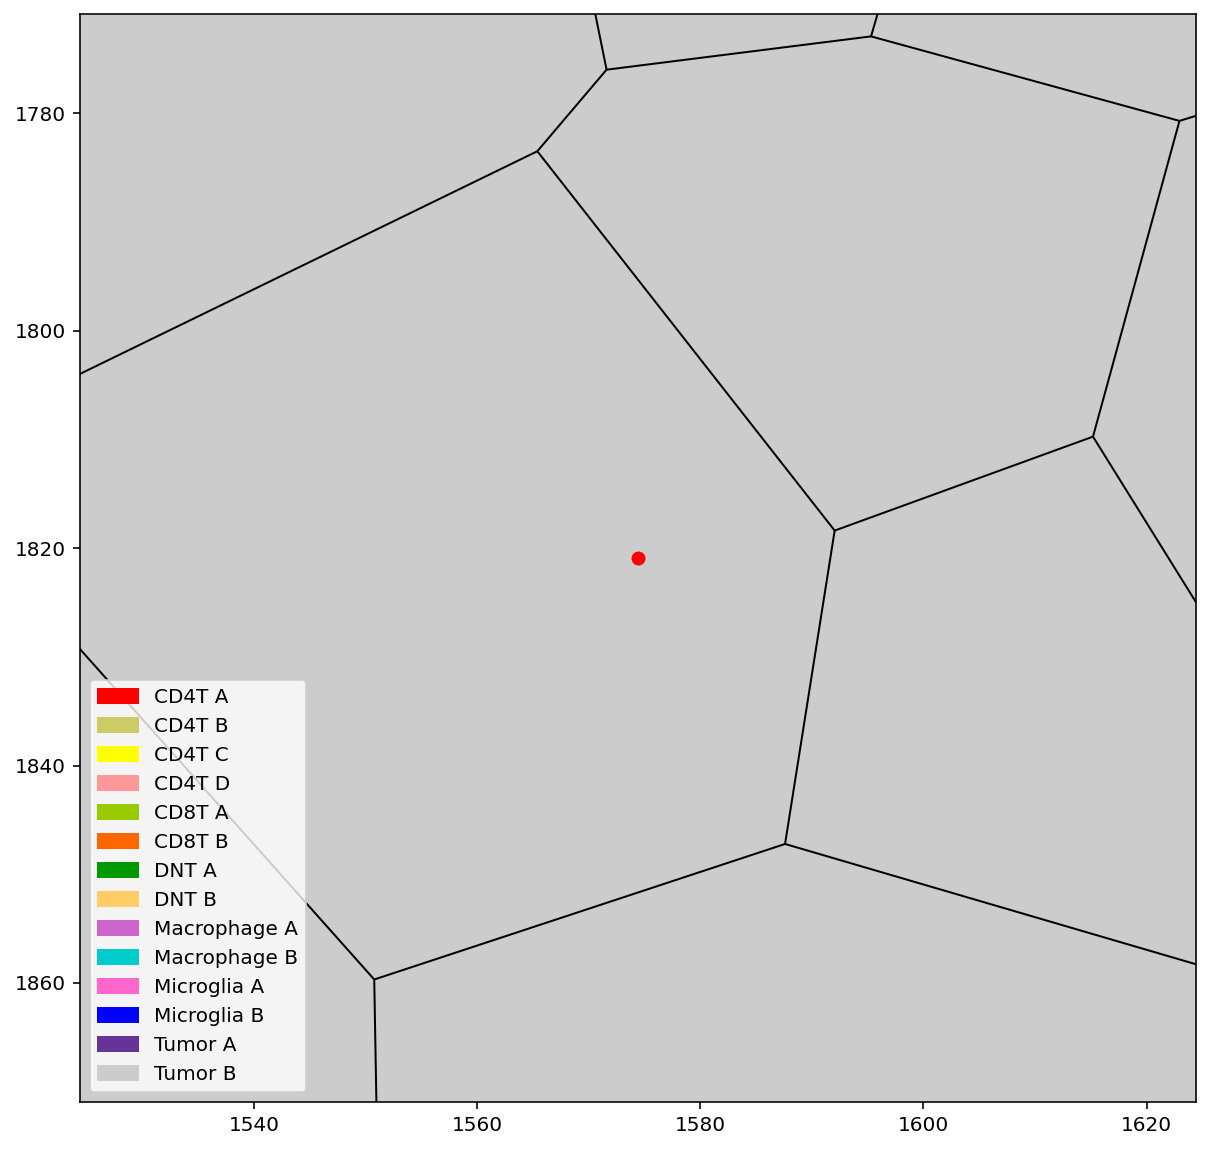

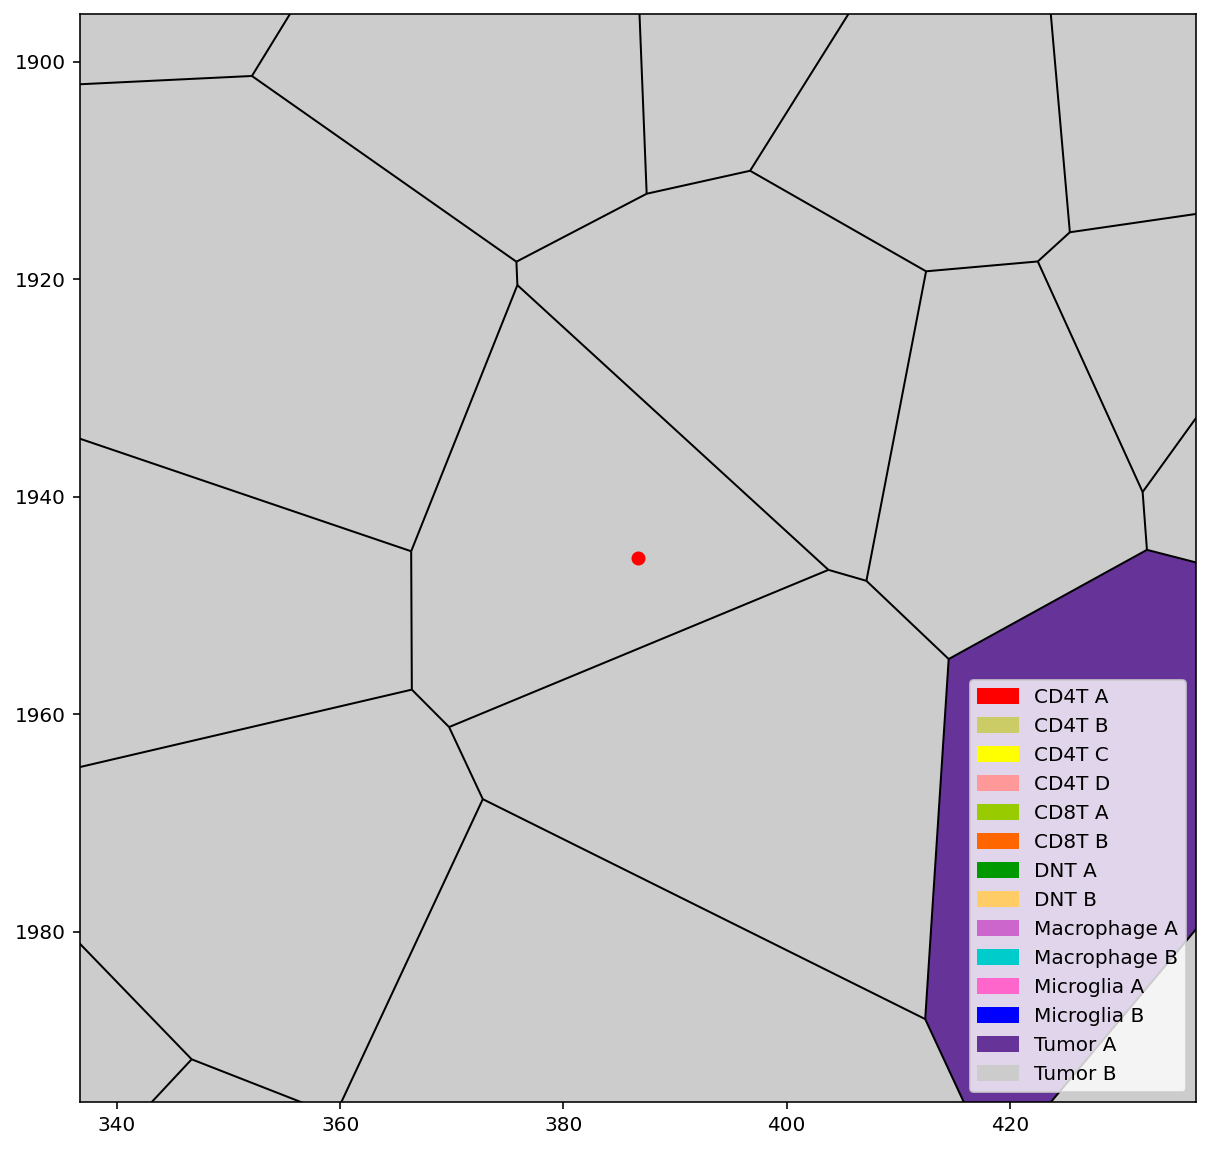

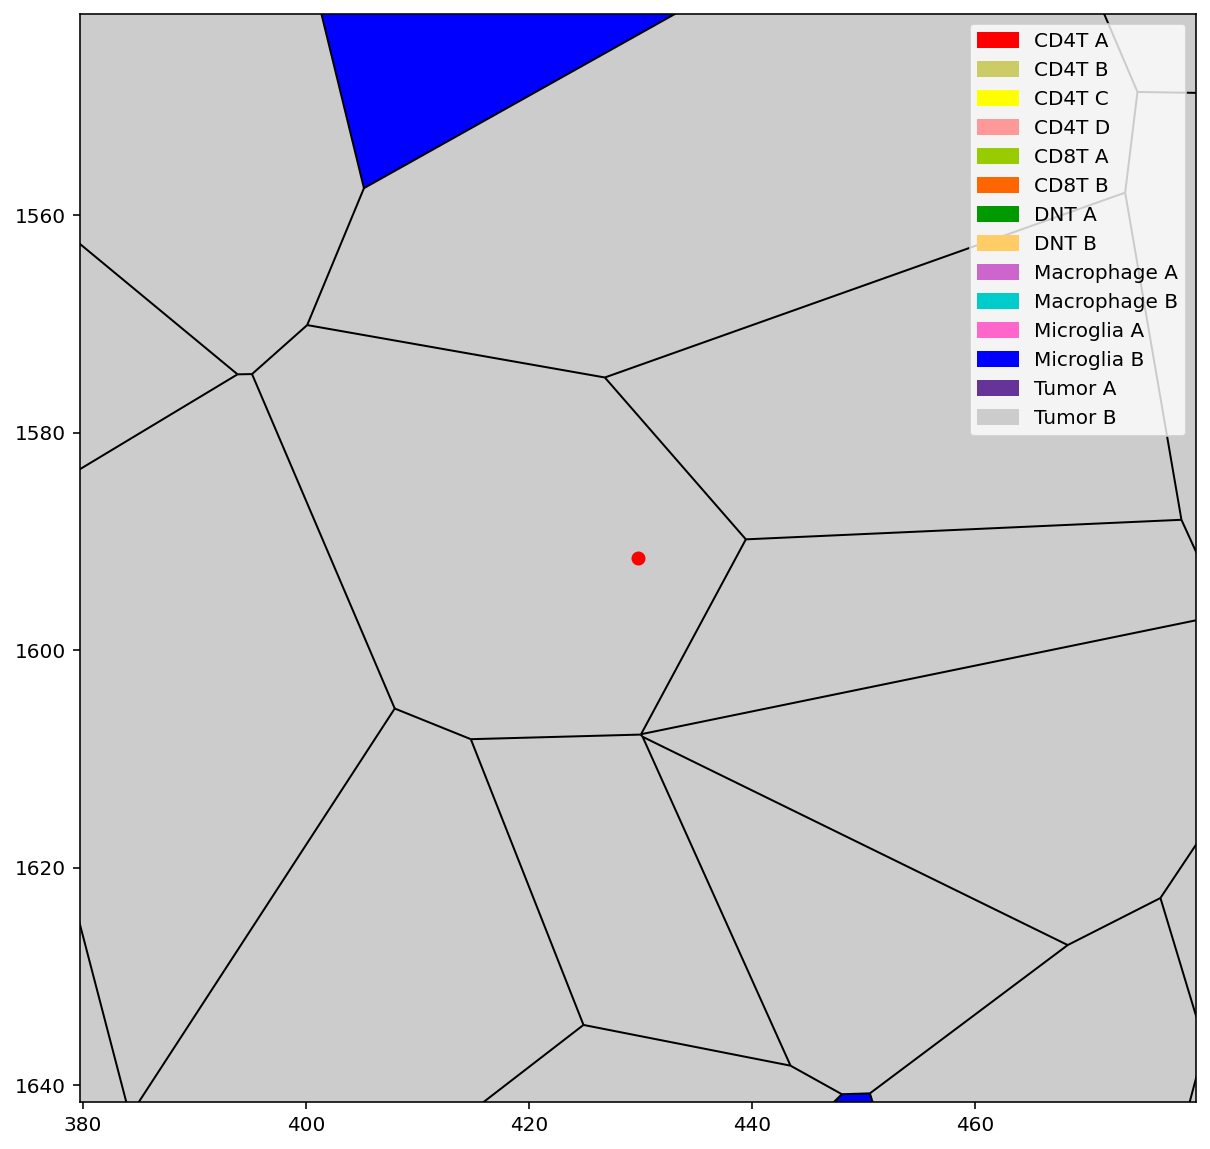

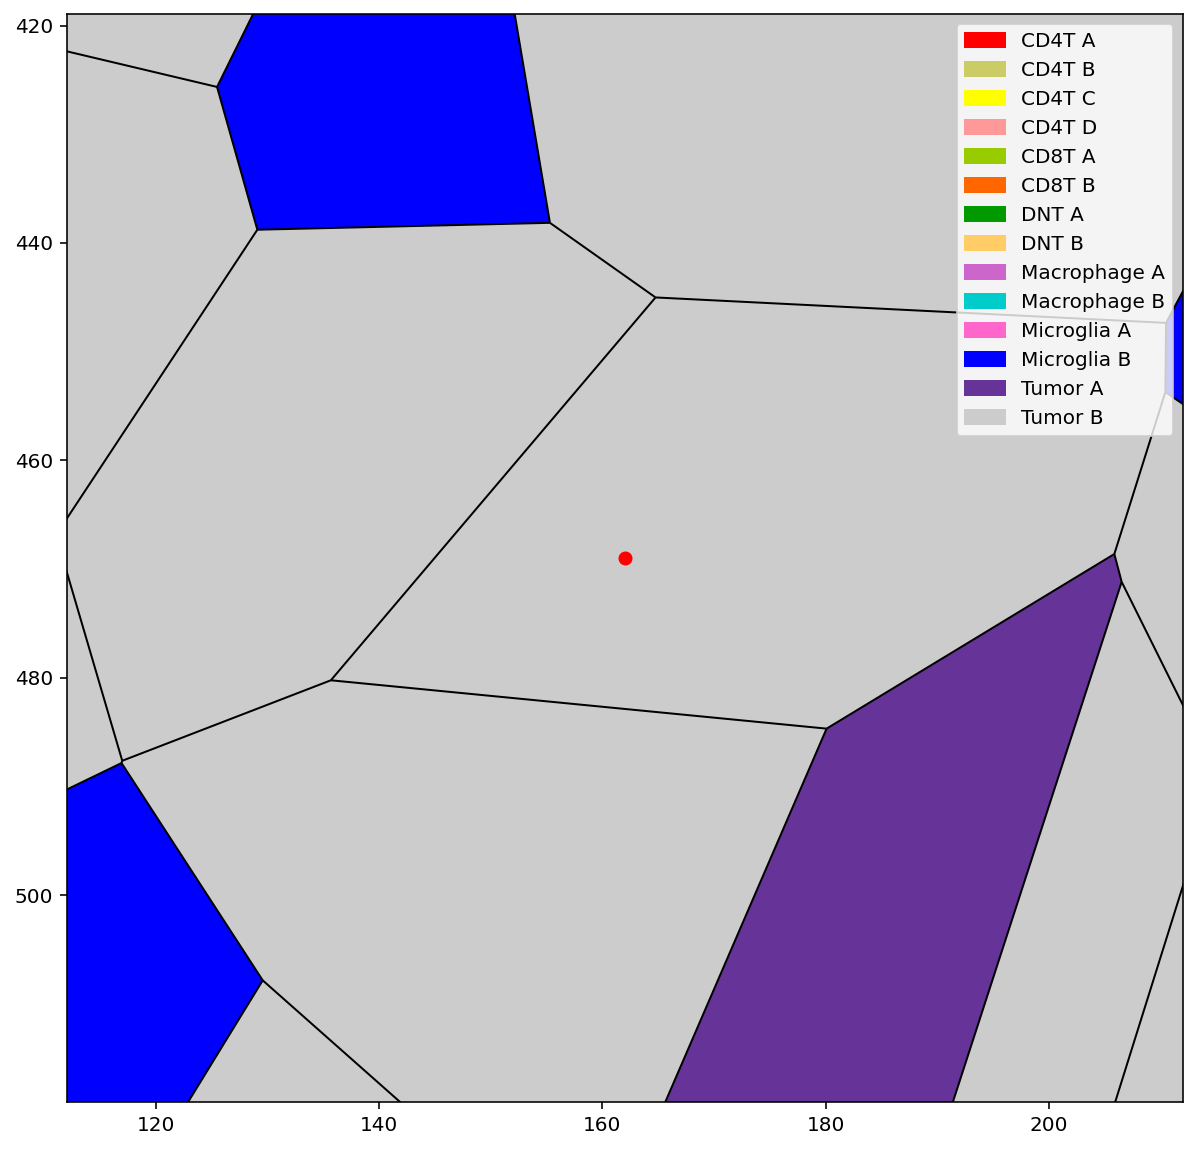

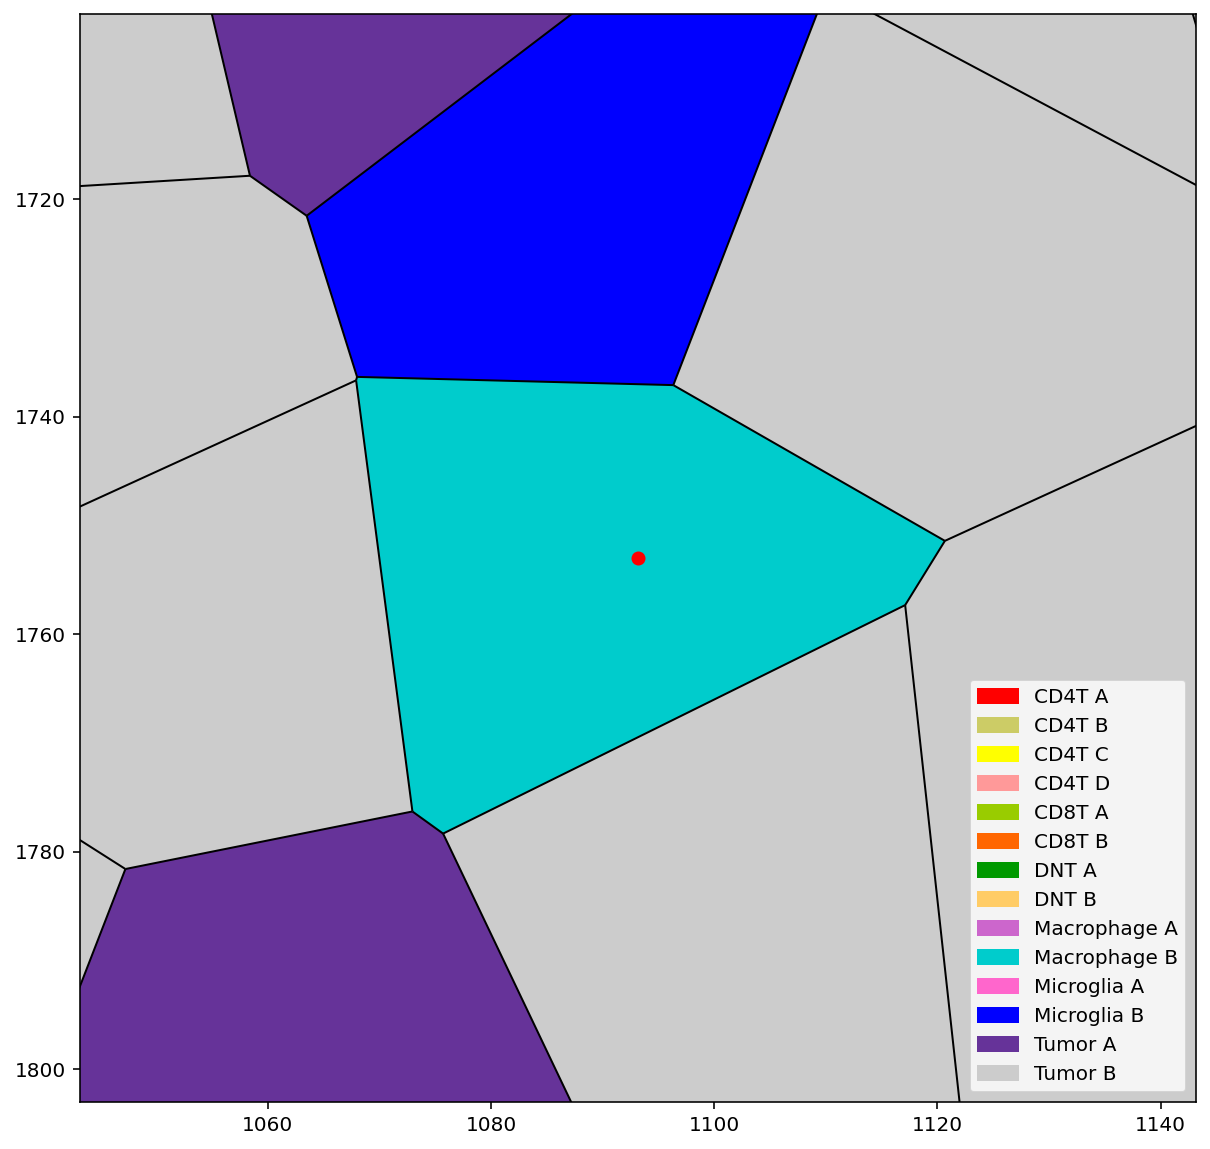

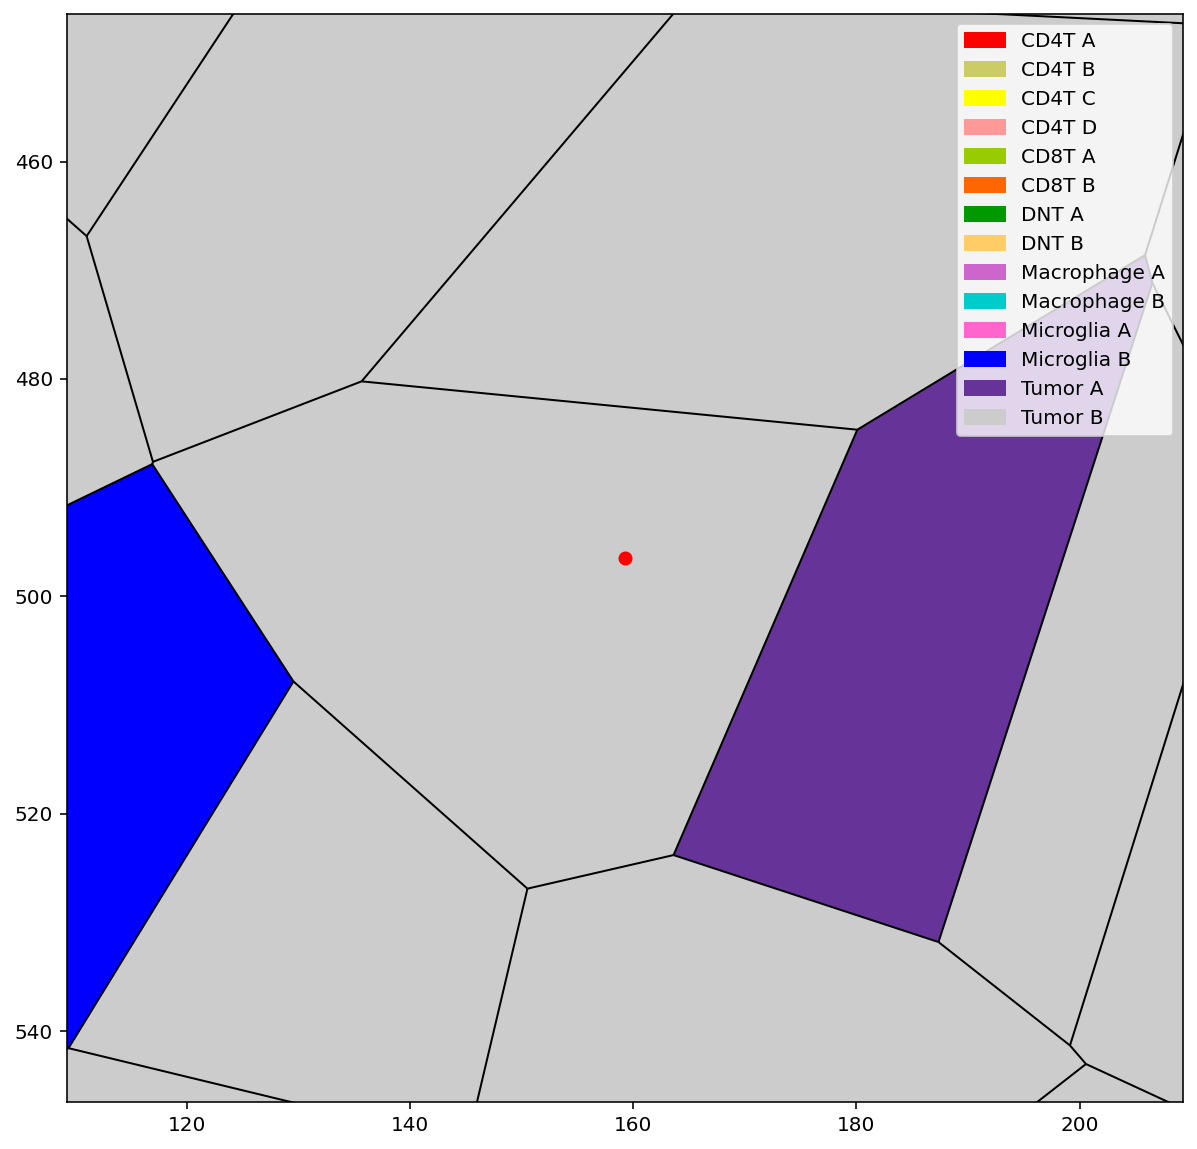

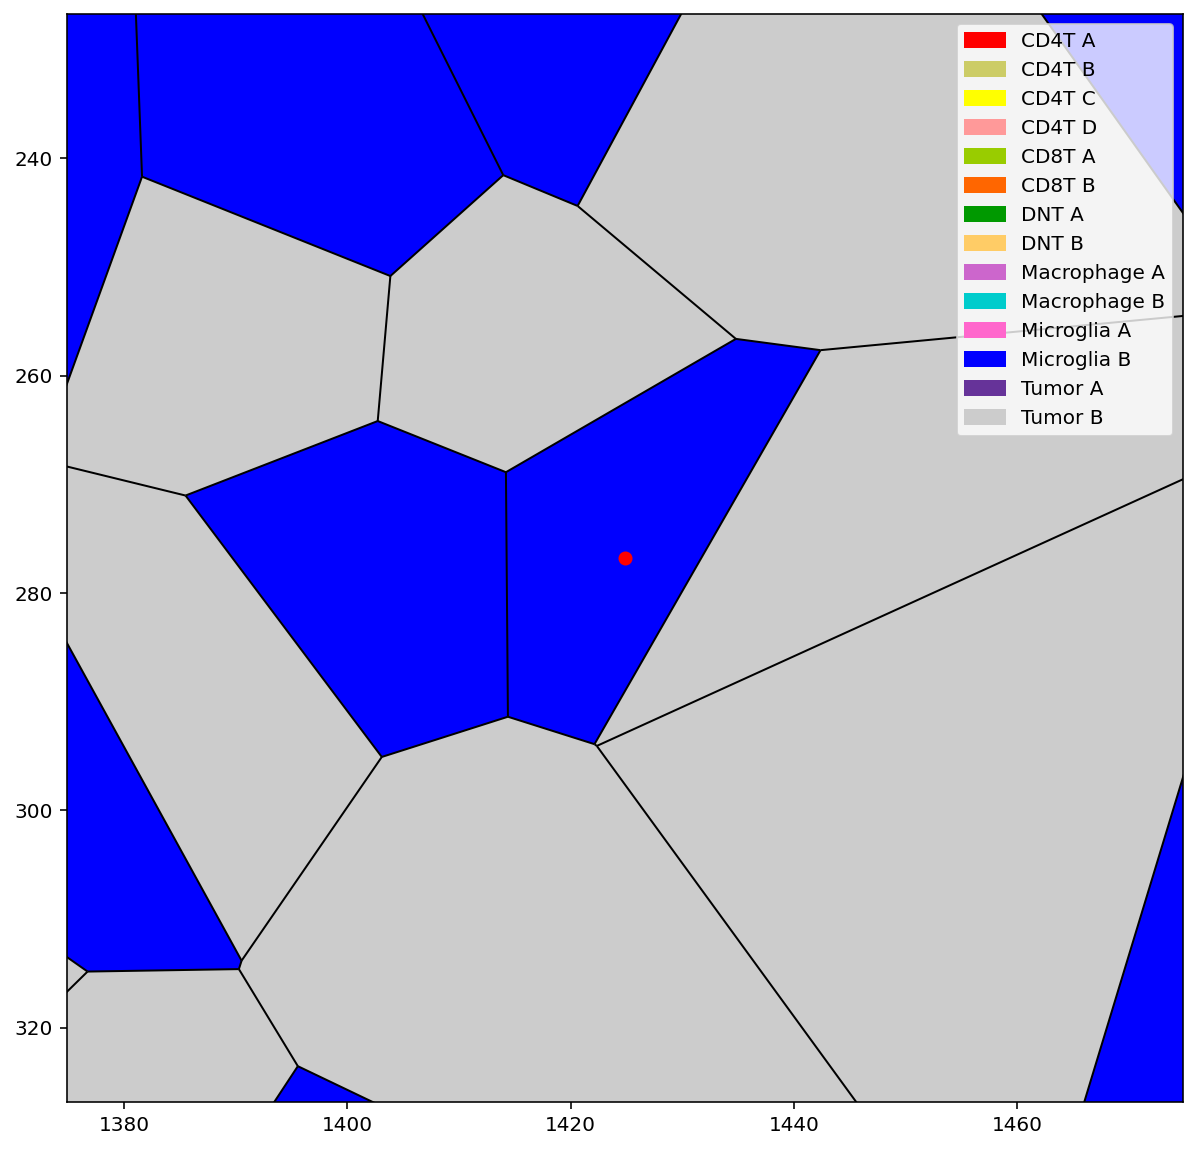

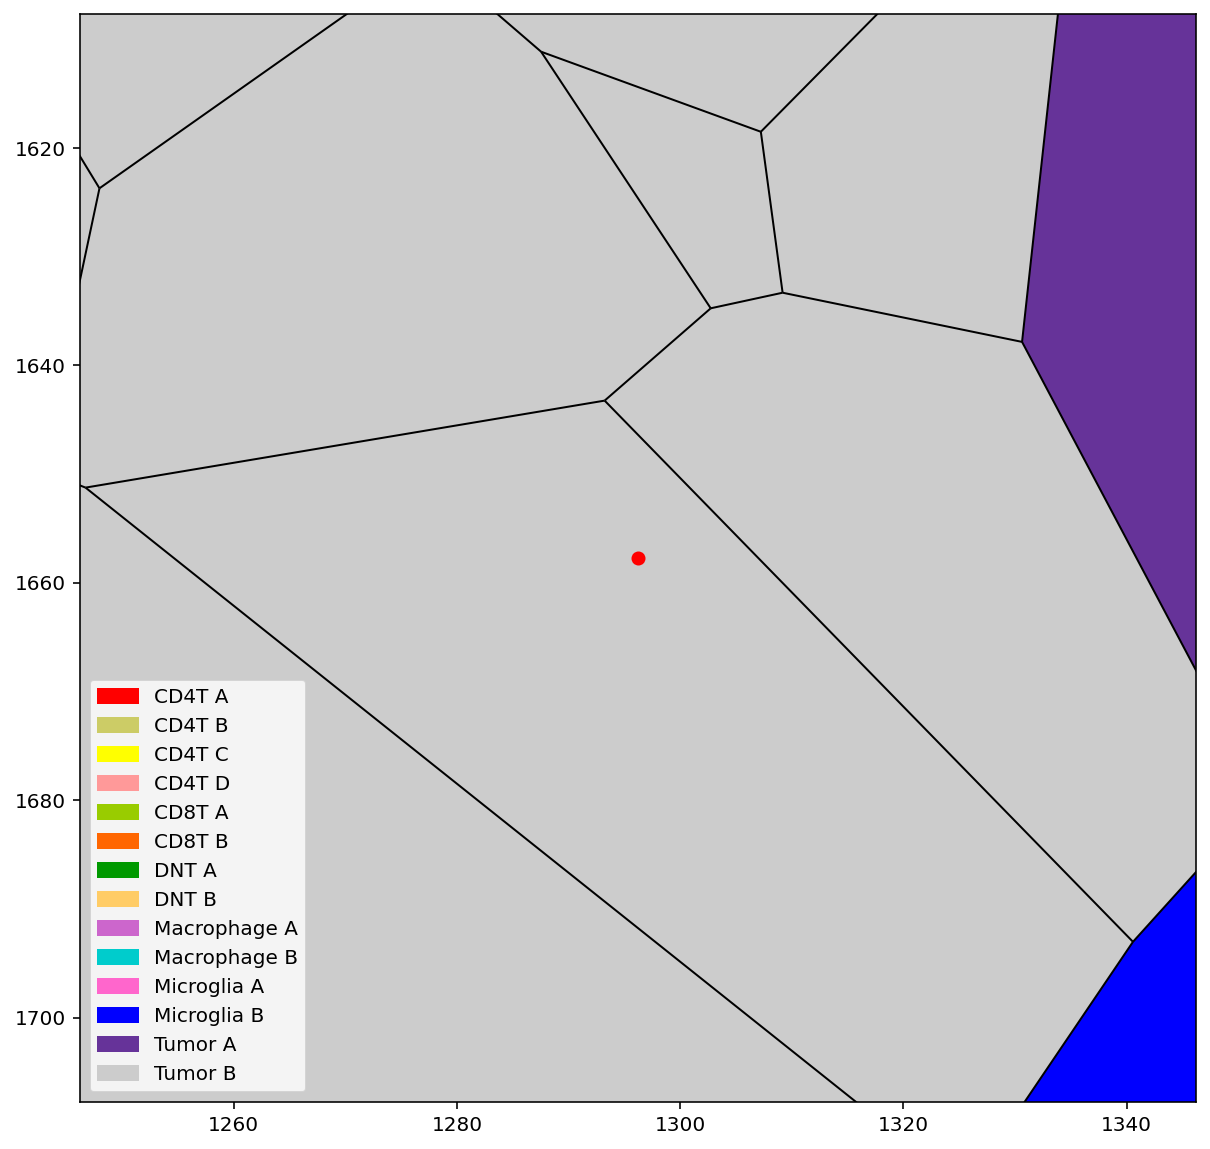

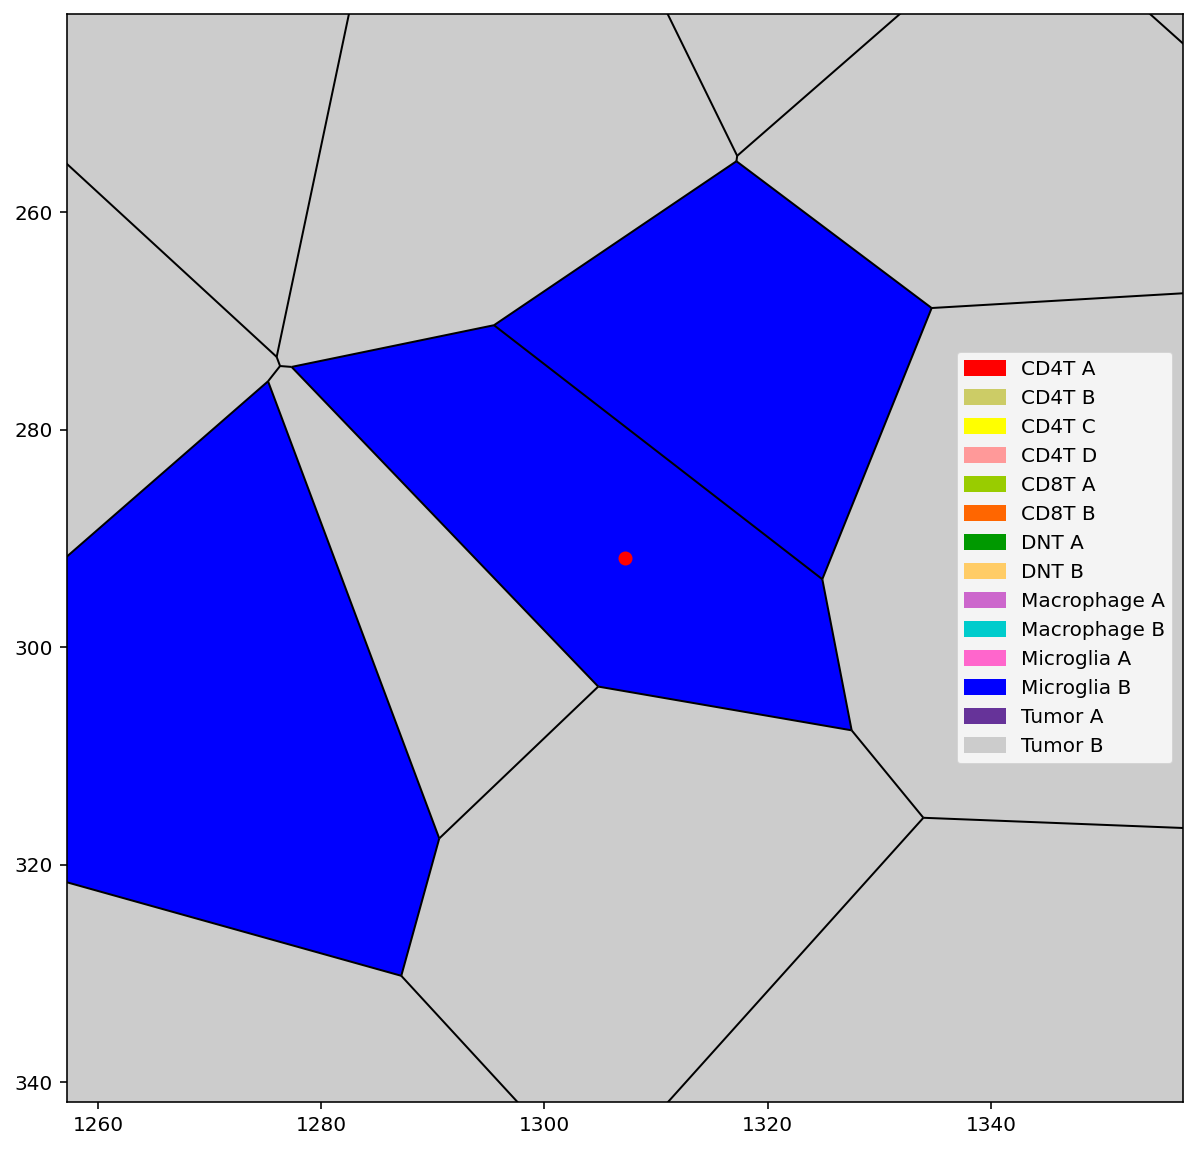

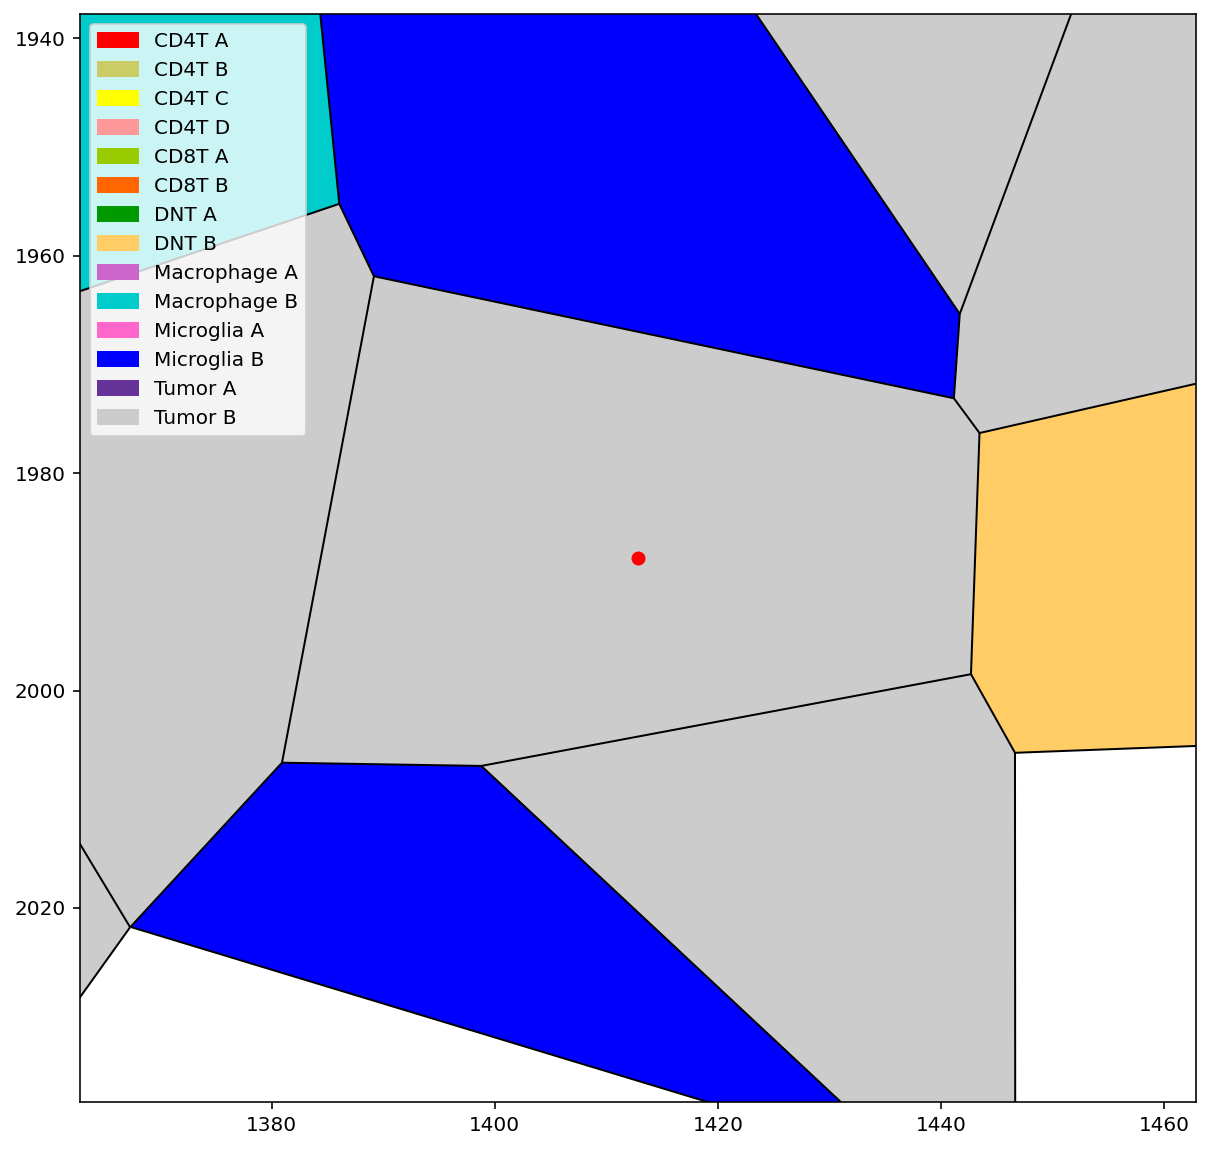

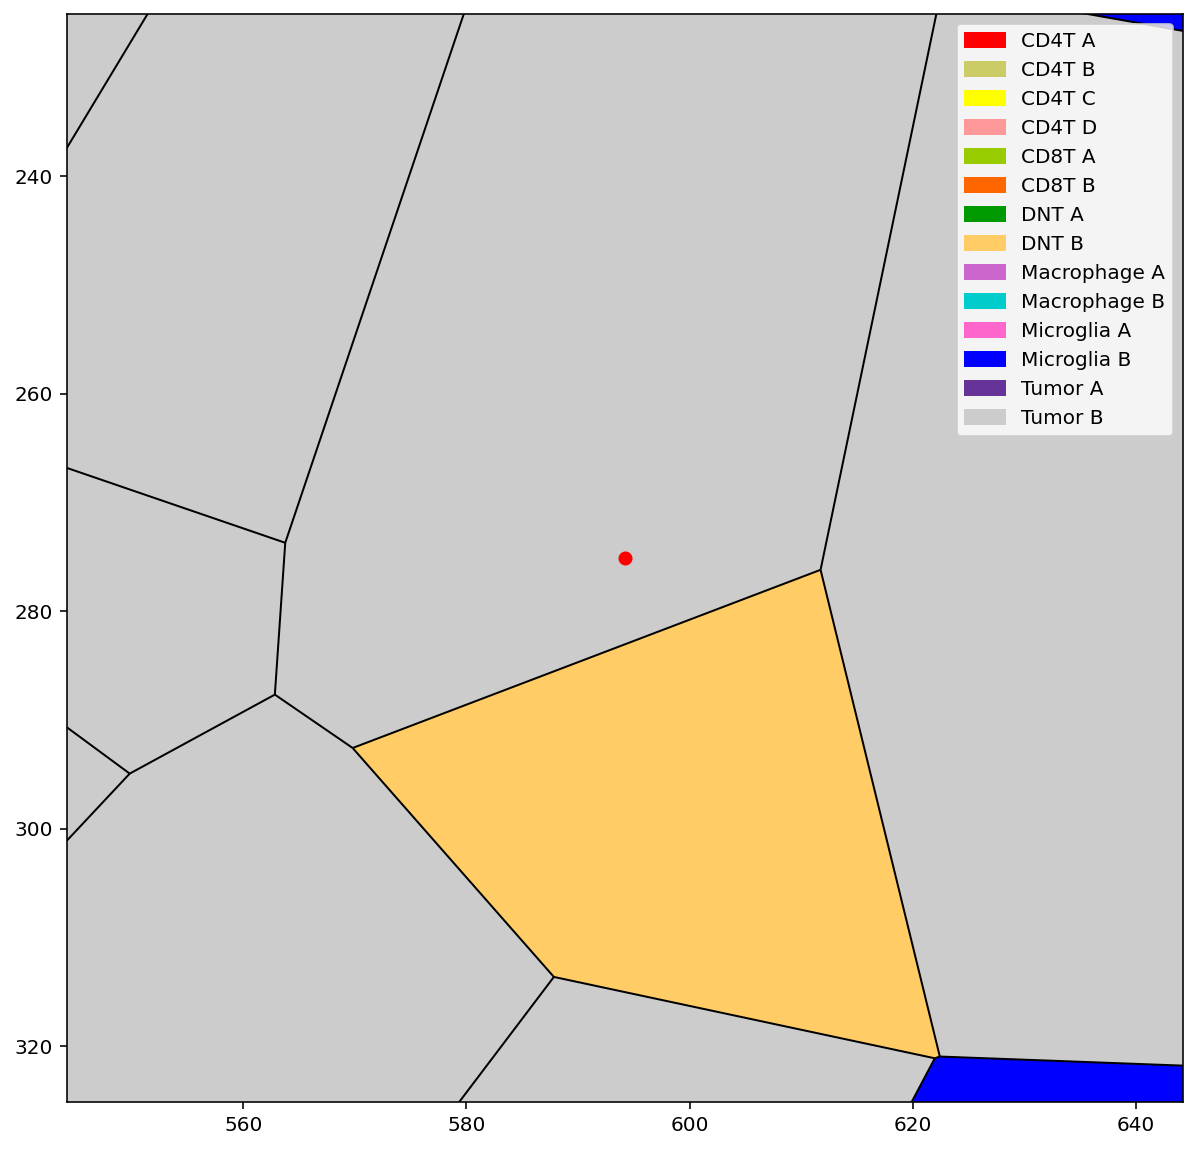

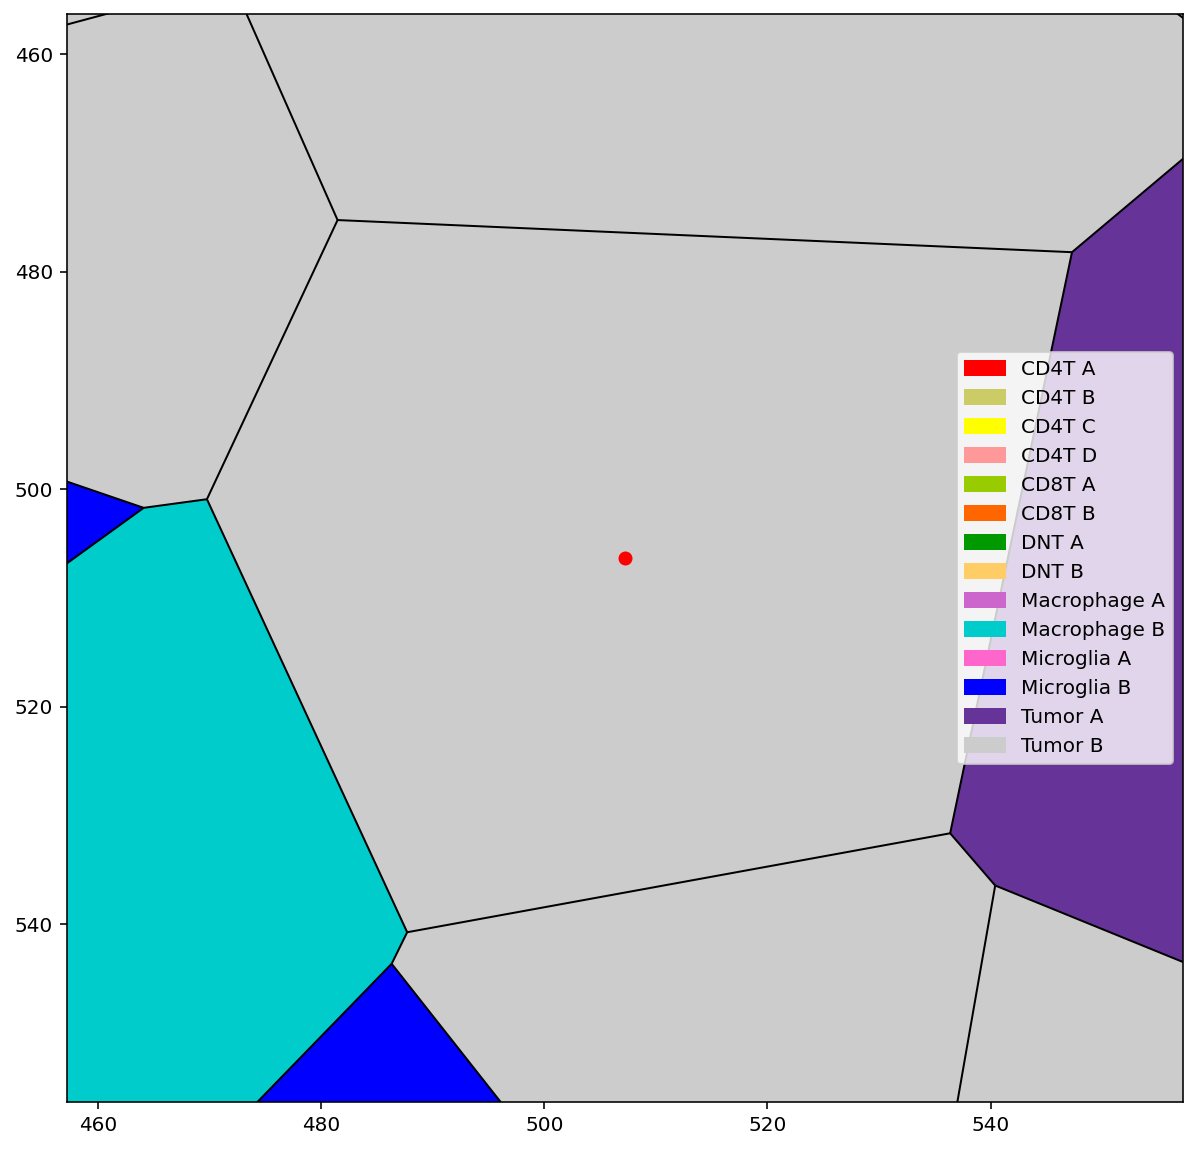

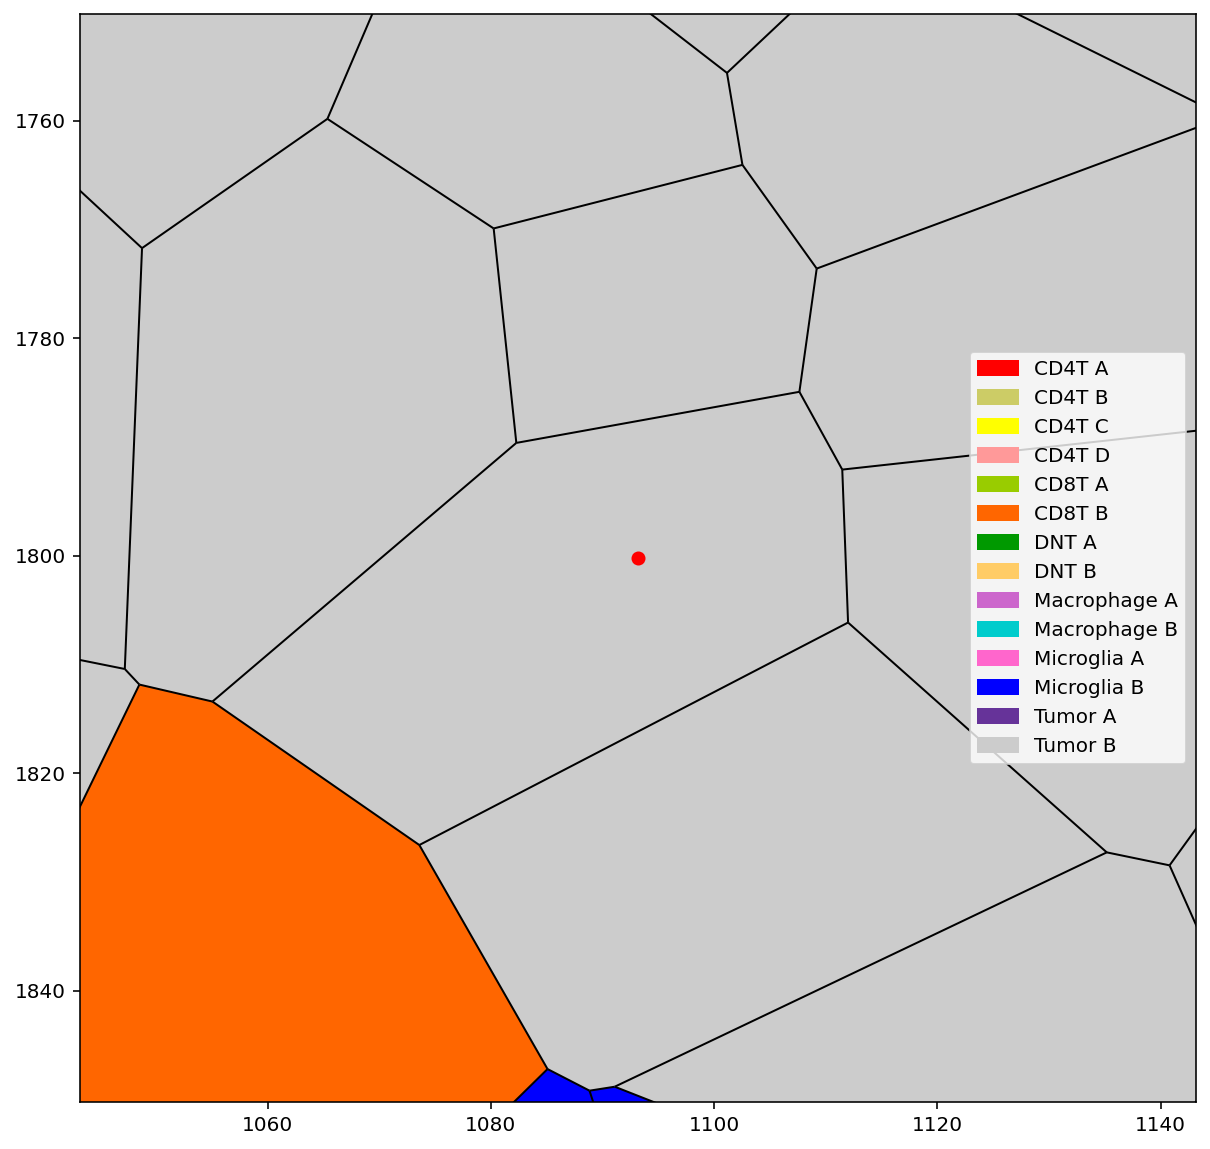

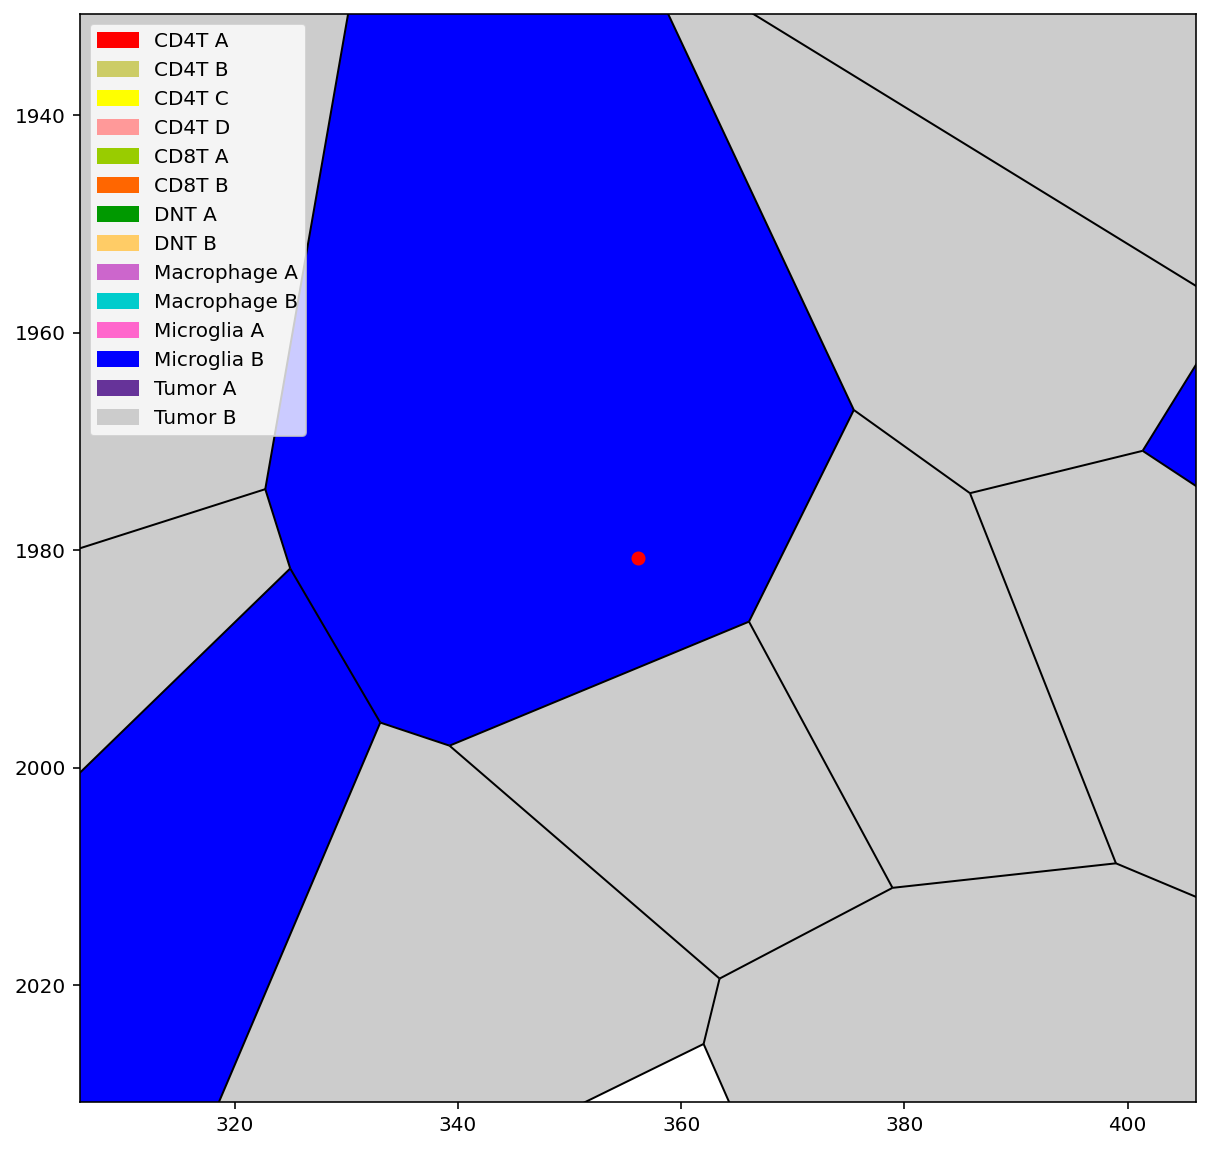

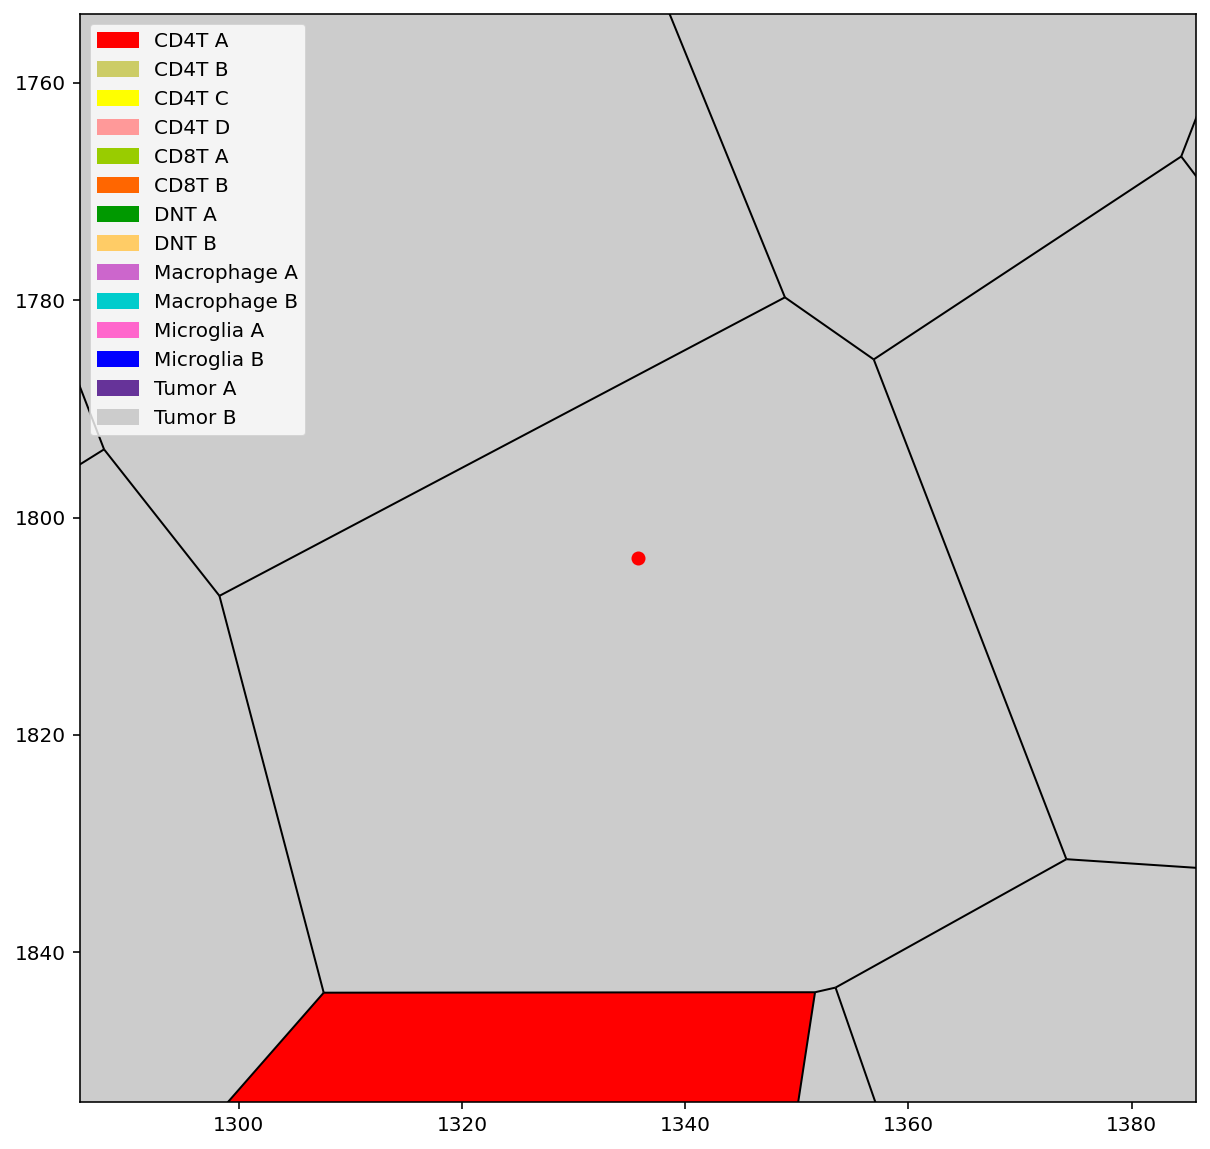

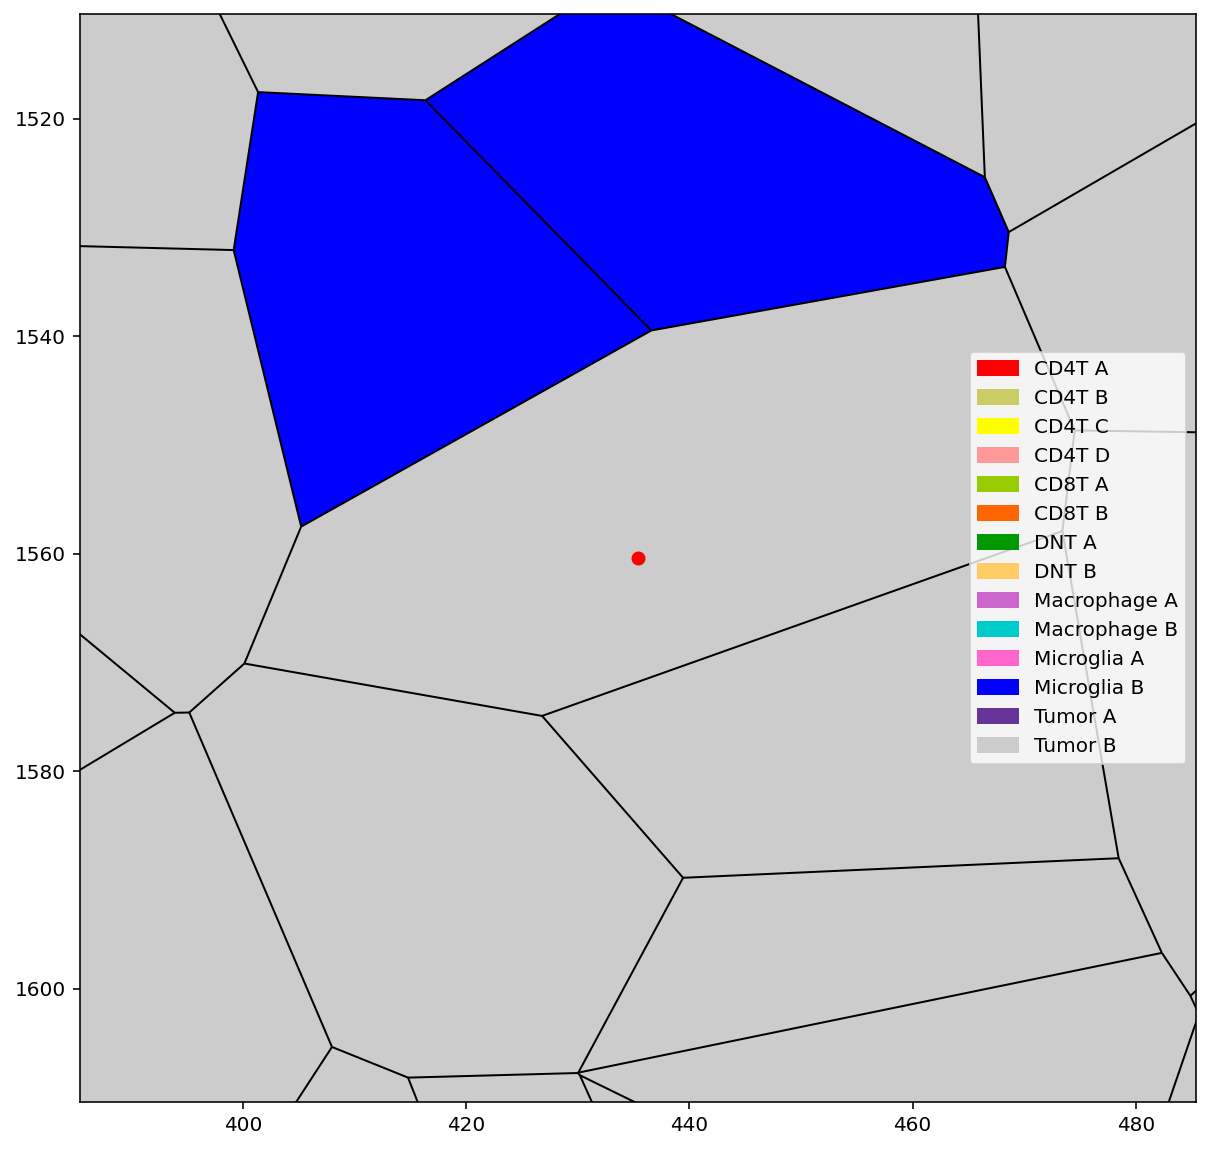

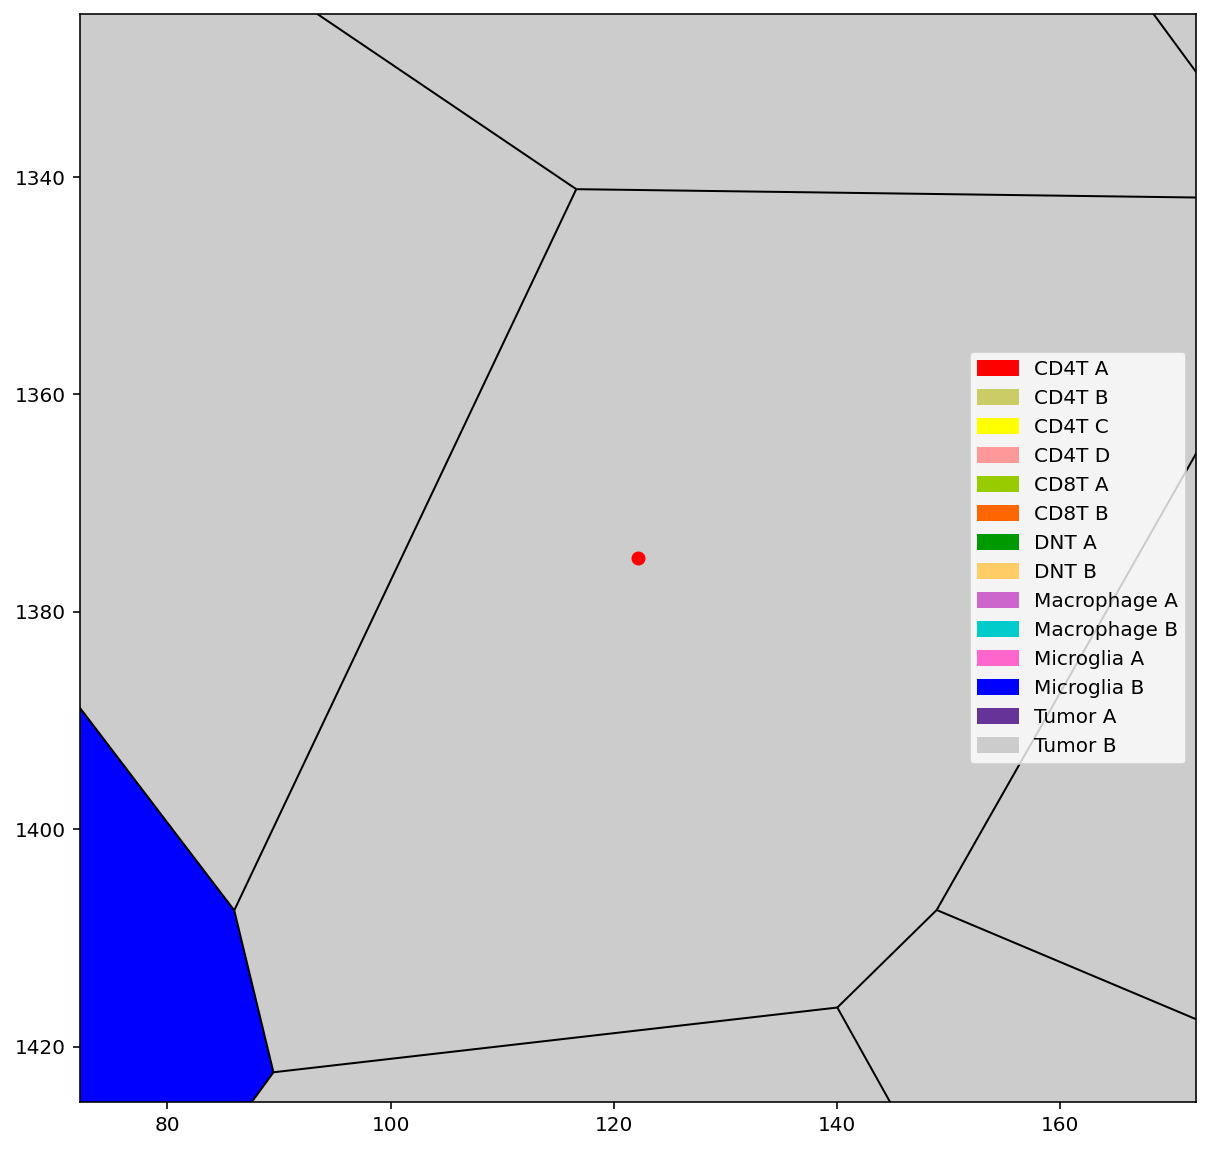

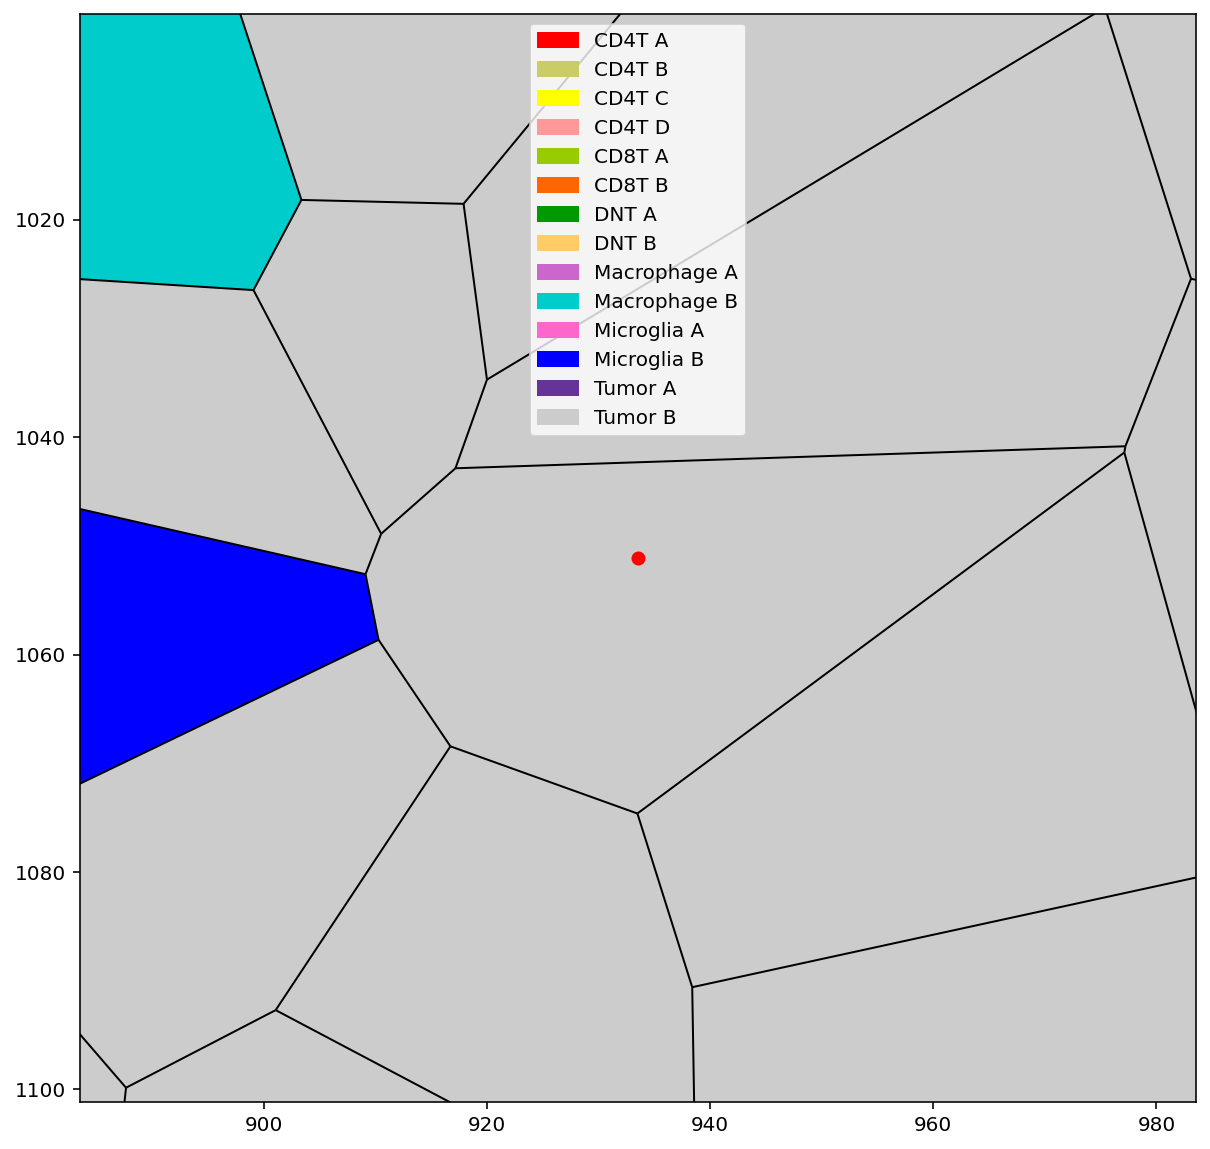

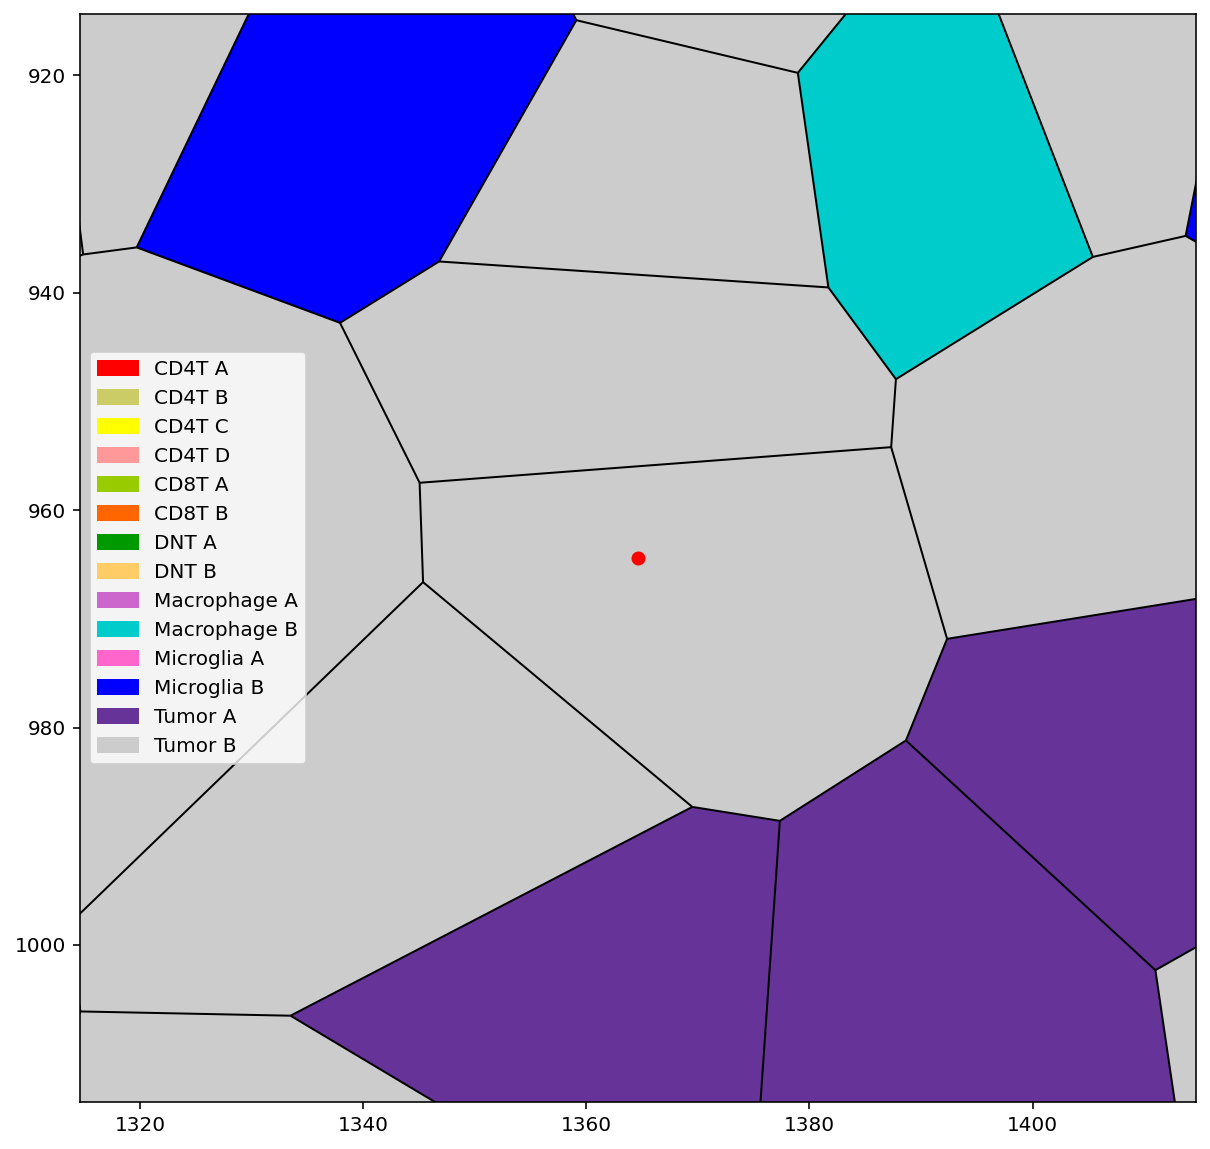

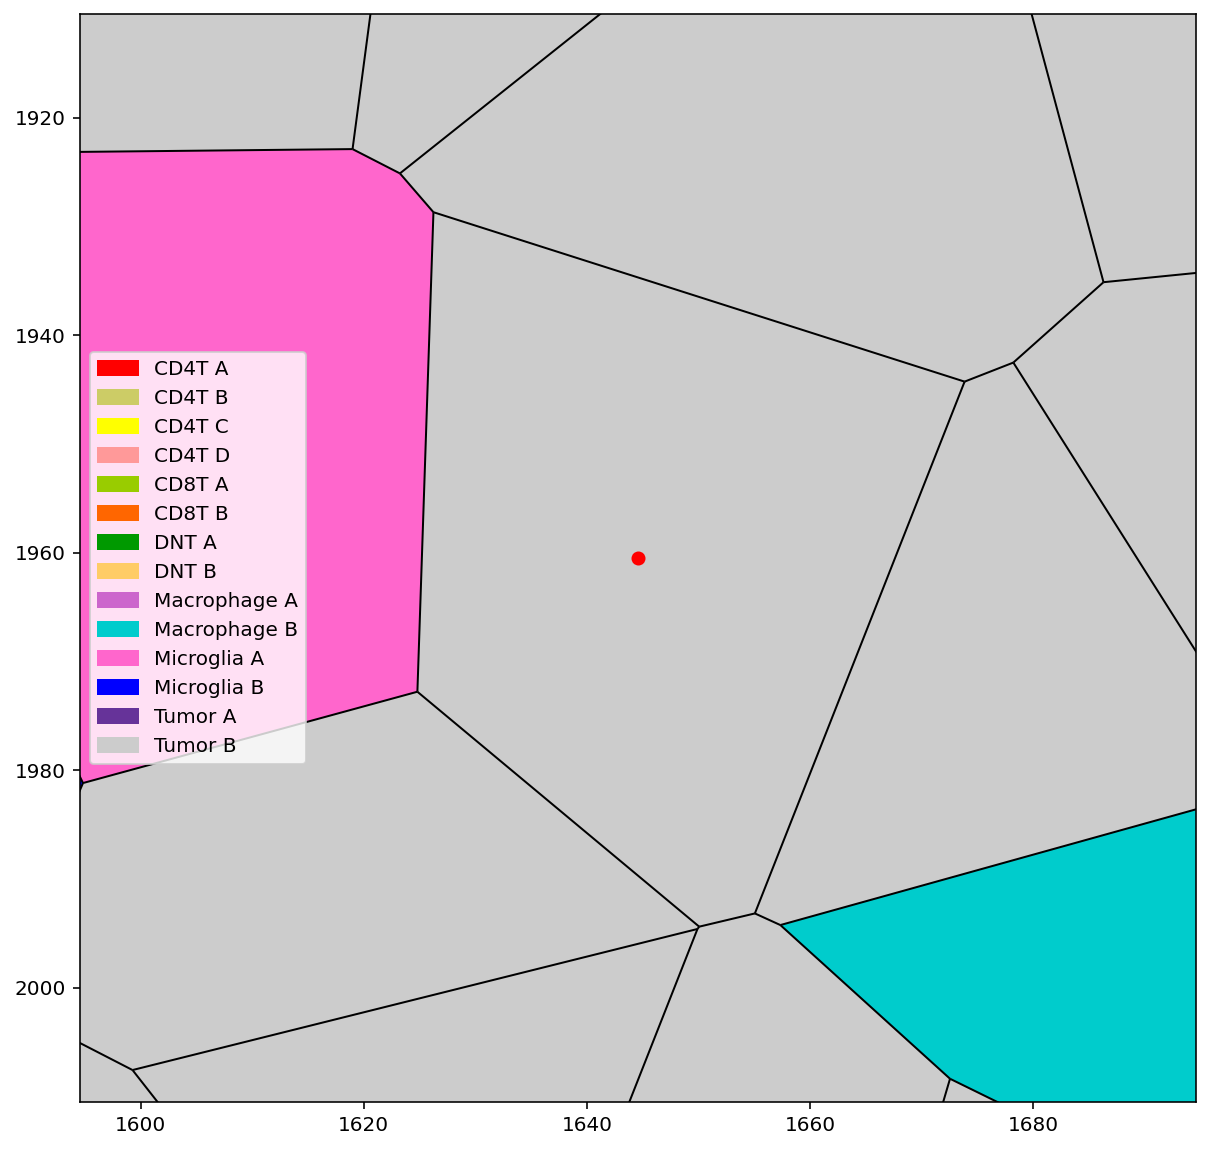

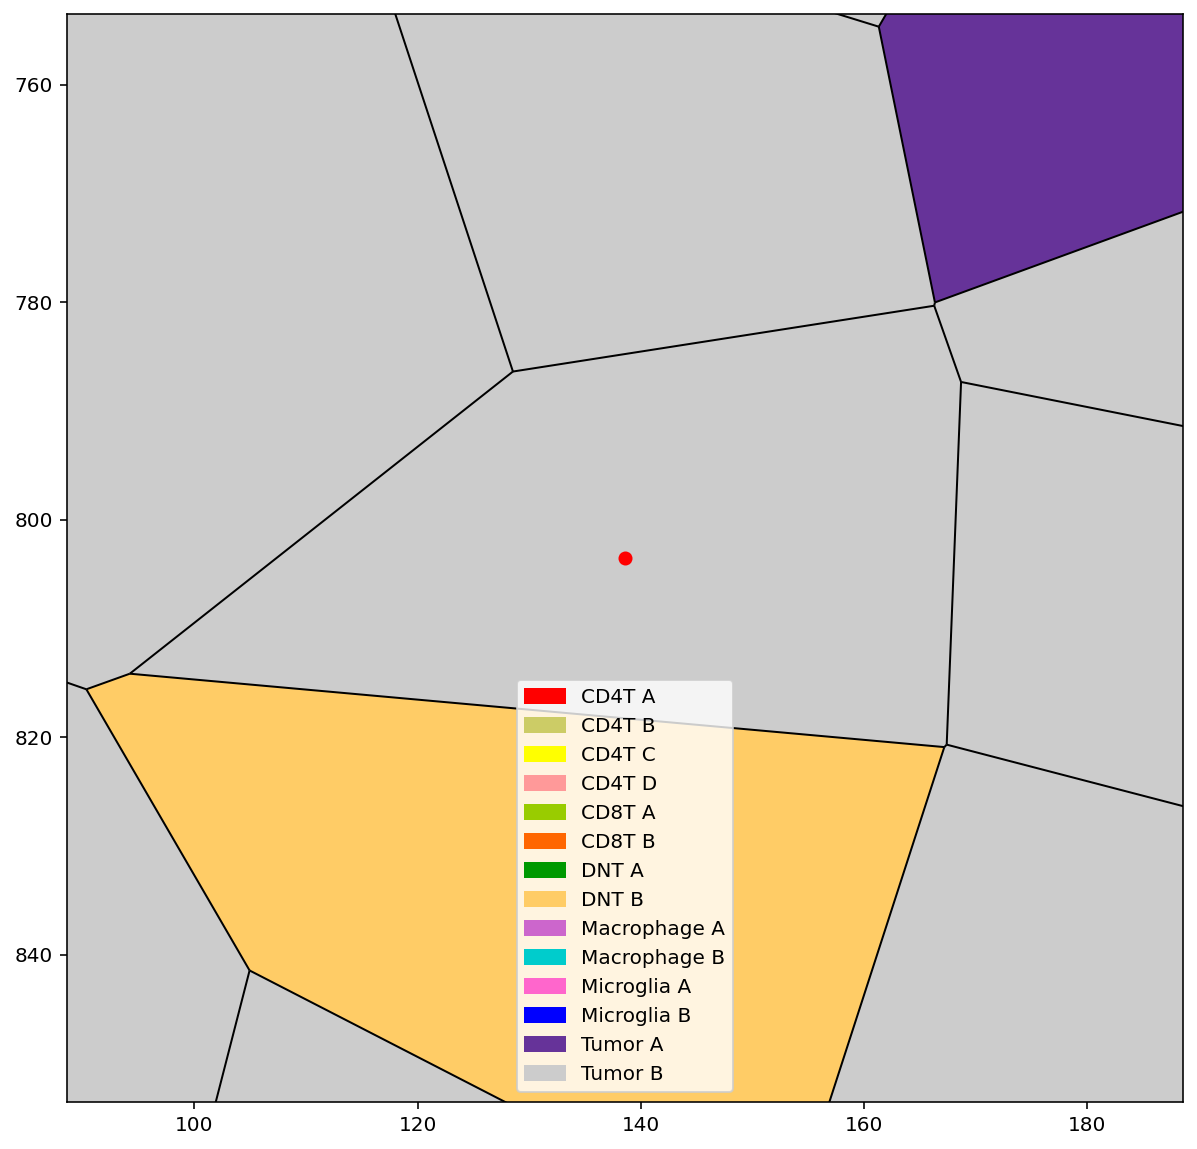

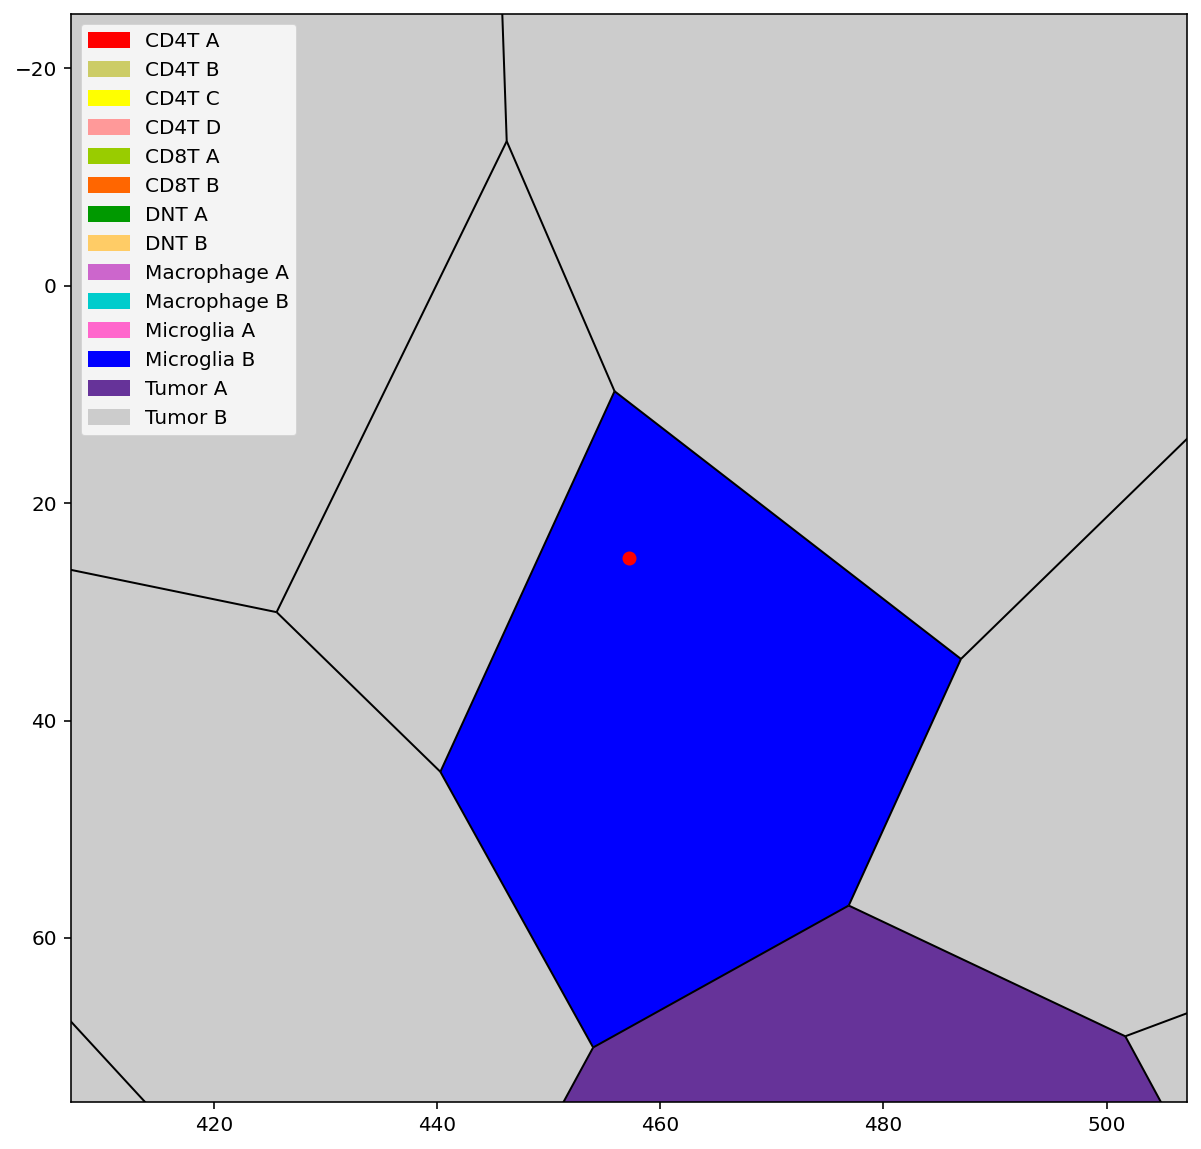

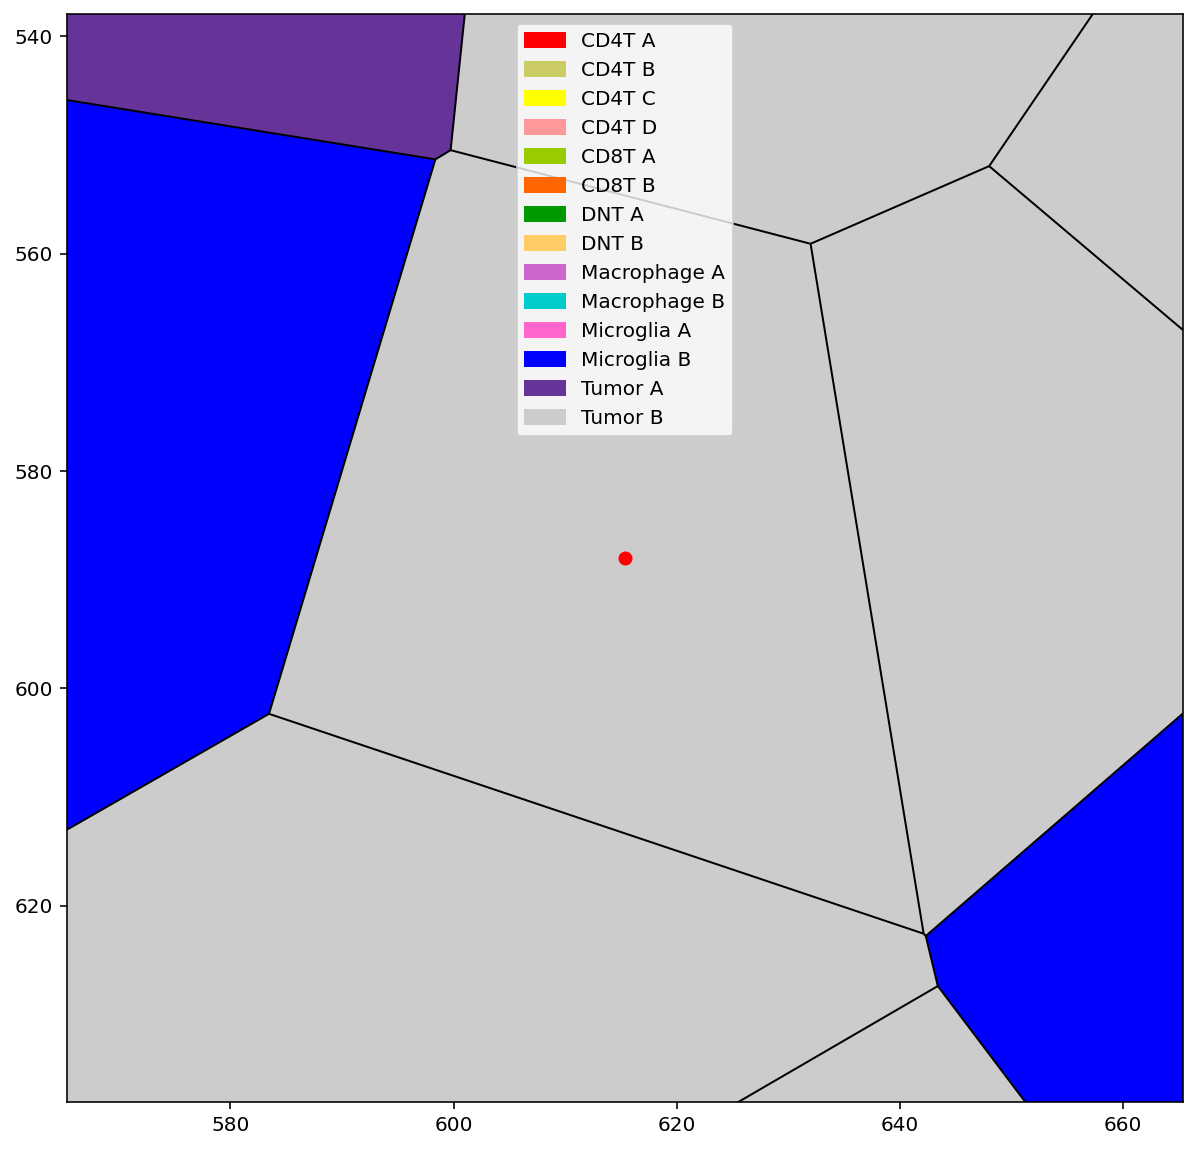

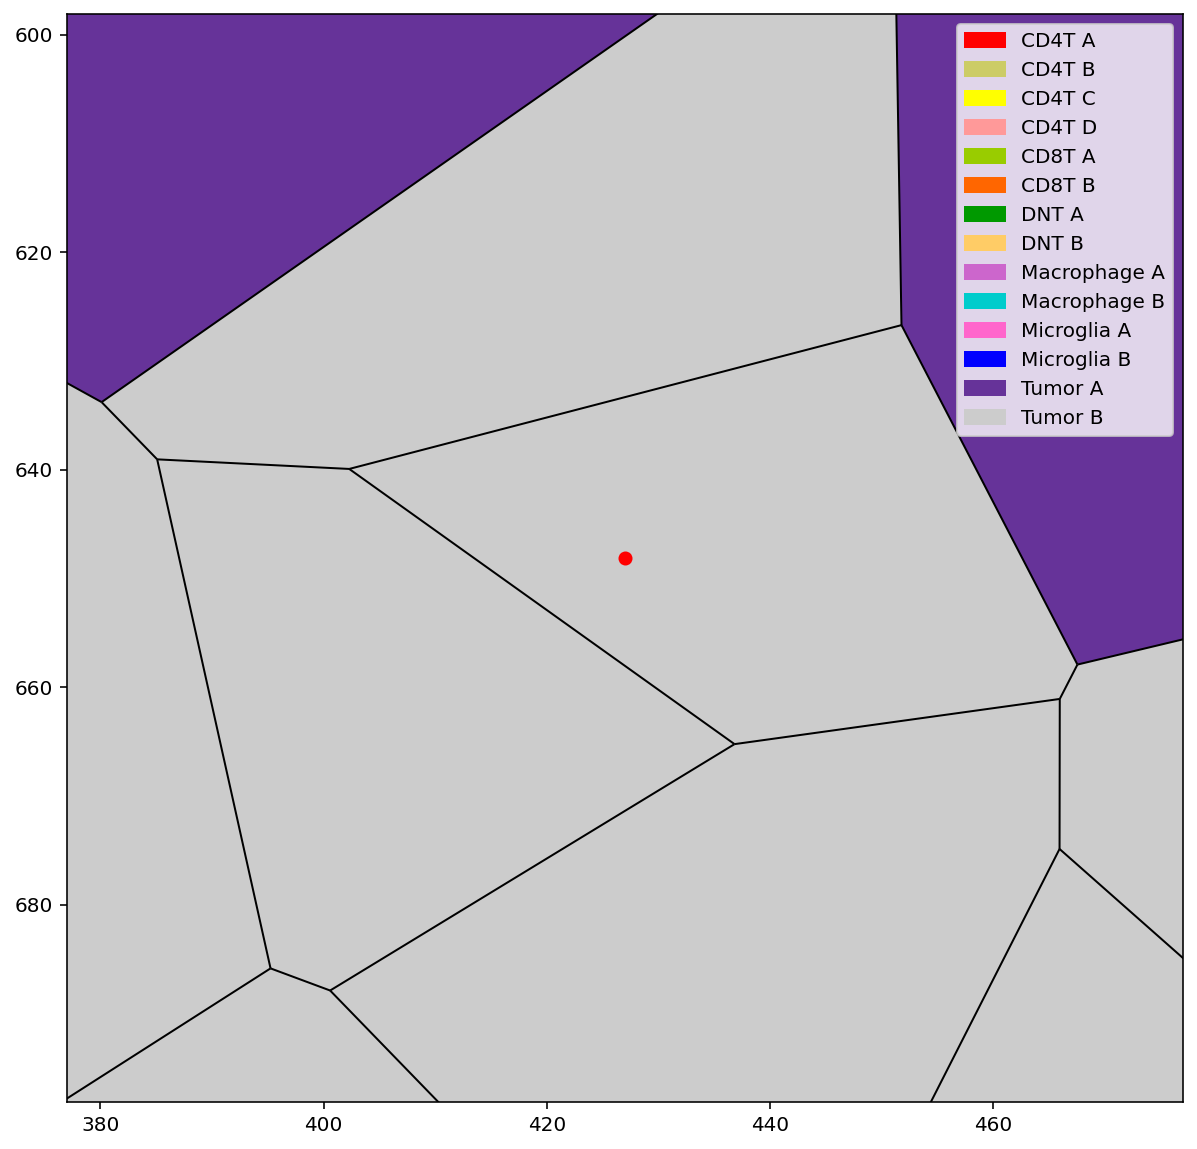

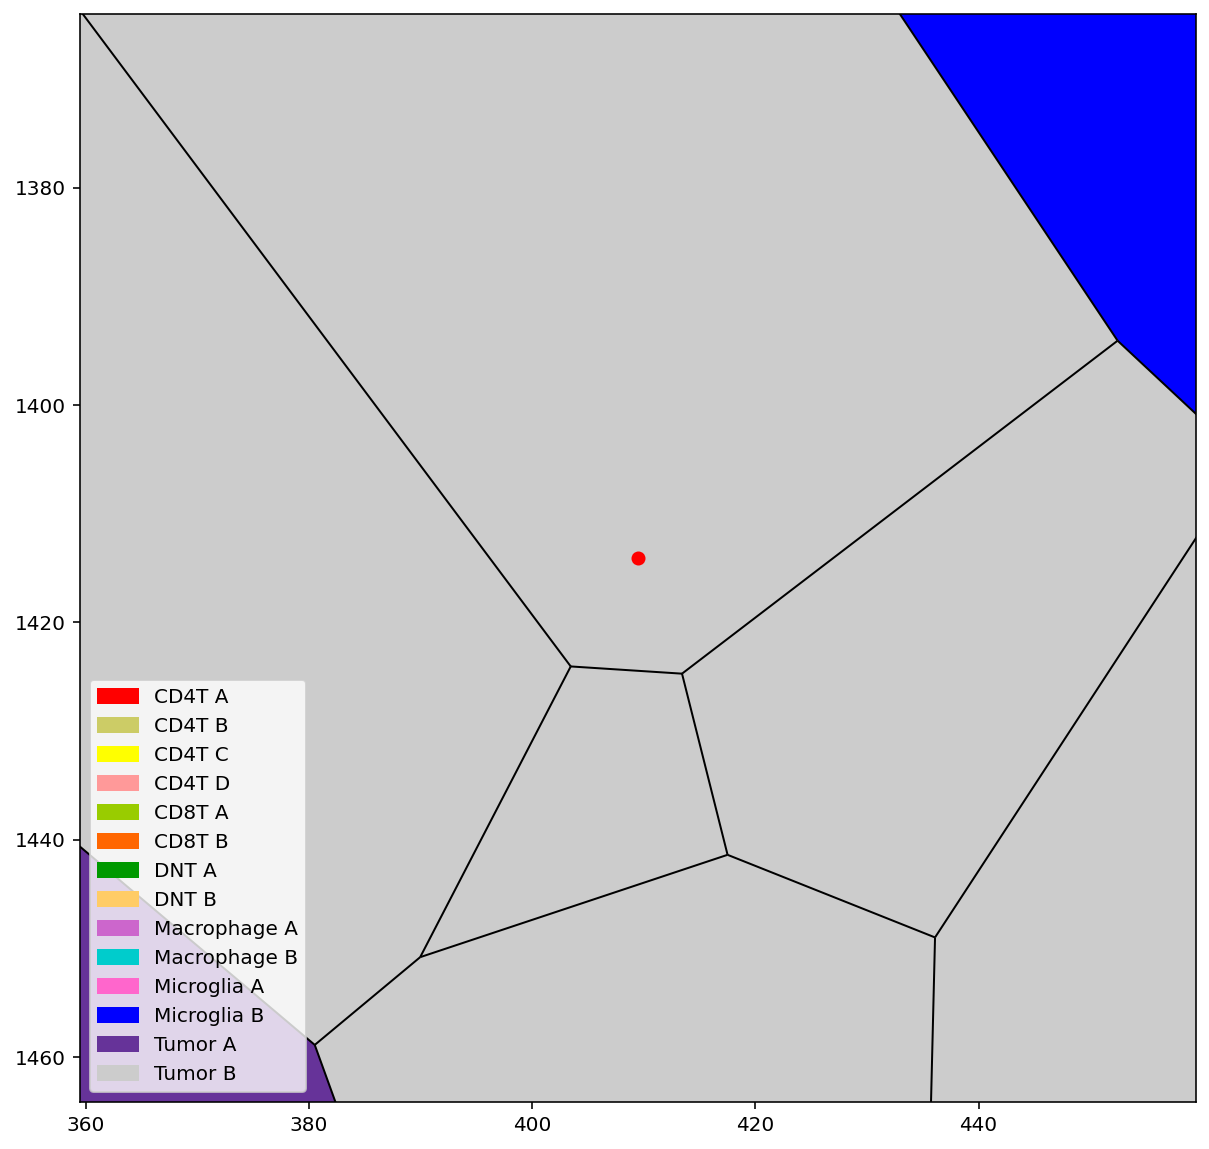

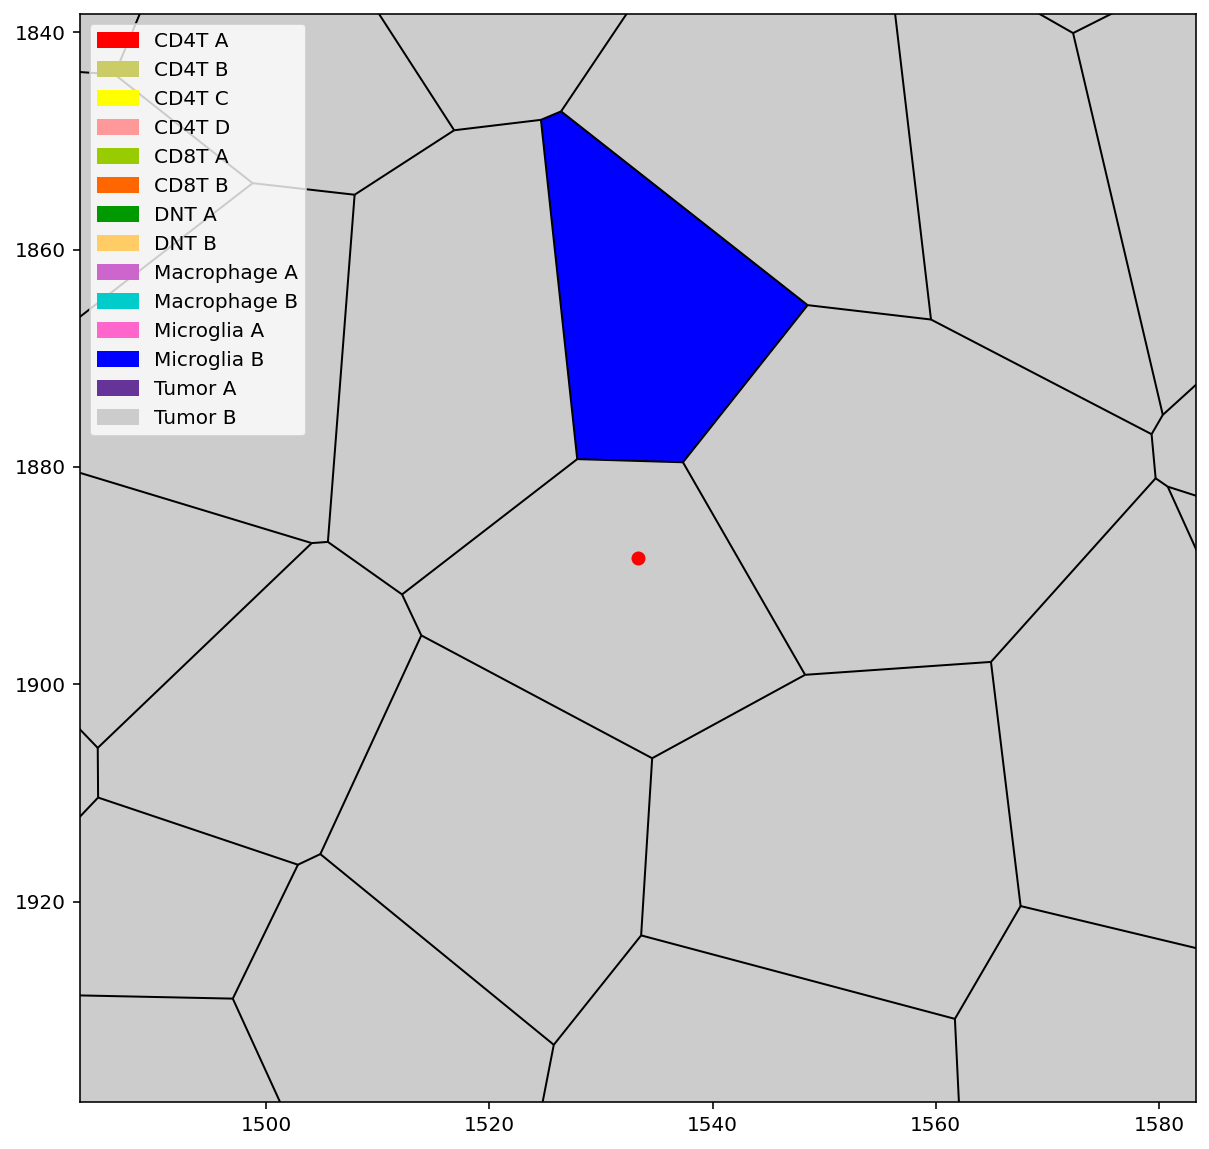

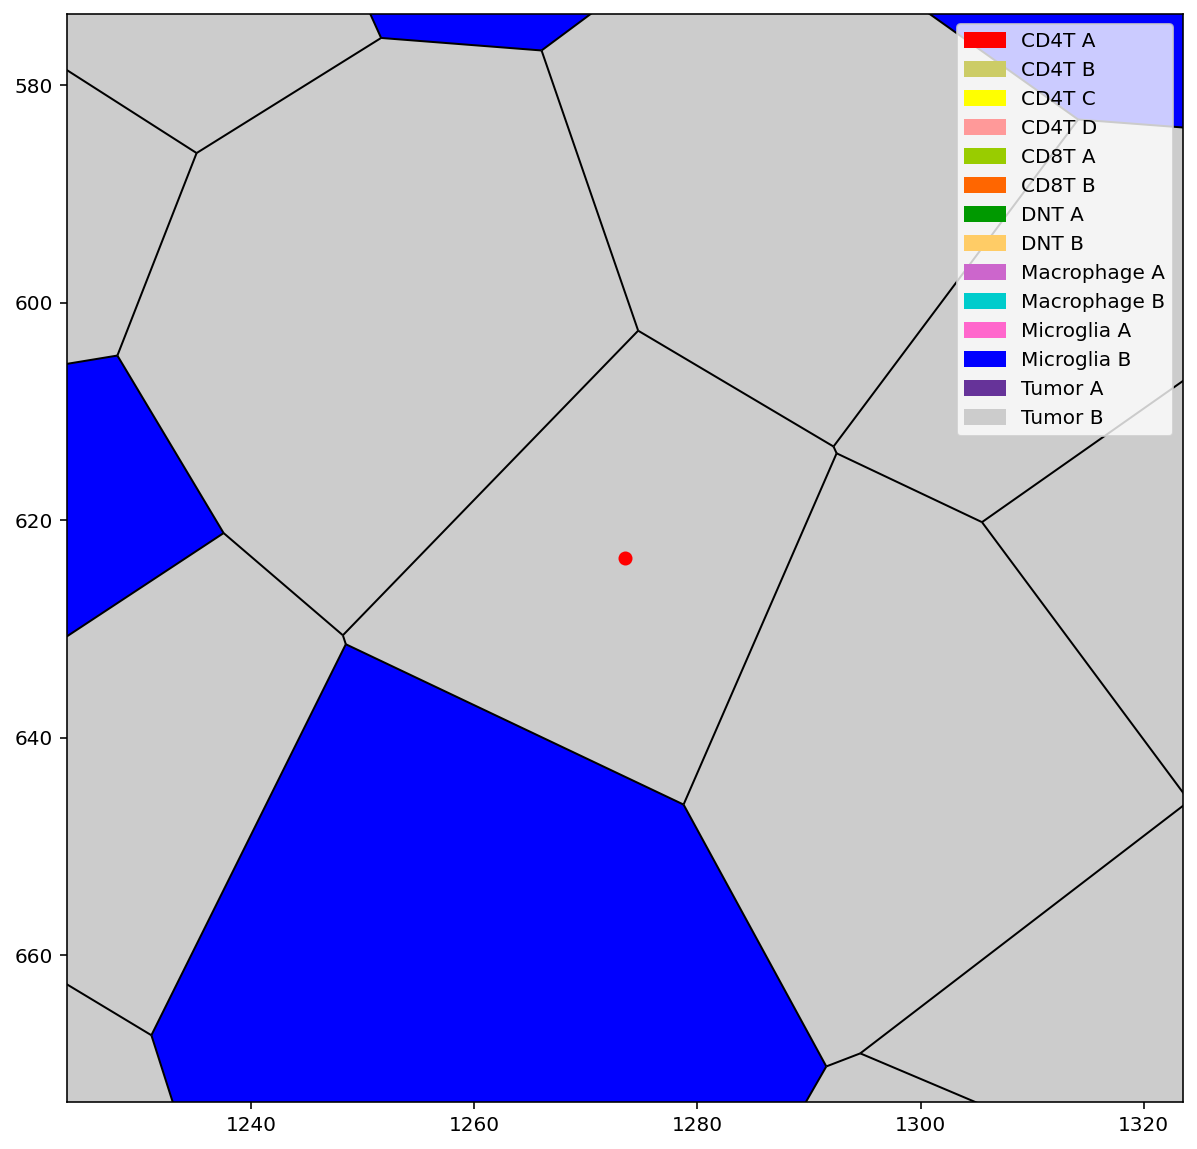

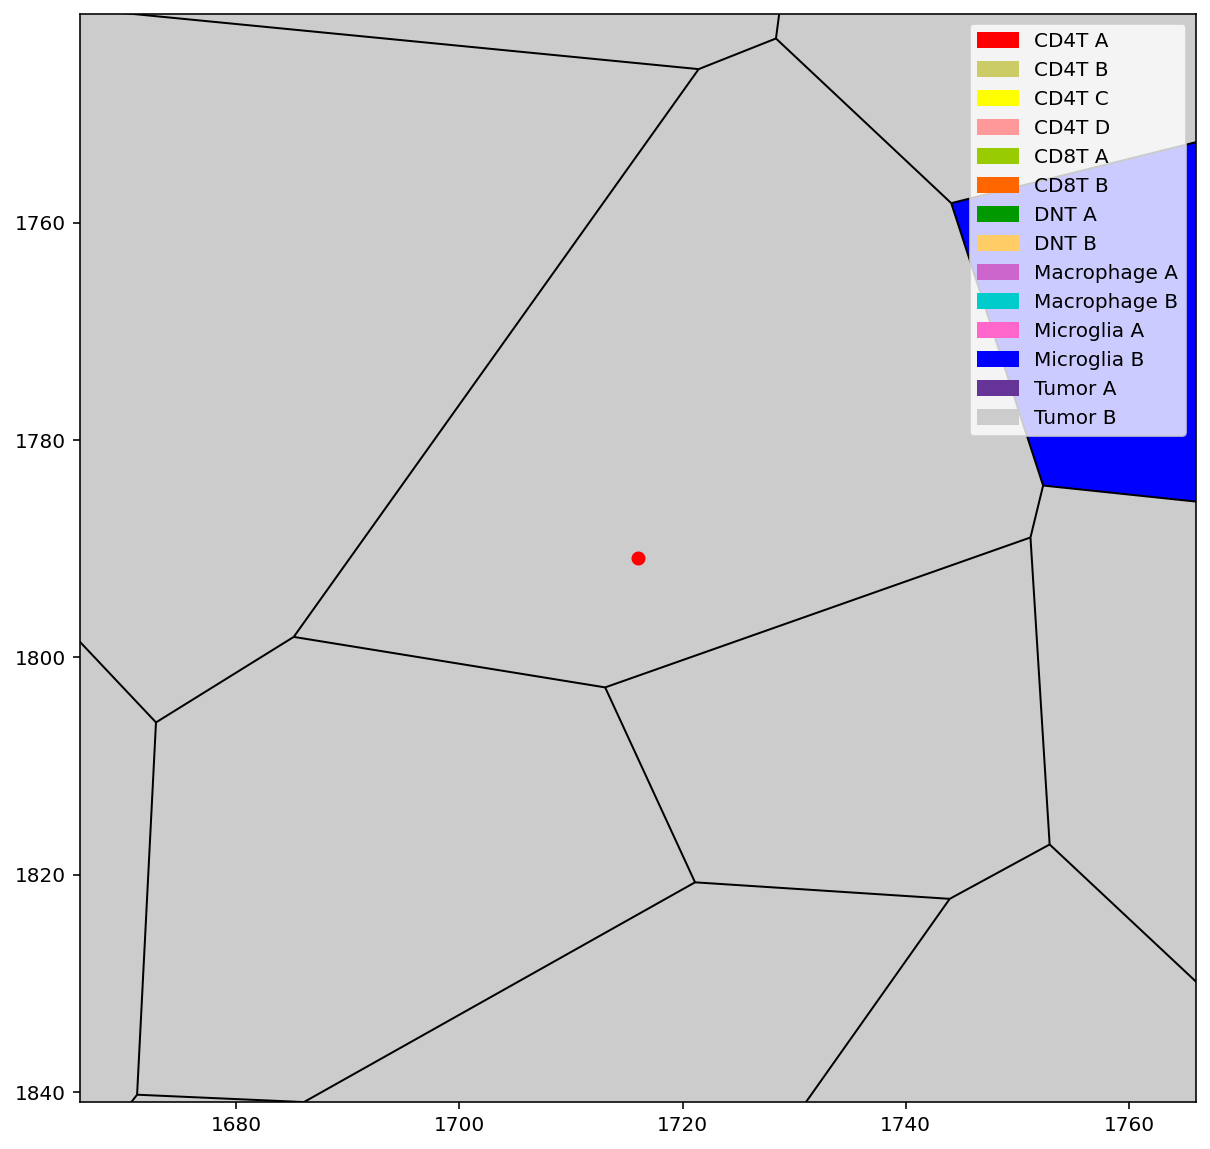

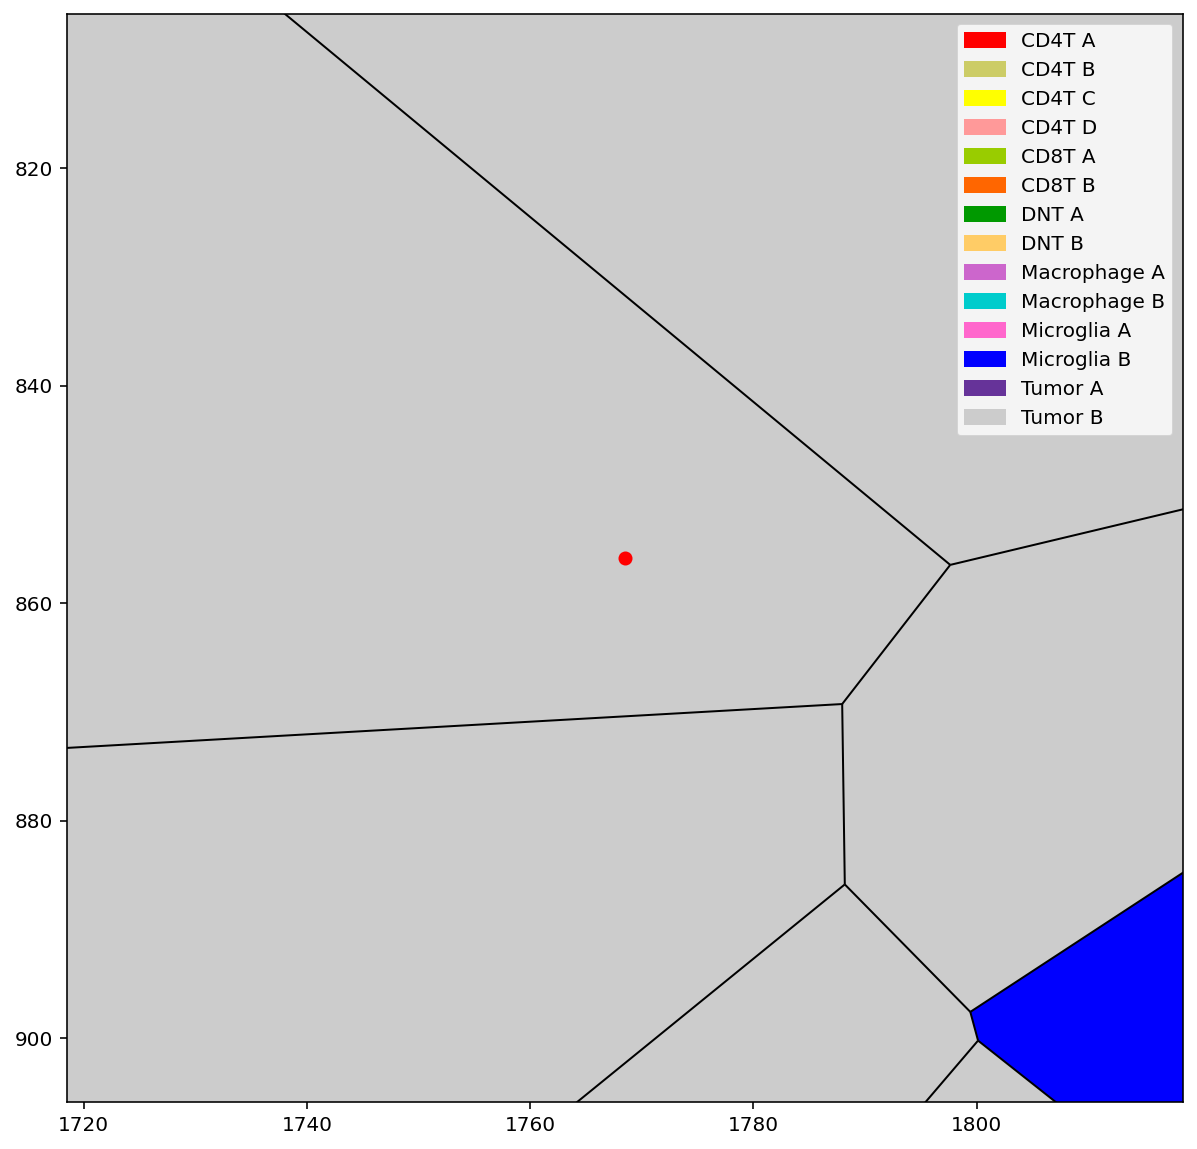

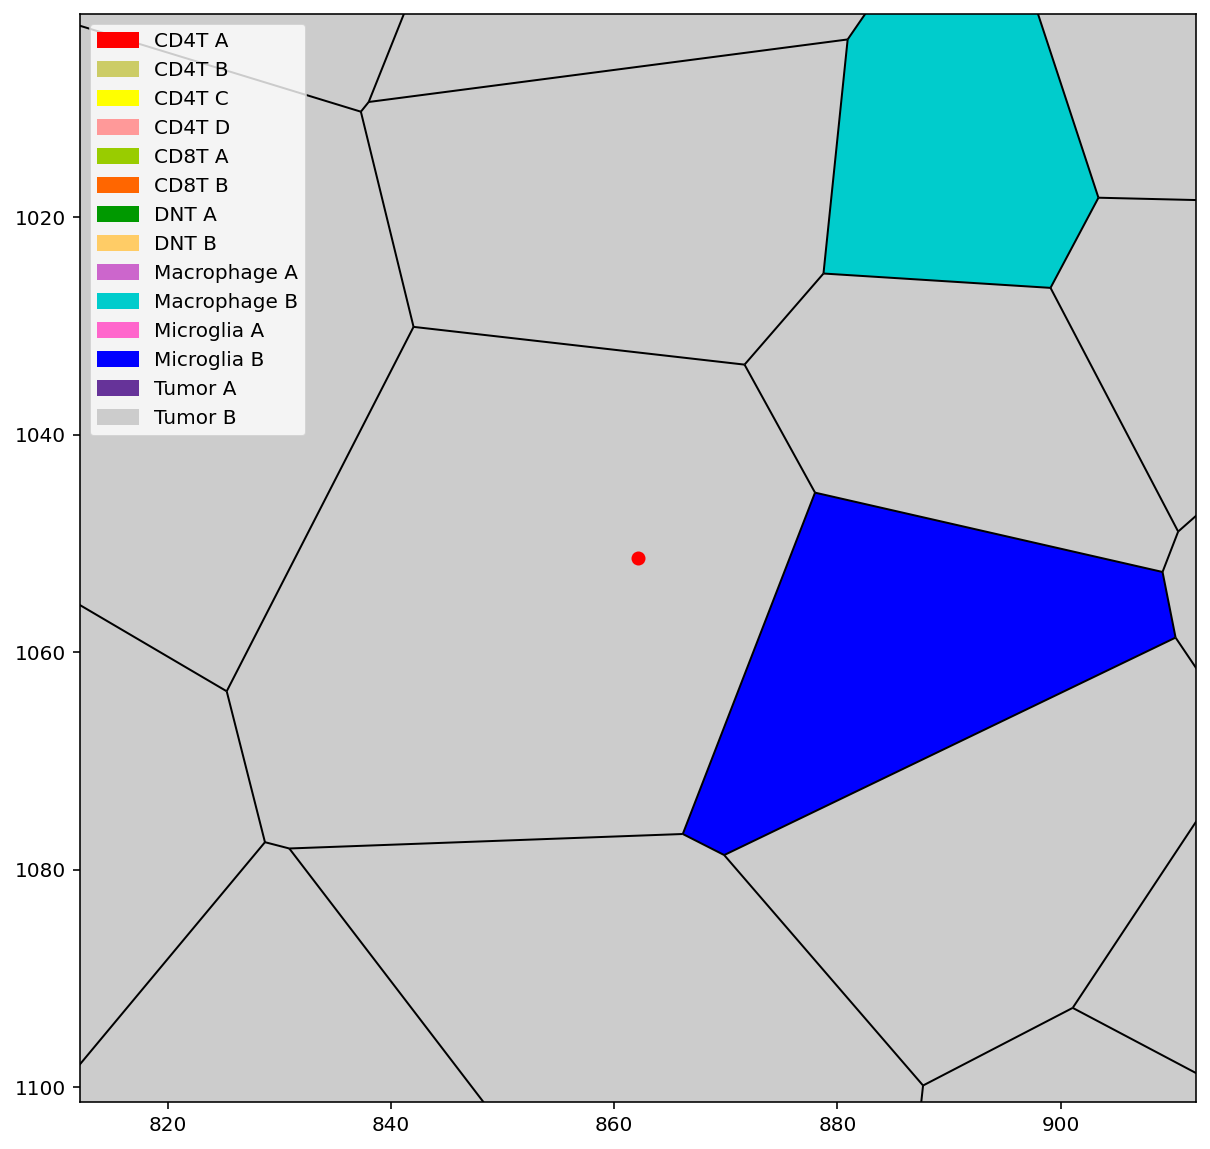

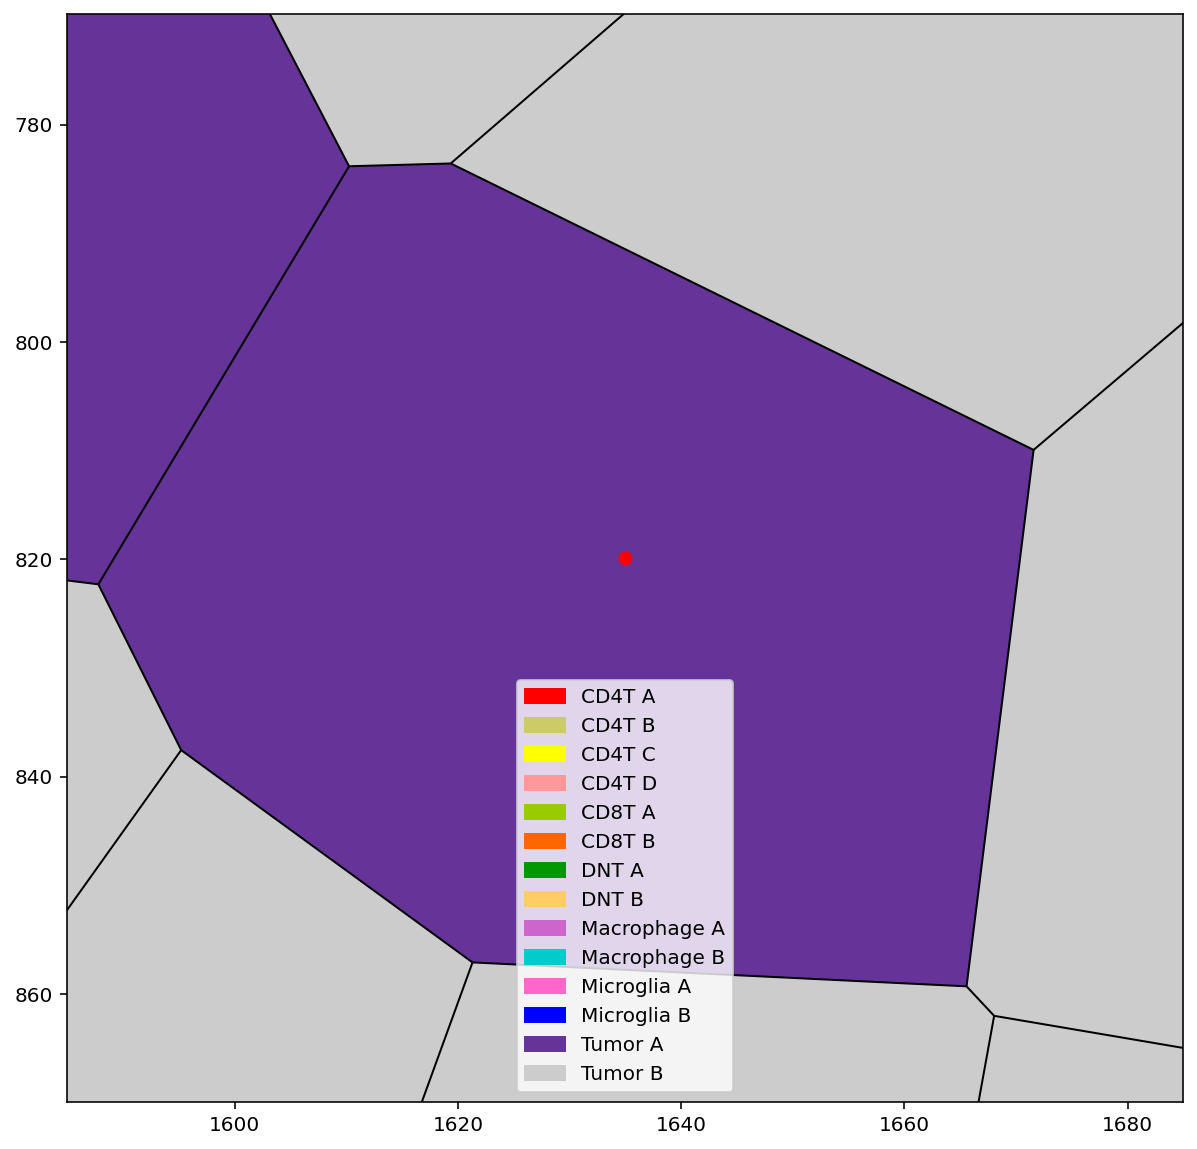

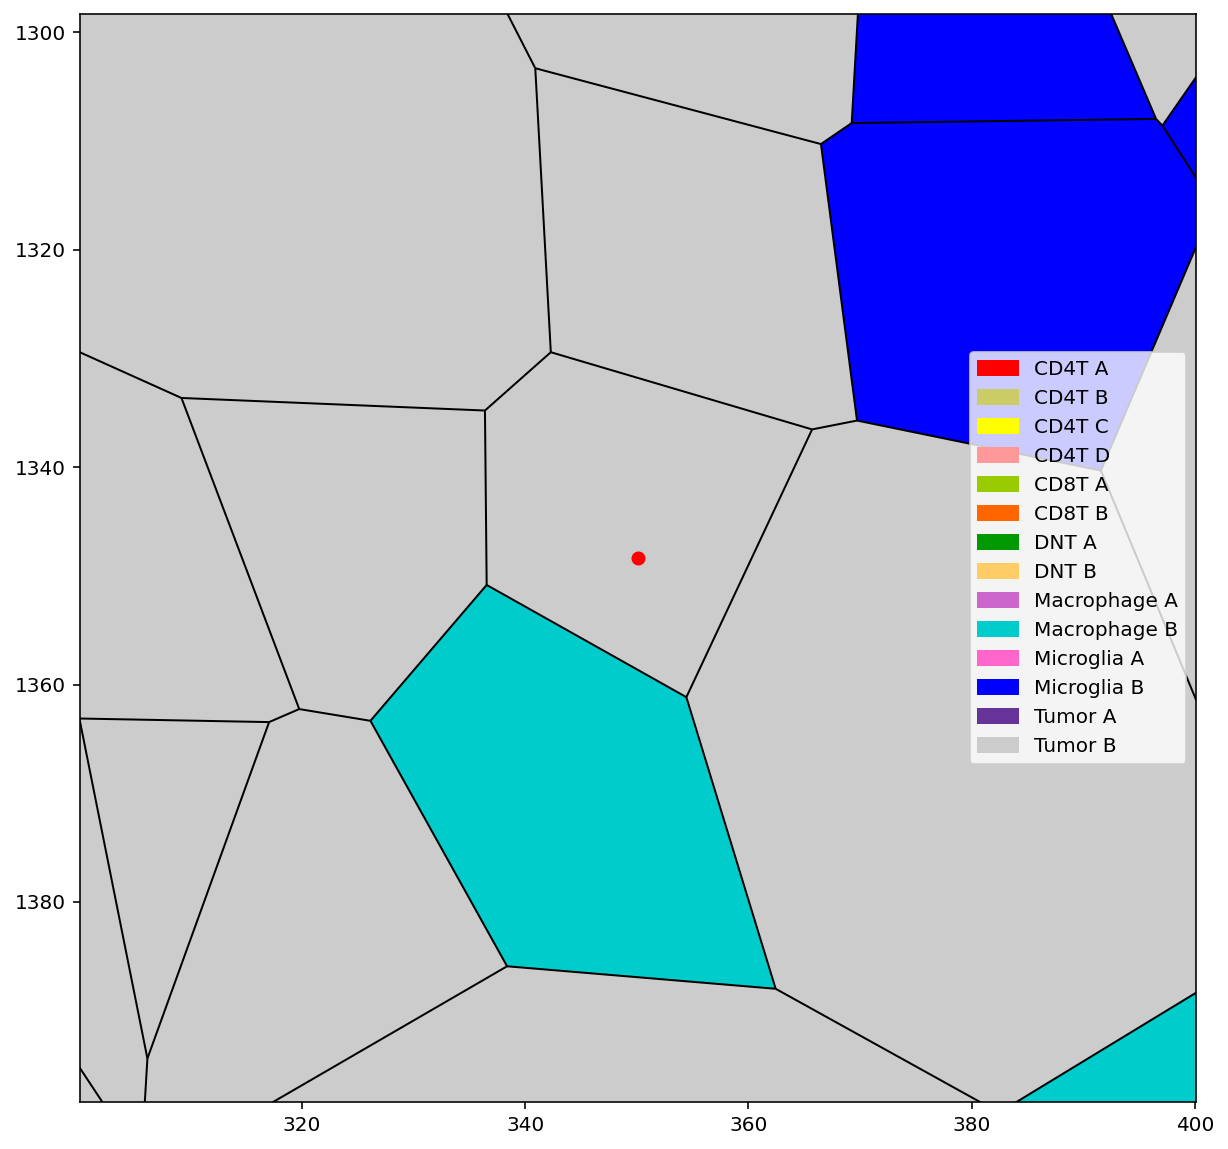

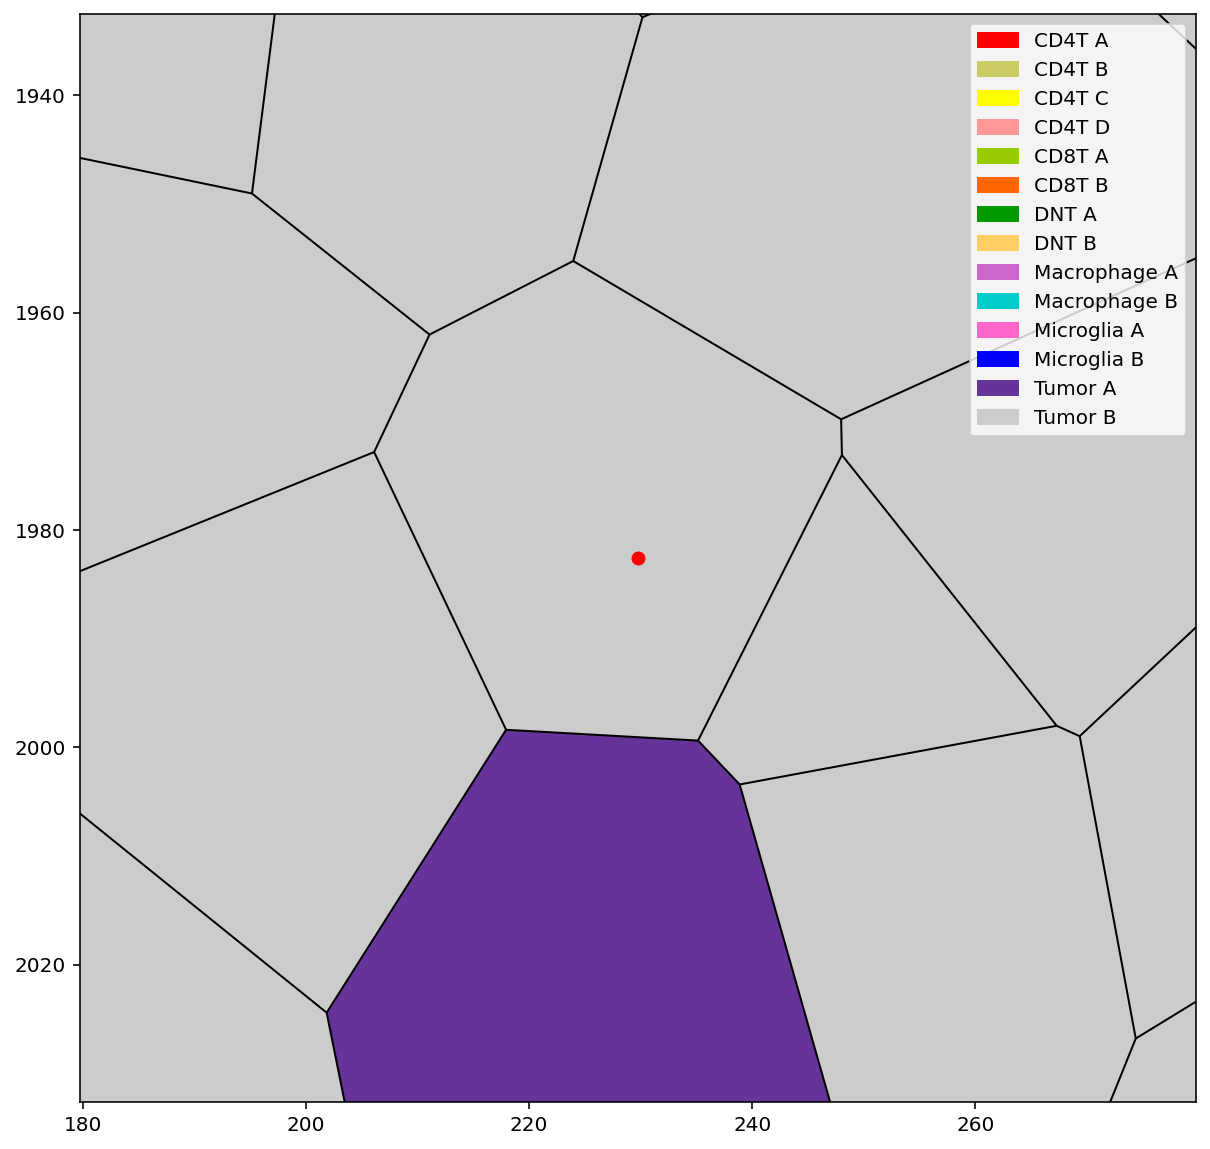

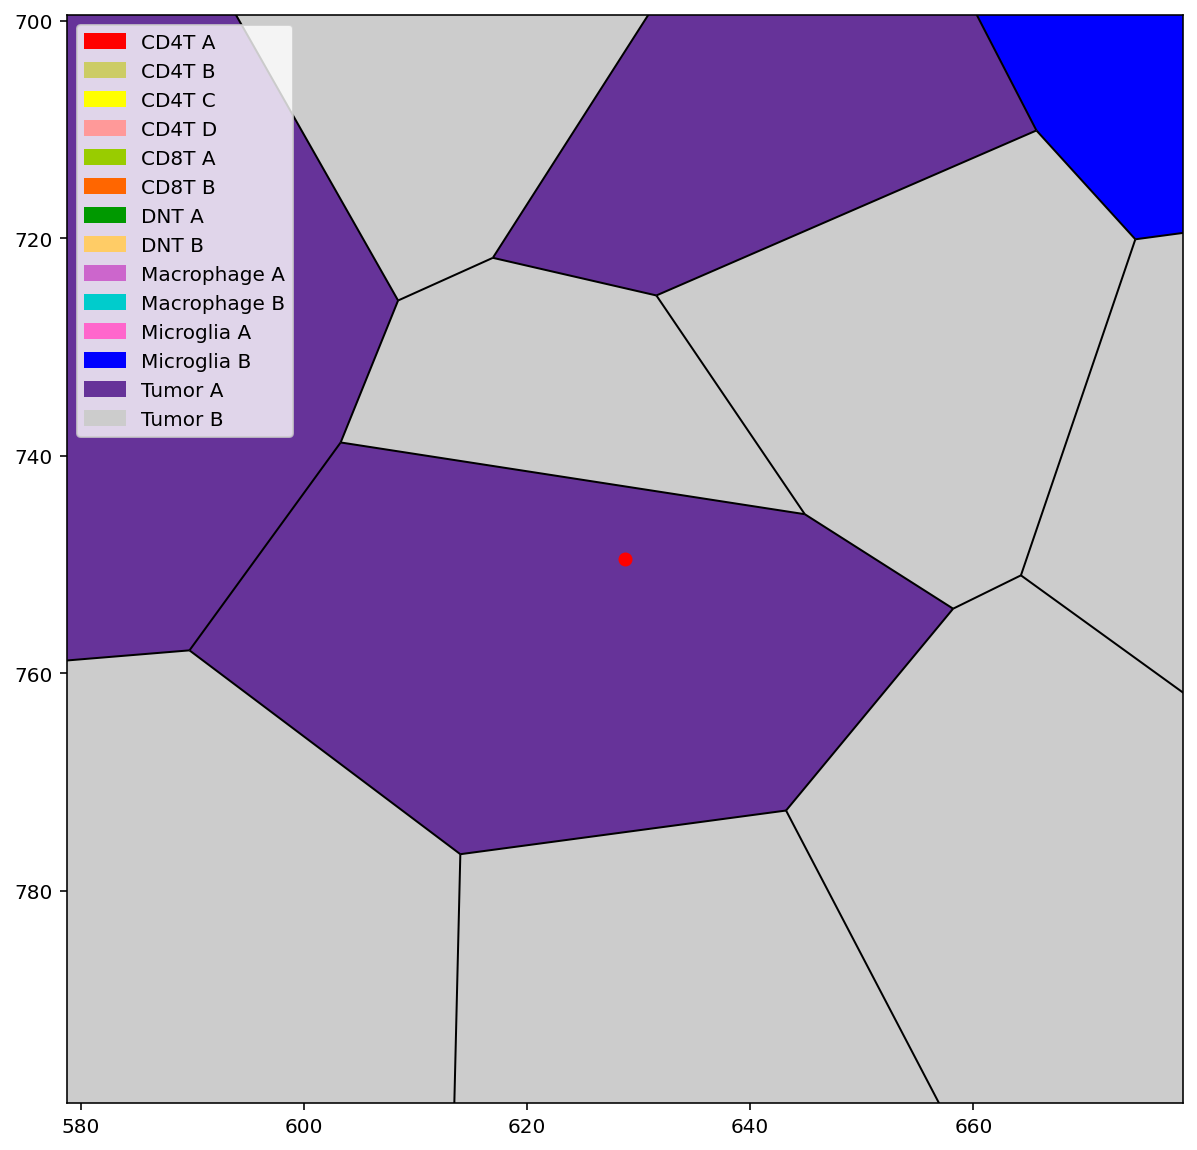

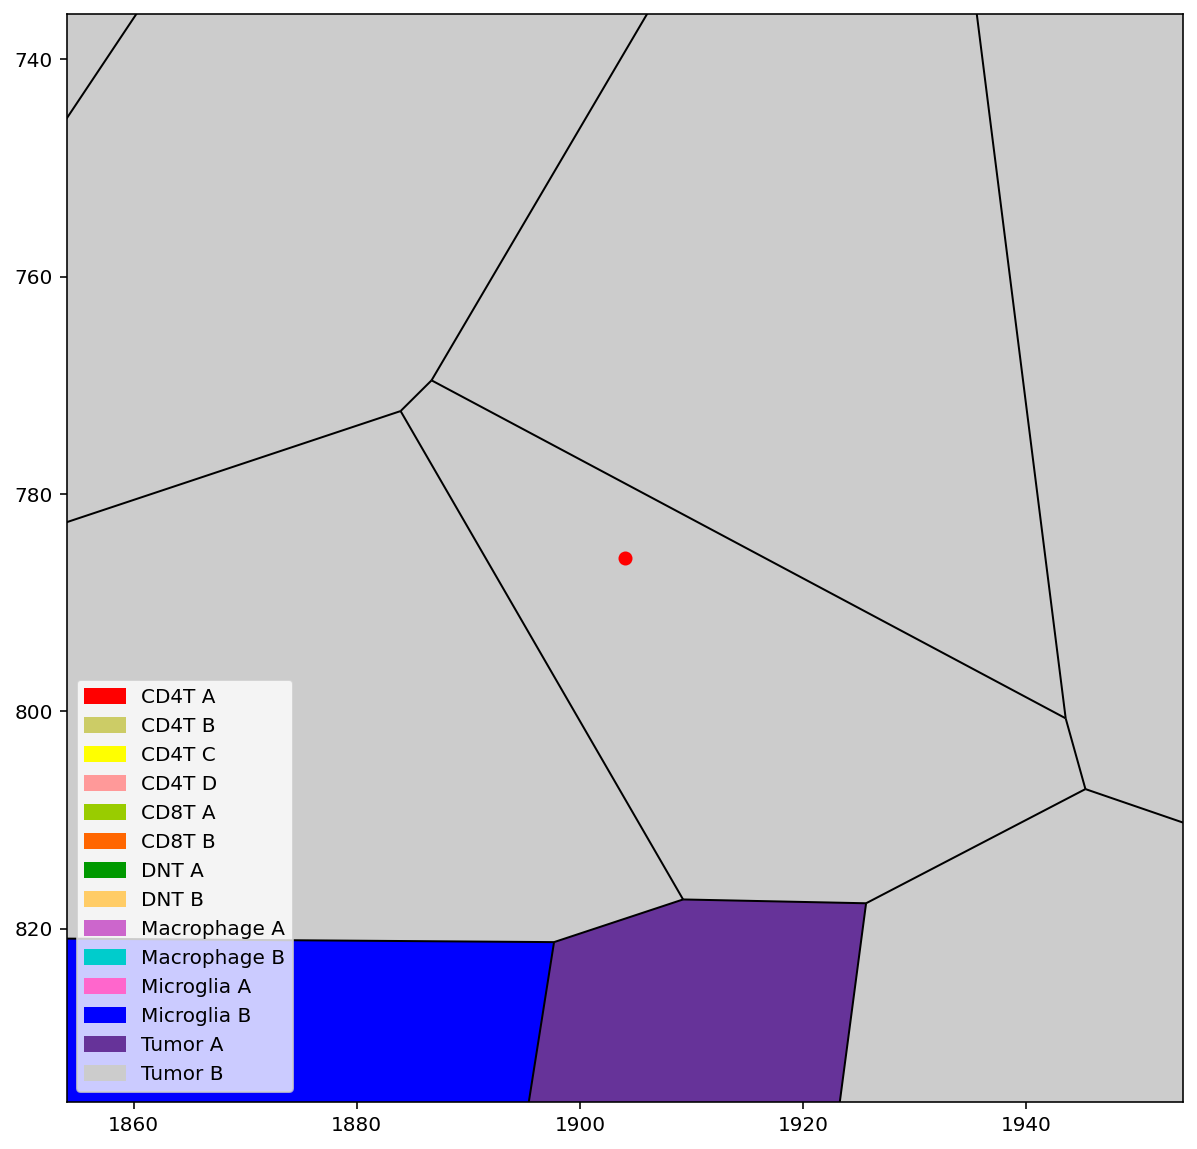

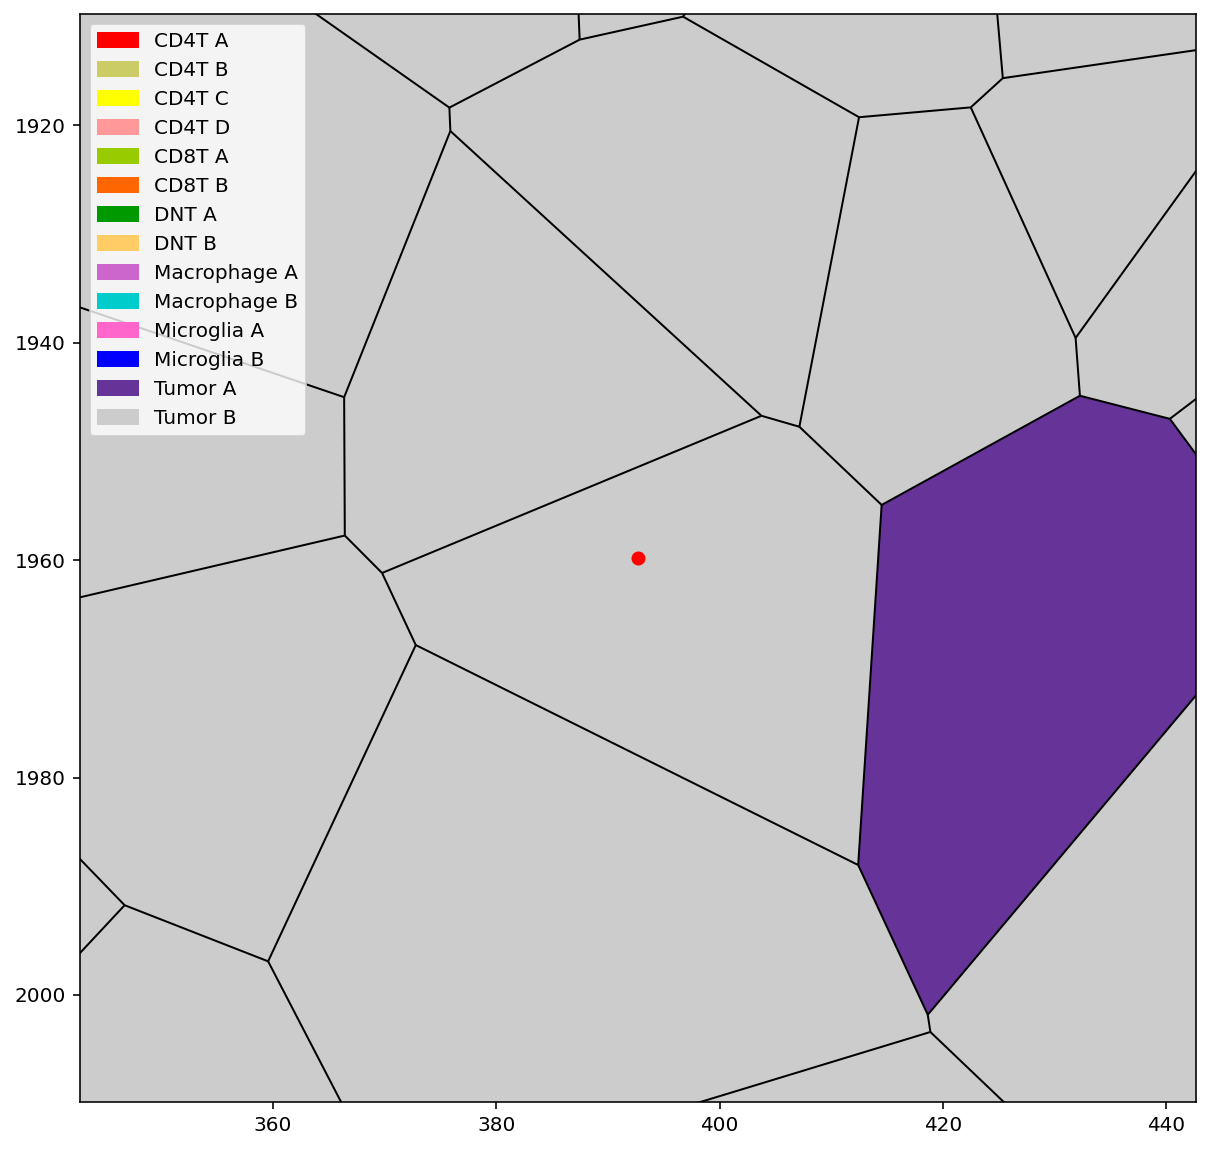

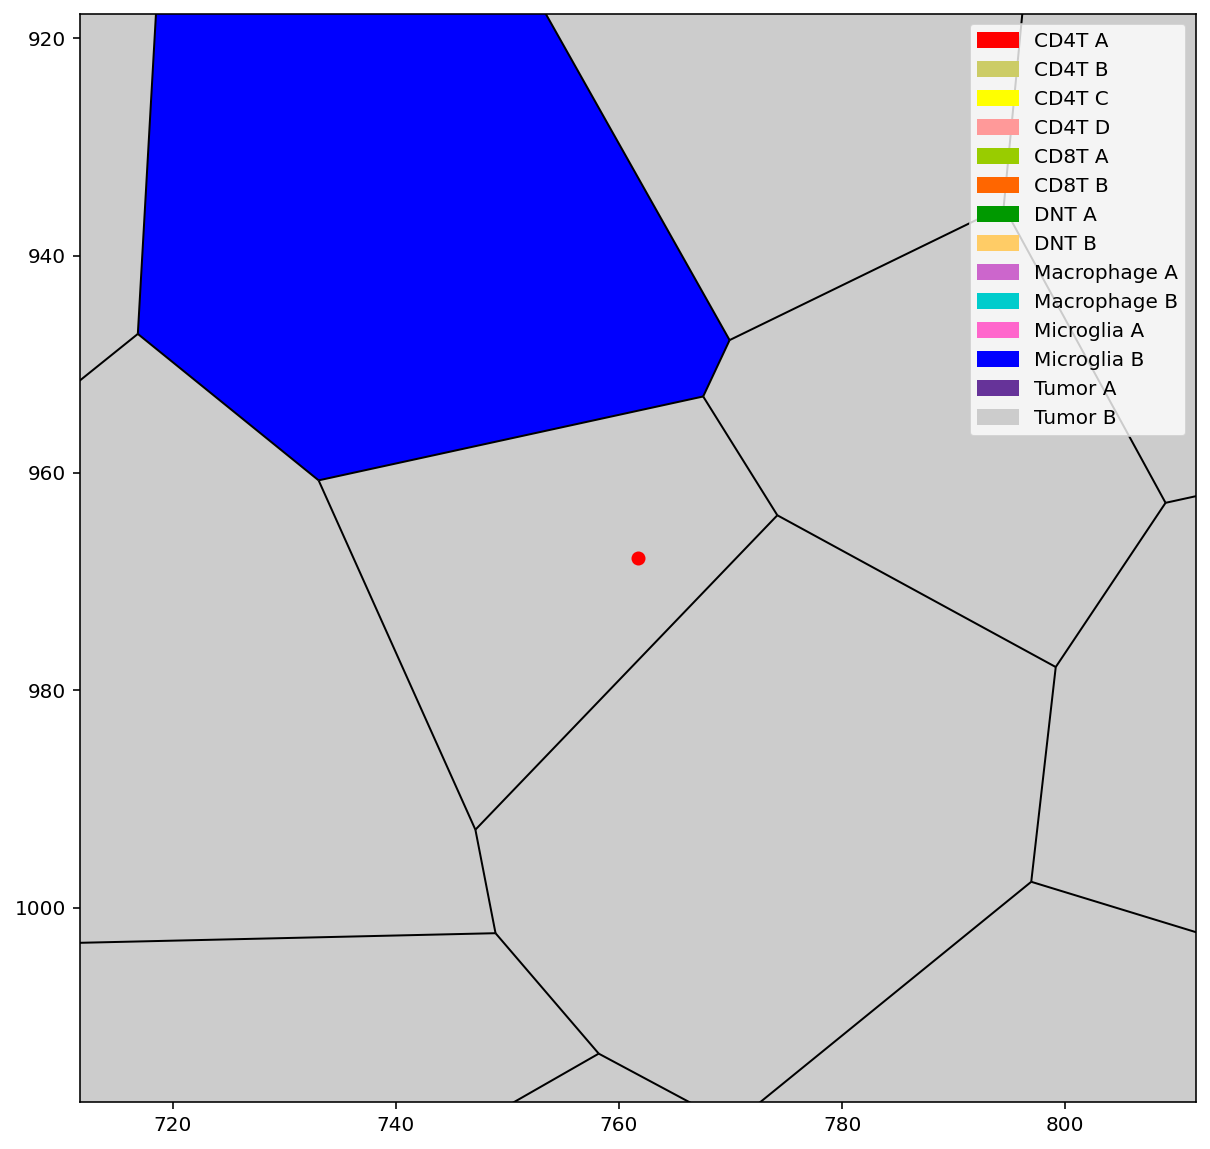

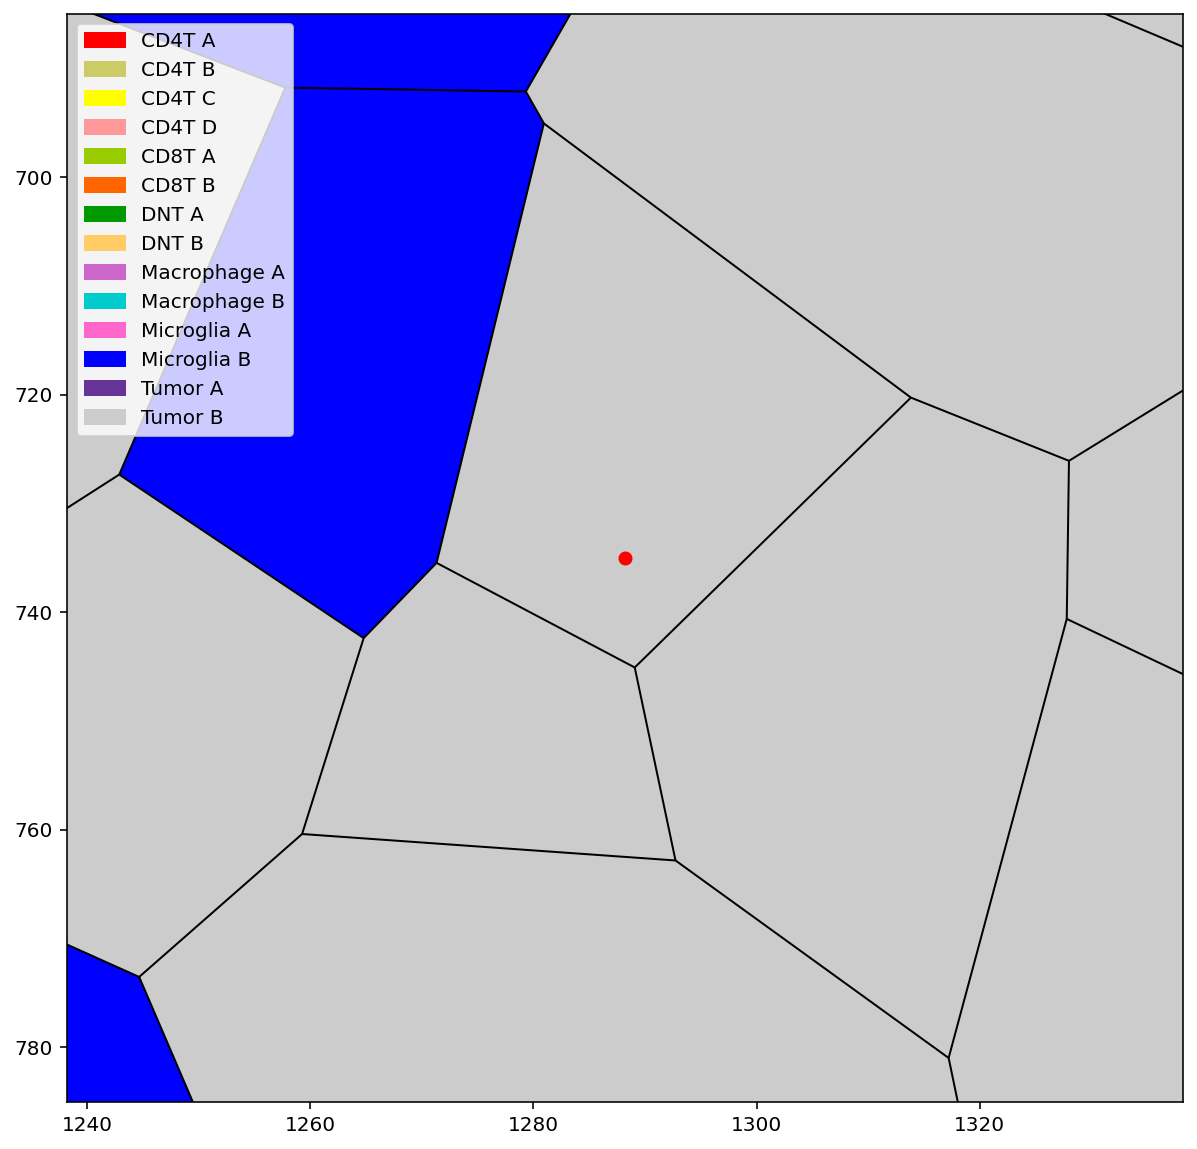

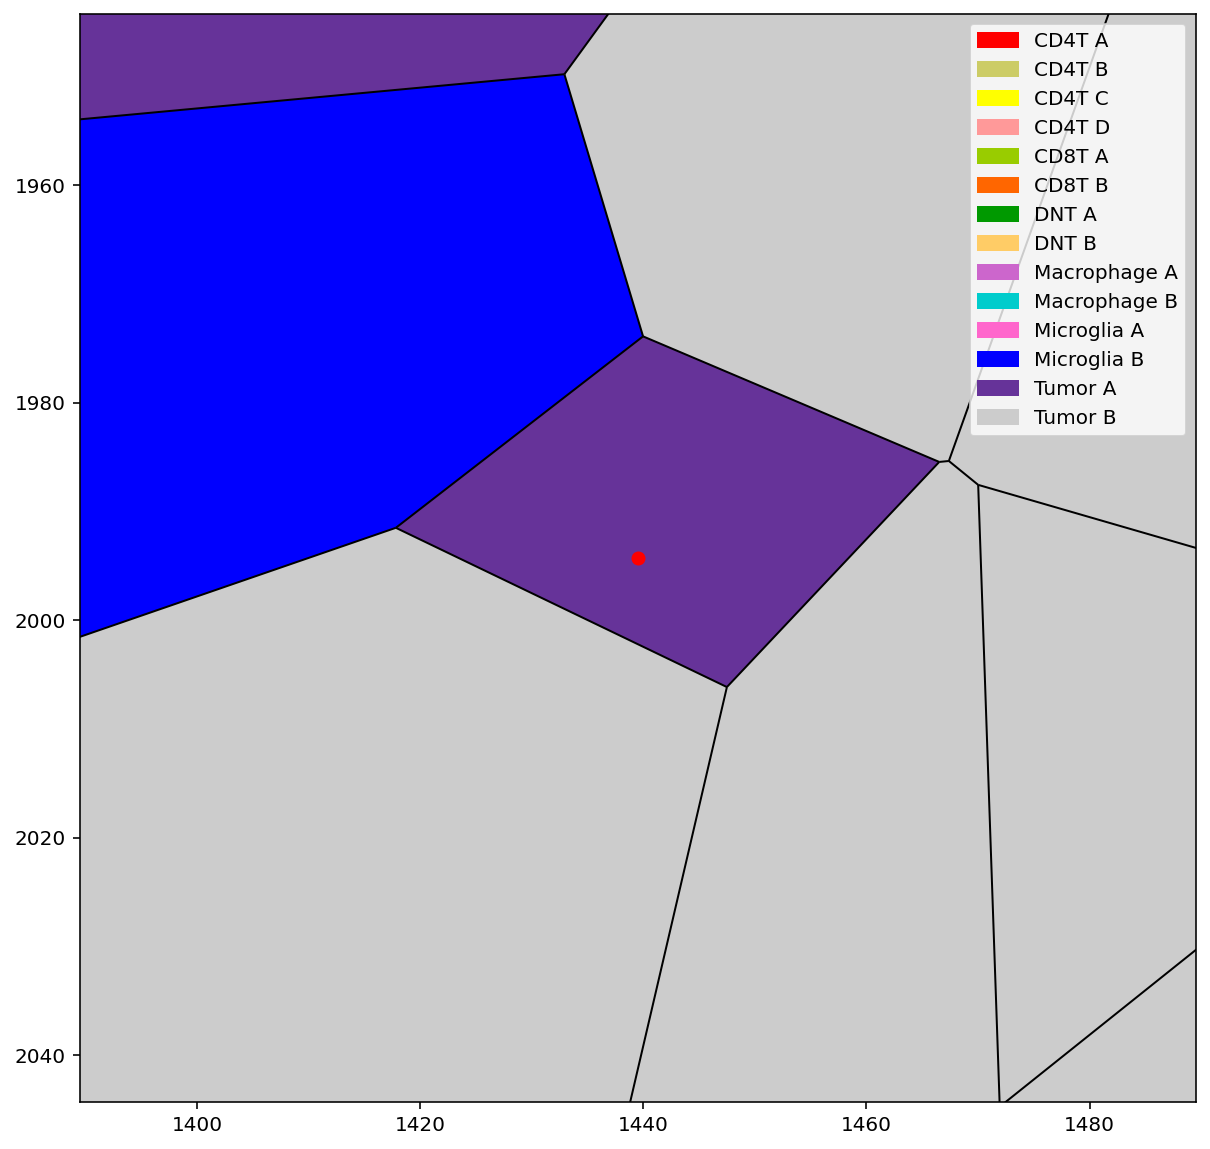

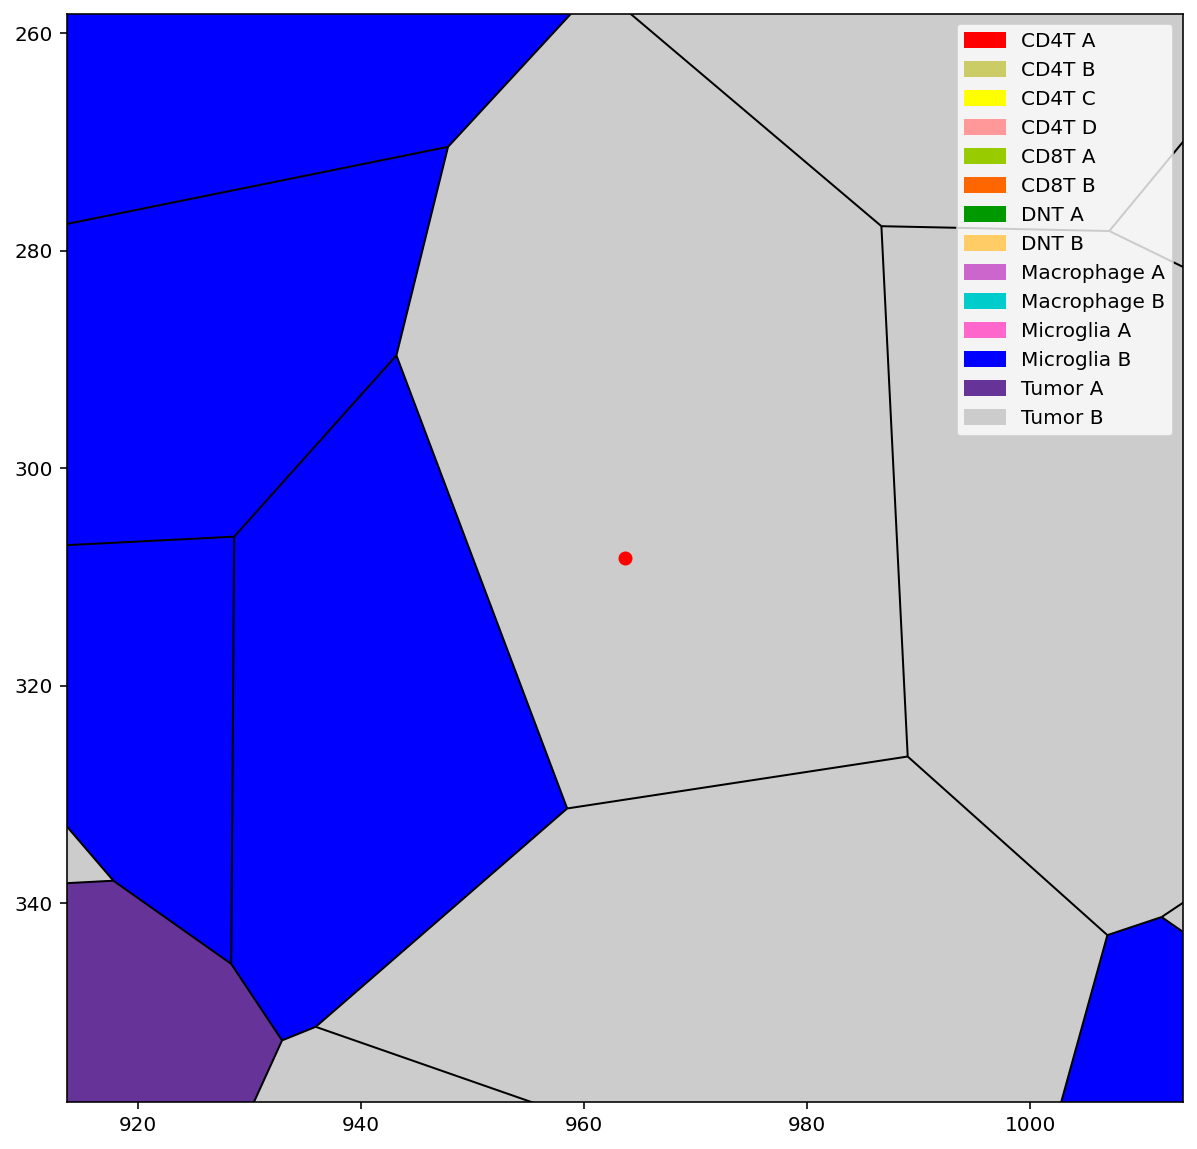

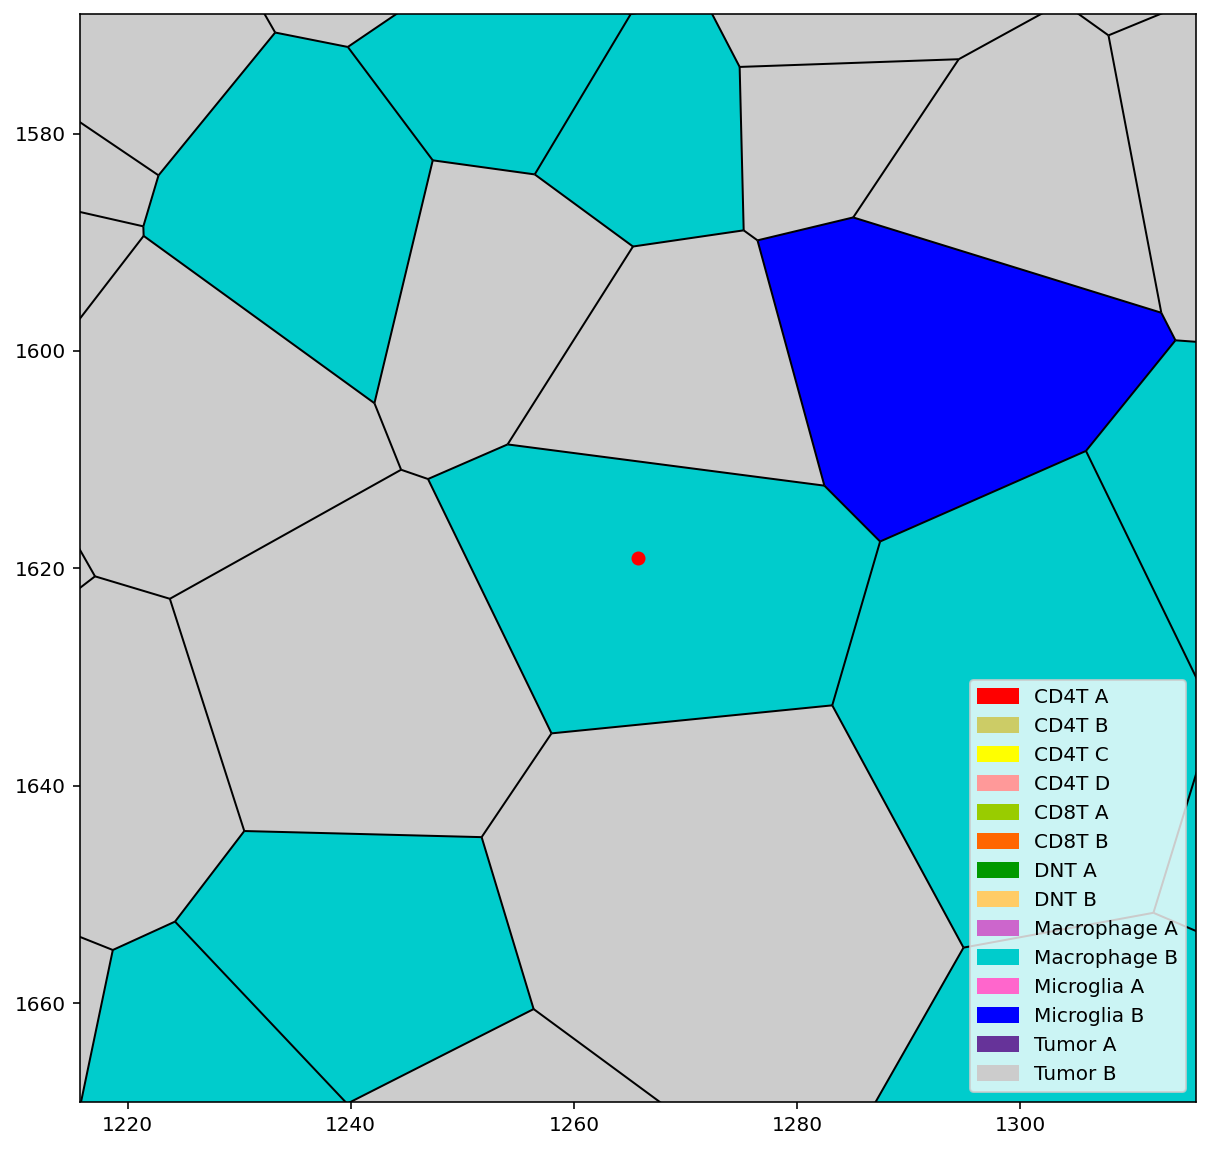

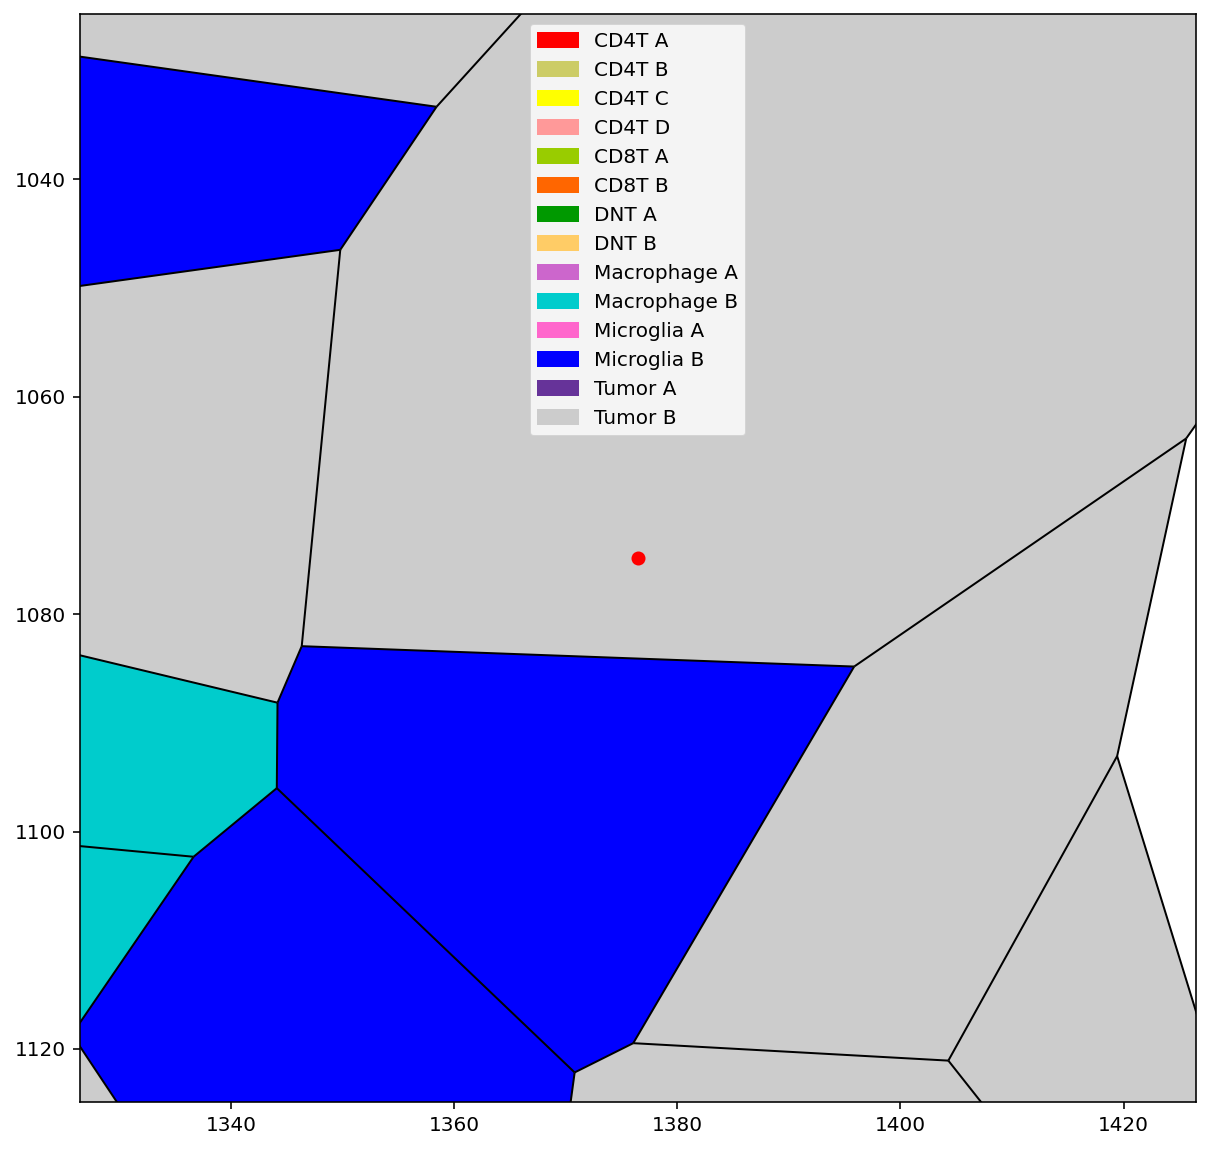

time: 3min 19s (started: 2022-08-11 15:58:03 -05:00)


In [71]:
# for each cluster, selects 3 index cells at random and prints voronoi plots colored by population IDs
#sets radius of window around sample index cells
radius = 50

for index, row in df_sample_plots.groupby('kmeans_cluster').sample(3).iterrows():
    cell_y = row['centroid-0']
    cell_x = row['centroid-1']
    pat = row['slide_id']
    tile_r = row['Tile_row']
    tile_c = row['Tile_col']
    cluster = row['kmeans_cluster']
    
    vor_tile = df_sample_plots[(df_sample_plots['Tile_row'] == tile_r) & (df_sample_plots['Tile_col'] == tile_c)]
    coords = np.asarray(vor_tile[['centroid-1', 'centroid-0']])    
    vor = Voronoi(coords)
    
    fig = voronoi_plot_2d(vor, show_vertices = False, show_points = False)
    fig.set_size_inches(10,10)
    for l in l_pops:
        for j in range(len(coords)):
            region = vor.regions[vor.point_region[j]]
            if not -1 in region:
                polygon = [vor.vertices[i] for i in region]
                if vor_tile['pop_ID'].iloc[j] == l:
                    color = vor_pops[l]
                    plt.fill(*zip(*polygon), color)
    plt.ylim(cell_y-radius,cell_y+radius)
    plt.xlim(cell_x -radius,cell_x + radius)
    plt.plot(cell_x, cell_y, 'ro')
    plt.gca().invert_yaxis()

    handles = []
    for i, x in enumerate(l_pops):
        h = mpatches.Patch(color = vor_pops[l_pops[i]], label = l_pops[i])
        handles.append(h)

    plt.legend(handles = handles)

    plt.savefig(neighbor_plots_dir + '/Per_Cluster/Vor_cluster{}_{}.pdf'.format(cluster, index), dpi=500)

### Slide colored by clusterID

In [72]:
#Plot each cluster by itself per slide
for slide in l_clustered:
    df_sample_plots = pd.read_csv(slide)
    sample_slide = os.path.basename(slide).split('_')[0]
    for l in range(len(df_sample_plots['kmeans_cluster'].unique())):
        plt.figure(figsize = (10,10))
        sns.scatterplot(data = df_sample_plots, x = 'Global_x', y = 'Global_y', color = 'gray', alpha = 0.25, linewidth = 0, s = 5).set_aspect('equal')
        sns.scatterplot(data = df_sample_plots[df_sample_plots['kmeans_cluster']==l], x = 'Global_x', y = 'Global_y', color = 'blue', linewidth = 0, s = 5).set_aspect('equal')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_Neighborhood_Cluster_{}.pdf'.format(sample_slide, l), dpi=500)
        plt.close()

time: 2.89 s (started: 2022-08-11 16:01:22 -05:00)


In [73]:
# Plot all points colored by cluster per slide
for slide in l_clustered:
    df_sample_plots = pd.read_csv(slide)
    sample_slide = os.path.basename(slide).split('_')[0]
    
    plt.figure(figsize = (20,20))
    sns.scatterplot(data = df_sample_plots, x = 'Global_x', y = 'Global_y', hue = 'kmeans_cluster', palette = 'tab20', linewidth=0, s = 4)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_All_Clusters_Colored_largedots.pdf'.format(sample_slide, l), dpi=500)
    plt.close()

time: 660 ms (started: 2022-08-11 16:01:25 -05:00)


In [74]:
# Plot all points colored by cluster per slide
for slide in l_clustered:
    df_sample_plots = pd.read_csv(slide)
    sample_slide = os.path.basename(slide).split('_')[0]
    
    plt.figure(figsize = (20,20))
    sns.scatterplot(data = df_sample_plots, x = 'Global_x', y = 'Global_y', hue = 'kmeans_cluster', palette = 'tab20', linewidth=0, s = 1)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_All_Clusters_Colored_smalldots.pdf'.format(sample_slide, l), dpi=500)
    plt.close()

time: 656 ms (started: 2022-08-11 16:01:26 -05:00)


In [75]:
# Plot all points colored by gated population ID per slide
for slide in l_clustered:
    df_sample_plots = pd.read_csv(slide)
    sample_slide = os.path.basename(slide).split('_')[0]
    
    plt.figure(figsize = (20,20))
    sns.scatterplot(data = df_sample_plots, x = 'Global_x', y = 'Global_y', hue = 'pop_ID', palette = vor_pops, linewidth=0, s = 4)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_All_Pops_Colored_s4.pdf'.format(sample_slide, l), dpi=500)
    plt.close()

time: 609 ms (started: 2022-08-11 16:01:27 -05:00)


In [76]:
# Plot all points colored by gated population ID per slide
for slide in l_clustered:
    df_sample_plots = pd.read_csv(slide)
    sample_slide = os.path.basename(slide).split('_')[0]
    
    plt.figure(figsize = (20,20))
    sns.scatterplot(data = df_sample_plots, x = 'Global_x', y = 'Global_y', hue = 'pop_ID', palette = vor_pops, linewidth=0, s = 1)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    plt.savefig(neighbor_plots_dir + '/Per_Slide/{}_All_Pops_Colored_s1.pdf'.format(sample_slide, l), dpi=500)
    plt.close()

time: 606 ms (started: 2022-08-11 16:01:27 -05:00)


### Decagon Drawings of Clusters

In [77]:
for drawing in range(len(np.unique(df_sample_plots['kmeans_cluster']))):
    rounded = df_sample_plots[l_pops][df_sample_plots['kmeans_cluster'] == drawing].mean()                    # UPDATED
    rounded = pd.DataFrame(rounded)
    
    rounded['dec'] = rounded.apply(lambda x: np.floor(x*10))
    rounded['rem'] = rounded[0].apply(lambda x: (x*10)-int(x*10))
    tot = 10 - int(rounded['dec'].sum())
    rounded.nlargest(tot, ['rem'])['dec'].apply(lambda x : x + 1)
    rounded.update(pd.DataFrame(rounded.nlargest(tot, ['rem'])['dec'].apply(lambda x : x + 1)))
    rounded['dec'] = rounded['dec'].apply(np.int64)
    rounded = rounded.sort_values(by = ['dec'], ascending = False)
    for_dec = rounded[rounded.dec != 0].reset_index()
    
    d_dec = {}
    for index, row in for_dec.iterrows():
        d_dec[row['index']] = row['dec']
    d_turtle = {}
    count2 = 0
    for key, val in d_dec.items():
        count = val
        while count > 0:
            d_turtle[count2] = vor_pops[key]
            count -= 1
            count2 +=1
        else:
            count = 0
            
    pen = 6
    side = 100

    t = turtle.Turtle()
    t.hideturtle()
    t.pensize(pen)
    t.speed(0)
    for i in range(10):
        t.forward(side)
        t.right(36)
    t.penup()
    t.goto(0, side*3+pen)
    t.pendown()
    for y in range(10):
        t.fillcolor(d_turtle[y])
        if y == 0:
            t.begin_fill()
            for i in range(10):
                t.forward(side)
                t.right(36)
            t.end_fill()
            t.penup()
            for k in range(2):
                t.forward(side)
                t.right(36)
            t.left(72)
            t.pendown()
        else:
            t.fillcolor(d_turtle[y])
            t.begin_fill()
            for i in range(10):
                t.forward(side)
                t.right(36)
            t.end_fill()
            t.penup()
            for k in range(3):
                t.forward(side)
                t.right(36)
            t.left(72)
            t.pendown()  
    ts = t.getscreen().getcanvas().postscript(file = 'test.eps', width = 1500, height = 1500)
    img = Image.open('test.eps')
    img.save(neighbor_plots_dir + '/cluster{}.jpg'.format(drawing))
    t.clear()

time: 58.8 s (started: 2022-08-11 16:01:28 -05:00)
